## Thinkful Final Capstone: Predicting opening weekend movie box office
#### By Kyle Millar-Corliss
To predict a movie's opening weekend box office (number of tickets sold at a given ticket price) using trailer views, genre and keyword information, critic scores and pageview data from wikipedia.

### The importance of predicting box office prior to release
1. Adjust movie marketing spend leading up to movie's release - majority of movie tickets purchased same day
2. Know how a movie might do based on similar films' performance
    a. With neural network, you can identify similar films in planning stage or after first trailer debut to get a sense of how important critic reviews, additional trailer metrics, etc. might be to performance
    b. Better understand the relationship between the number of theaters the movie releases in
3. With linear regression coefficients, better understand importance of input variables to box office performance 

### Gathering and scraping data
See additional jupyter notebook for source scraping methods. In order to simplify and keep my code clean, all scraping is done in a separate notebook which calls to other python files (which can be viewed with any editor). This notebook will read the already scraped data below. The code for executing the scraper can be found here: https://github.com/kylemcorliss/Thinkful/blob/master/Final%20Capstone/BO_predictor_final_capstone.scrape.ipynb

### Importing and cleaning data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
%matplotlib inline
from datetime import datetime as dt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.cm as cm
from sklearn import linear_model
import json
import logging
FORMAT = '%(asctime)-15s %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)
from sklearn.preprocessing import MinMaxScaler

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


### Section 1 -- Import data

In [3]:
# import csv files with wikipedia pageview info and supporting links
df_wiki = pd.read_csv('wikipedia_links.csv',index_col='wiki_url')
df_wiki_links = pd.read_csv('data/wiki_links_data.csv', index_col='wiki_url')
df_wiki_pageviews = pd.read_csv('data/wiki_pageviews_data.csv', index_col=0)
# import csv file with ratings from both RT and metacritic
df_rt = pd.read_csv('data/rottentomatoes_data.csv', index_col='wiki_url')
df_mc = pd.read_csv('data/metacritic_data.csv', index_col='wiki_url')
# import csv file with bomojo box office information for each
df_bomojo = pd.read_csv('data/bomojo_data.csv', index_col='wiki_url')
# import TheMovieDB data including youtube trailer view data
df_tmdb = pd.read_csv('data/themoviedb_data.csv', converters={'genres':json.loads,'credits':json.loads,
                                                              'keywords':json.loads,'production_companies':json.loads,
                                                              'production_countries':json.loads,
                                                              'video_stats':json.loads},header=0, index_col='wiki_url')
df_tmdb = df_tmdb.drop(['adult', 'backdrop_path', 'belongs_to_collection','facebook_id', 'homepage','instagram_id',
             'original_language', 'original_title','poster_path','spoken_languages', 'status','twitter_id','video'],axis=1)

In [4]:
df_bomojo['release_date'] = pd.to_datetime(df_bomojo.release_date)
df_tmdb['release_date'] = pd.to_datetime(df_tmdb.release_date)
df_wiki_pageviews.index = pd.to_datetime(df_wiki_pageviews.index)

### Section 2 -- Join, feature creation

In [5]:
# need to split genres, keywords, production companies
# video stats into seprate dataframe to group and create features
# pull out production country
# scale vote counts
# remove release date and revenue, get that from bomojo
# might look into tf-idf and clustering with tagline

In [6]:
# split genres, keywords and production companies and countries from column / dictionary
genre_rows = []
for i, genres in zip(df_tmdb.index,df_tmdb.genres):
    if isinstance(genres,list):
        for genre in genres:
            genre_rows.append((i, genre['name']))

df_genre = pd.DataFrame(genre_rows,columns=['wiki_url','genre'])
df_genre.set_index('wiki_url',inplace=True)
df_genre = pd.get_dummies(df_genre).groupby('wiki_url').sum()

In [7]:
keyword_rows = []
for i, keywords in zip(df_tmdb.index,df_tmdb.keywords):
    if isinstance(keywords,list):
        for keyword in keywords:
            keyword_rows.append((i, keyword['name']))

df_keyword_stage = pd.DataFrame(keyword_rows,columns=['wiki_url','keyword'])
df_keyword_stage.set_index('wiki_url',inplace=True)
df_keyword = pd.get_dummies(df_keyword_stage).groupby('wiki_url').sum()

In [8]:
prod_rows = []
for i, prods in zip(df_tmdb.index,df_tmdb.production_companies):
    if isinstance(prods,list):
        for prod in prods:
            prod_rows.append((i, prod['name']))

df_prod_cos = pd.DataFrame(prod_rows,columns=['wiki_url','prod_company'])
df_prod_cos.set_index('wiki_url',inplace=True)
df_prod_cos = pd.get_dummies(df_prod_cos).groupby('wiki_url').sum()

In [9]:
prod_co_rows = []
for i, prods in zip(df_tmdb.index,df_tmdb.production_countries):
    if isinstance(prods,list):
        for prod in prods:
            prod_co_rows.append((i, prod['name']))

df_prod_country = pd.DataFrame(prod_co_rows,columns=['wiki_url','prod_country'])
df_prod_country.set_index('wiki_url',inplace=True)
df_prod_country = pd.get_dummies(df_prod_country).groupby('wiki_url').sum()

In [10]:
credit_rows = []
for i, credits in zip(df_tmdb.index,df_tmdb.credits):
    if isinstance(credits,list):
        for credit in credits:
            credit_rows.append((i, credit['name']))

df_credits = pd.DataFrame(credit_rows,columns=['wiki_url','credit_name'])
df_credits.set_index('wiki_url',inplace=True)
df_credits = pd.get_dummies(df_credits).groupby('wiki_url').sum()

In [11]:
# create dataframe of YT video statistics
video_rows = []
for i, videos in zip(df_tmdb.index,df_tmdb.video_stats):
    if isinstance(videos,list):
        for video in videos:
            if video is not None:
                video['wiki_url'] = i
                video_rows.append(video)

df_video = pd.DataFrame(video_rows)
df_video = df_video.drop(['favoriteCount'],axis=1).set_index('wiki_url')
df_video = df_video.apply(pd.to_numeric)
df_video = df_video.dropna()
df_video = df_video.groupby('wiki_url').agg({'viewCount' : ['count','min','max','mean','median'], 
                                             'commentCount' : ['min','max','mean','median'],
                                             'dislikeCount' : ['min','max','mean','median'],
                                            'likeCount': ['min','max','mean','median']})

In [12]:
# scaling video views
scaler = MinMaxScaler()
df_video[df_video.columns] = scaler.fit_transform(df_video[df_video.columns])

In [13]:
len(video_rows)

6702

In [14]:
df_video.describe()

viewCount                                                      \
             count          min          max         mean       median   
count  3301.000000  3301.000000  3301.000000  3301.000000  3301.000000   
mean      0.013672     0.029114     0.002914     0.006396     0.021796   
std       0.035717     0.067542     0.018348     0.021148     0.047318   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000794     0.000108     0.000350     0.001052   
50%       0.000000     0.004906     0.000554     0.001693     0.005121   
75%       0.014706     0.025780     0.002592     0.006740     0.023038   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

      commentCount                                        dislikeCount  \
               min          max         mean       median          min   
count  3301.000000  3301.000000  3301.000000  3301.000000  3301.000000   
mean      0.008529     0.006667     0.014614     0.012231     0.006343   
std       0.036622     0.032033     0.052169     0.045764     0.035152   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000070     0.000077     0.000273     0.000202     0.000065   
50%       0.000624     0.000526     0.001759     0.001301     0.000446   
75%       0.004220     0.002974     0.008714     0.007285     0.002678   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                                                likeCount               \
               max         mean       median          min          max   
count  3301.000000  3301.000000  3301.000000  3301.000000  3301.000000   
mean      0.001939     0.002875     0.008981     0.006734     0.007328   
std       0.021728     0.022027     0.041395     0.033122     0.038322   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000020     0.000047     0.000163     0.000072     0.000080   
50%       0.000114     0.000272     0.000849     0.000496     0.000507   
75%       0.000686     0.001369     0.004583     0.002967     0.003023   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                                 
              mean       median  
count  3301.000000  3301.000000  
mean      0.011662     0.009880  
std       0.046355     0.040760  
min       0.000000     0.000000  
25%       0.000212     0.000170  
50%       0.001218     0.000949  
75%       0.006155     0.004880  
max       1.000000     1.000000

### Clustering TheMovieDB movie information

In [15]:
def join_dataframes(df1, *others):
    new_df = df1
    for df in others:
        new_df = new_df.merge(df,left_index=True, right_index=True) 
    return new_df

In [16]:
from silhouette_scores import silhouette_scores

For n_clusters = 2 The average silhouette_score is : 0.018689204471828168
For n_clusters = 3 The average silhouette_score is : 0.008345175242856563
For n_clusters = 4 The average silhouette_score is : 0.0016428440981151788
For n_clusters = 5 The average silhouette_score is : 0.0012708458284674481
For n_clusters = 10 The average silhouette_score is : -0.00743273688754833
For n_clusters = 20 The average silhouette_score is : -0.01246232595438146
For n_clusters = 100 The average silhouette_score is : -0.037647316590693425


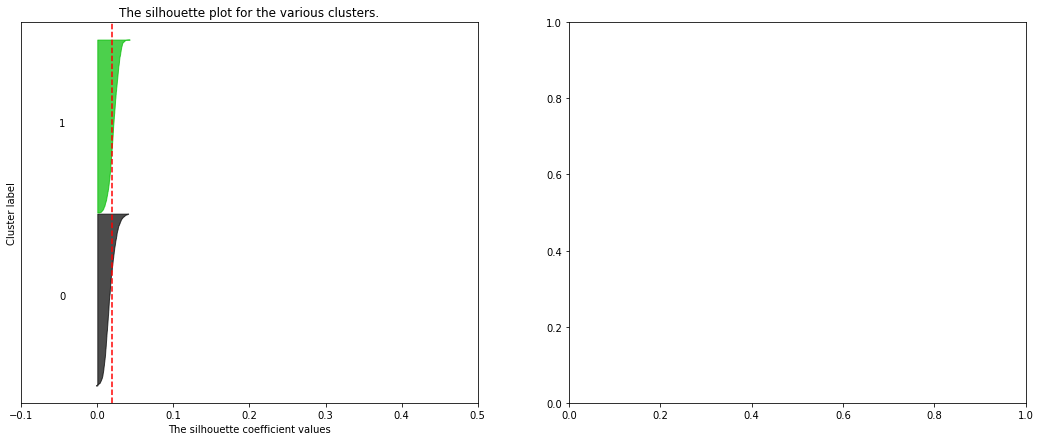

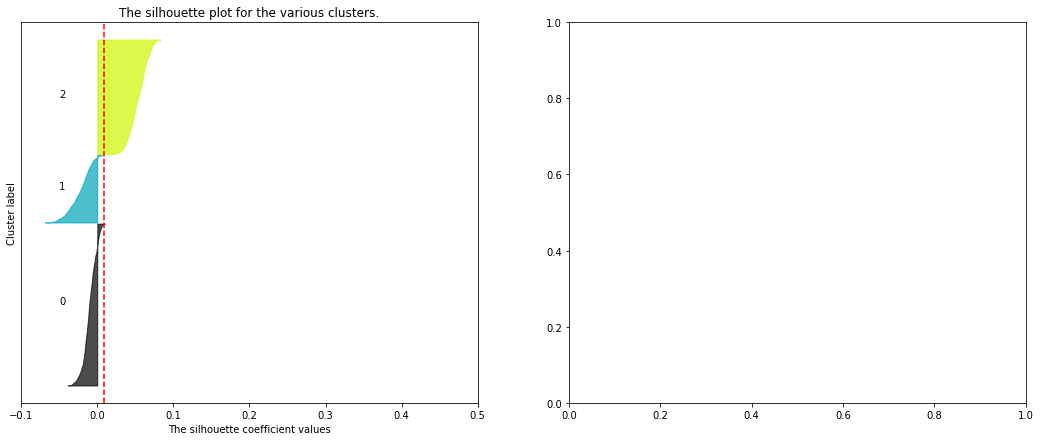

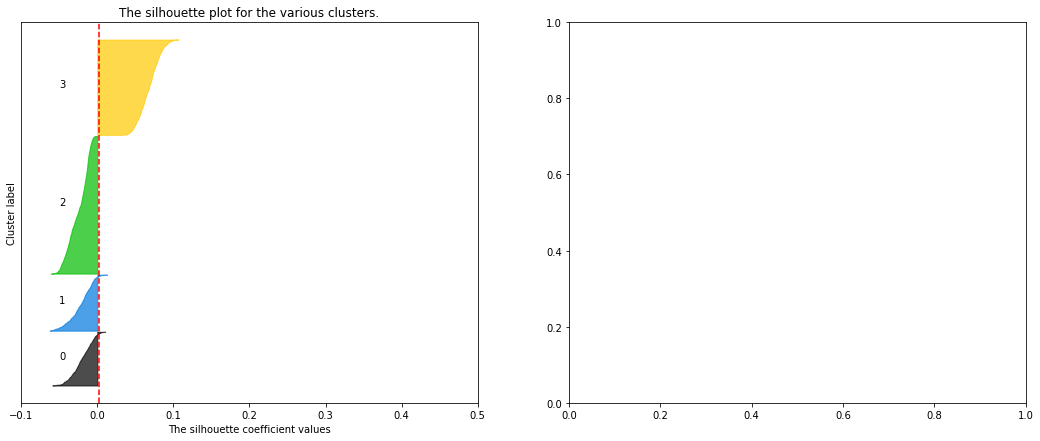

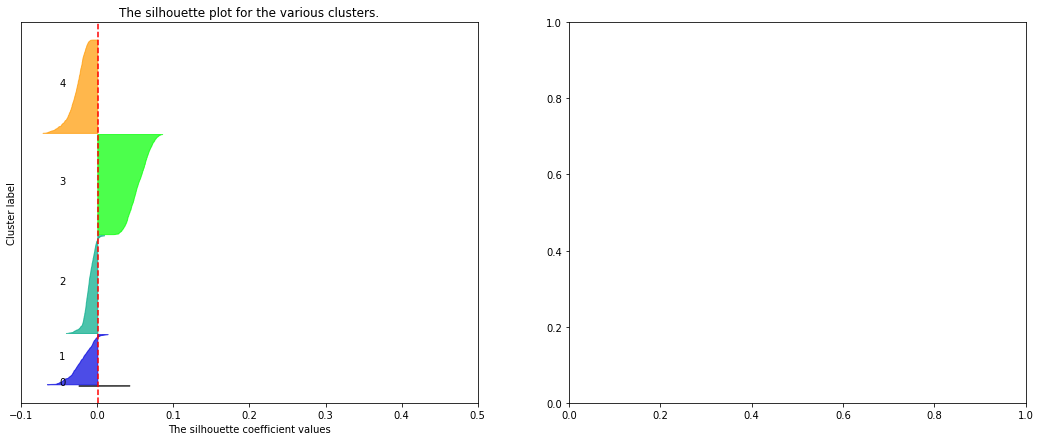

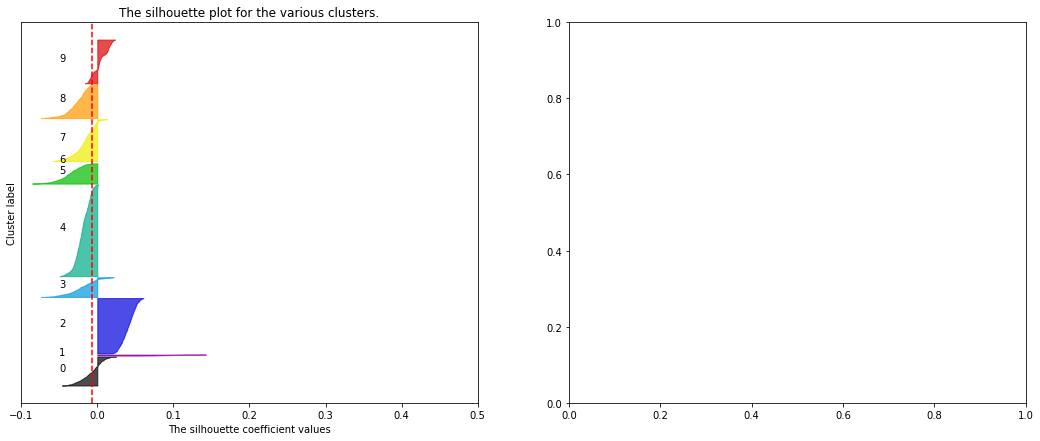

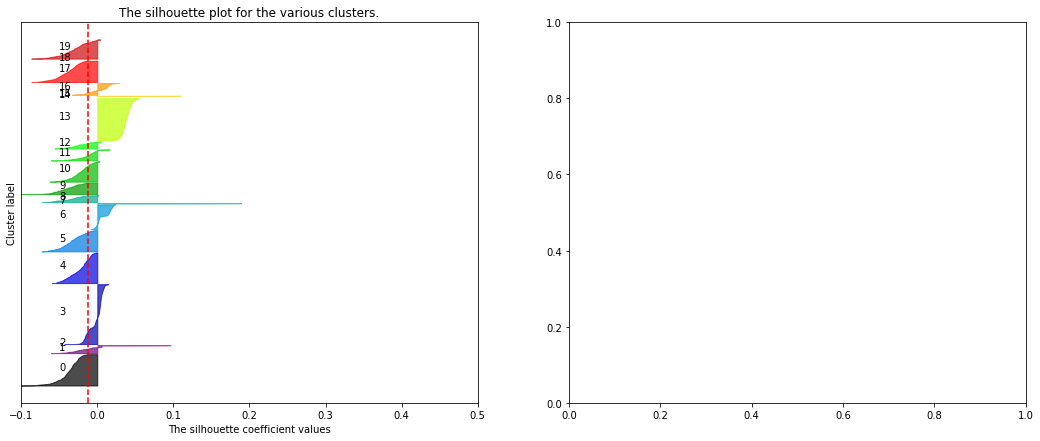

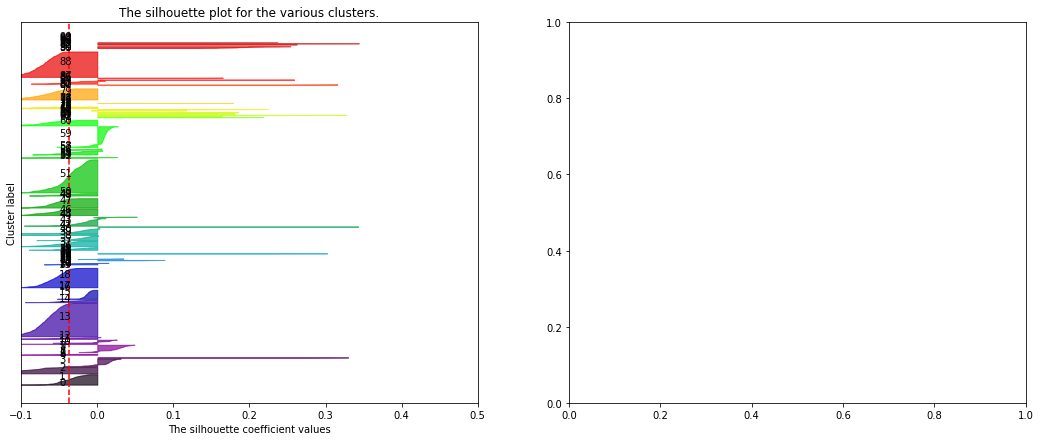

In [17]:
# cluster movie info including credits, keywords, production information
tmdb_cluster = join_dataframes(df_genre,df_prod_cos,df_prod_country,df_keyword,df_credits)
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,10,20,100]

silhouette_scores(tmdb_cluster, range_n_clusters, KMeans,.5)

Tried KMeans and SpectralClustering with n_clusters from 2-150. None of the options provided very good silhouette scores. I also ran the silhouette scores with and without the actor credits, that didn't help much either. 

Other options for using actor credits:
1. Reduce number of actor credits identified - I first tried 10 actors and moved to 5 to try and limit dimensions
2. Use historical box office prior to a film being released to rank actors money-making power
3. Average the money-making power across all the actors in a film prior to release

For n_clusters = 2 The average silhouette_score is : 0.0244810815283566
For n_clusters = 3 The average silhouette_score is : 0.015041909504072432
For n_clusters = 4 The average silhouette_score is : -0.0024481111802774464
For n_clusters = 5 The average silhouette_score is : -0.003783616551884698
For n_clusters = 10 The average silhouette_score is : -0.014599489275115216
For n_clusters = 20 The average silhouette_score is : -0.002620461962920325
For n_clusters = 30 The average silhouette_score is : -0.013739216003807
For n_clusters = 100 The average silhouette_score is : -0.017967064319236194


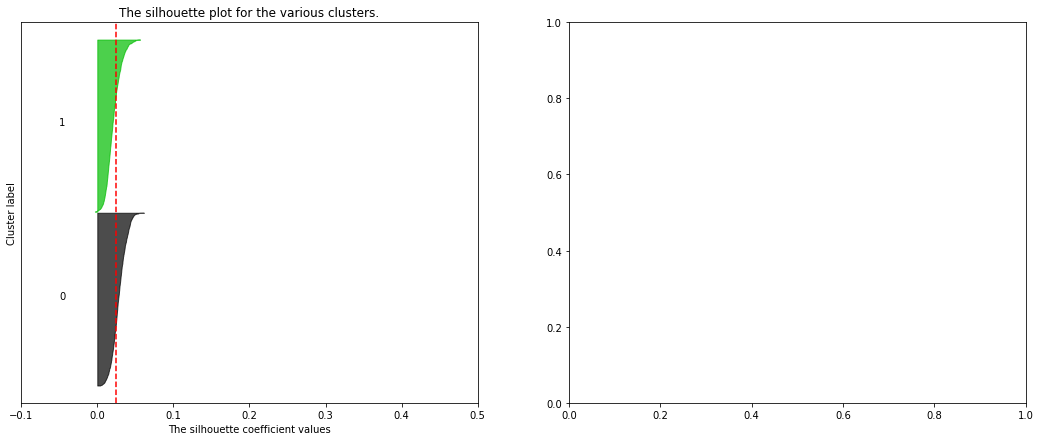

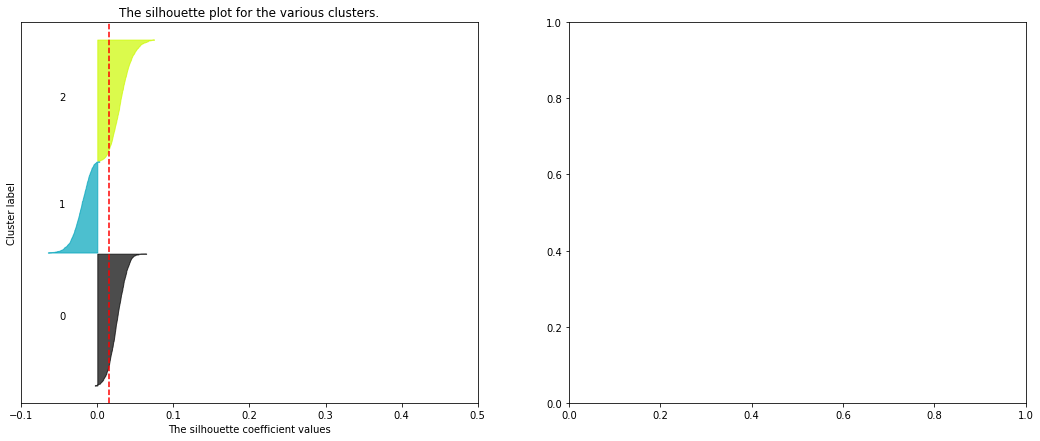

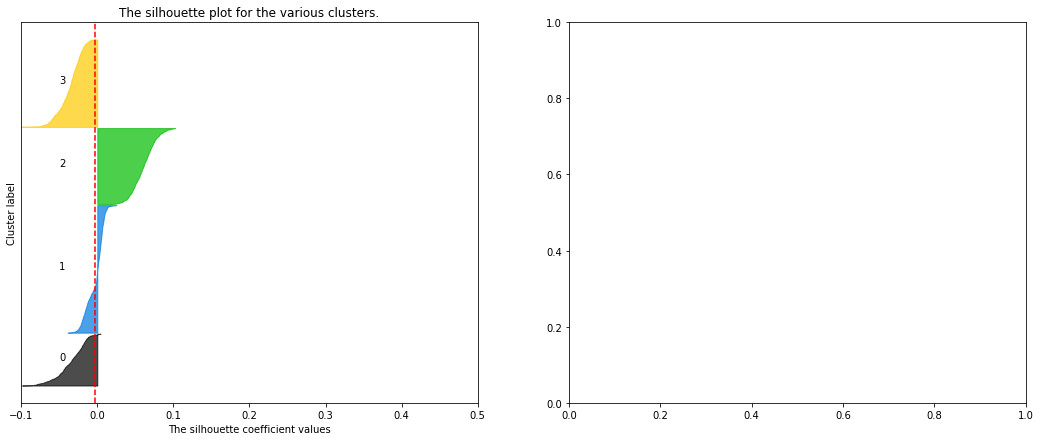

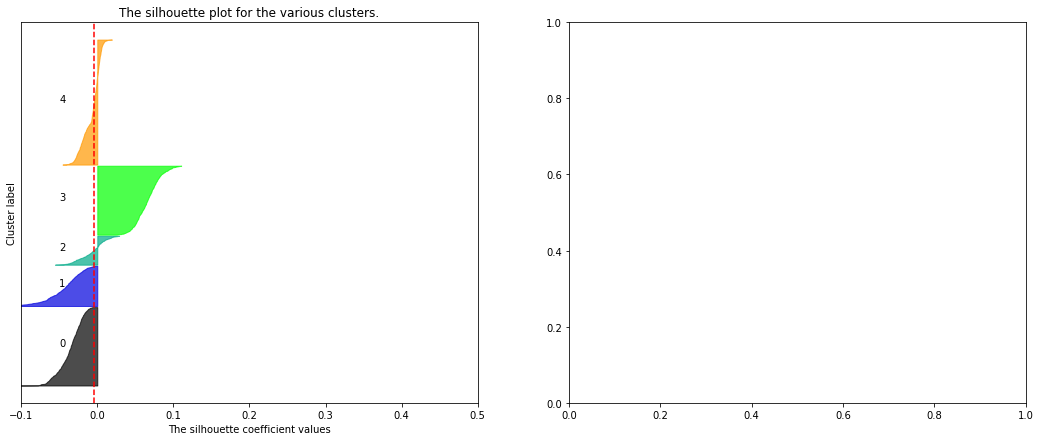

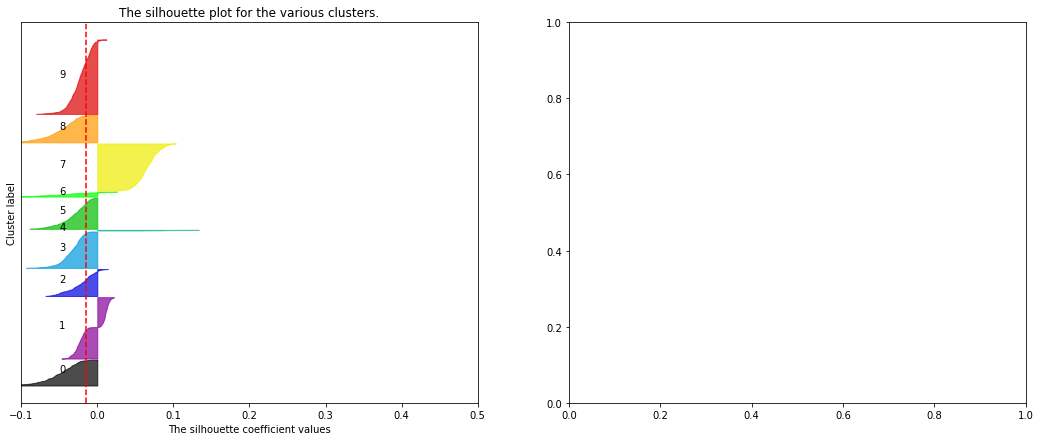

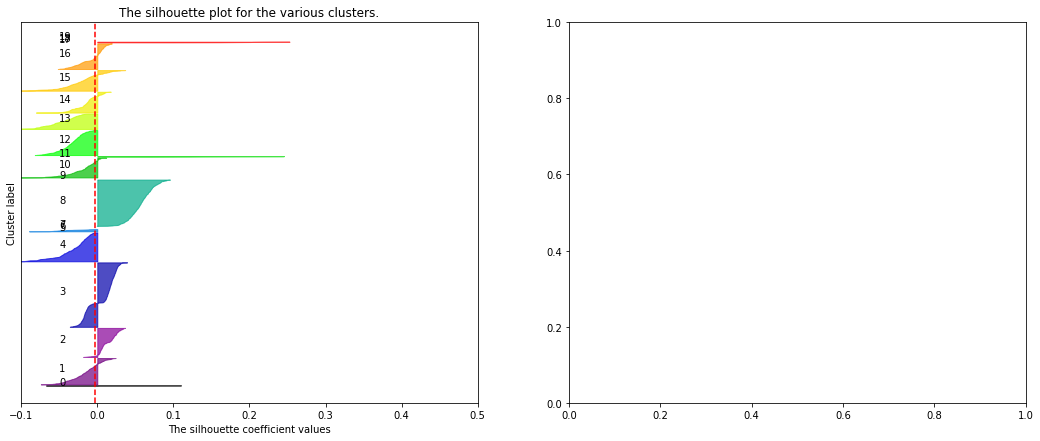

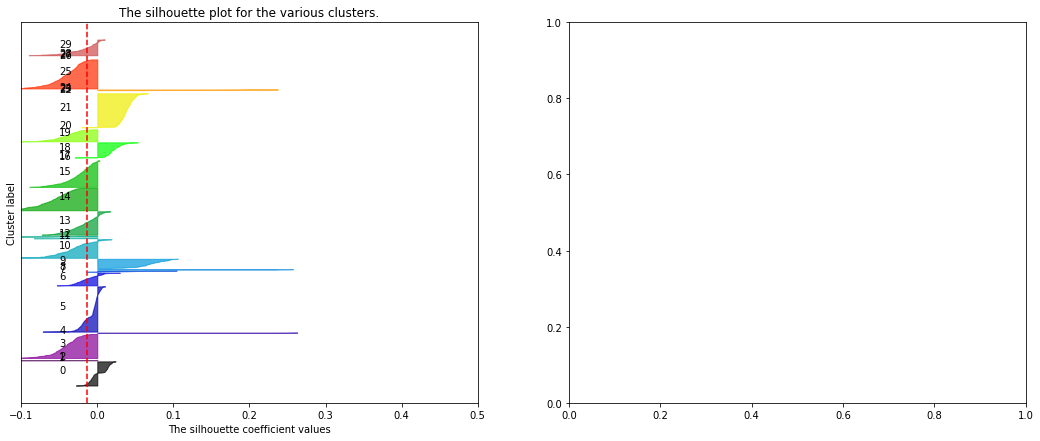

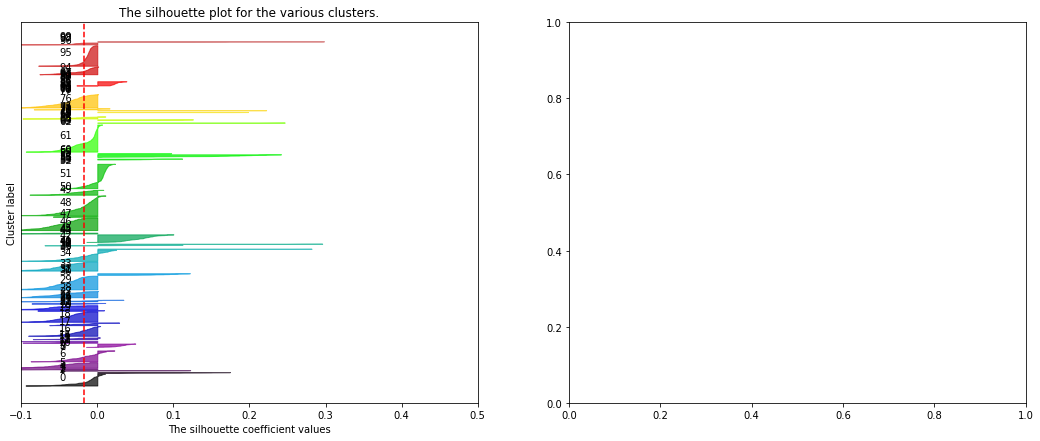

In [18]:
# removed credits with actors
tmdb_cluster = join_dataframes(df_genre,df_prod_cos,df_prod_country,df_keyword)
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,10,20,30,100]
silhouette_scores(tmdb_cluster, range_n_clusters, KMeans,.5)

For n_clusters = 2 The average silhouette_score is : 0.03588184018085676
For n_clusters = 3 The average silhouette_score is : 0.023160714308103642
For n_clusters = 4 The average silhouette_score is : 0.021300200284325475
For n_clusters = 5 The average silhouette_score is : 0.04627570584575987
For n_clusters = 10 The average silhouette_score is : 0.018956449691990528
For n_clusters = 20 The average silhouette_score is : 0.001370951797085589
For n_clusters = 30 The average silhouette_score is : -0.007013278772219387
For n_clusters = 100 The average silhouette_score is : -0.005524537802614737


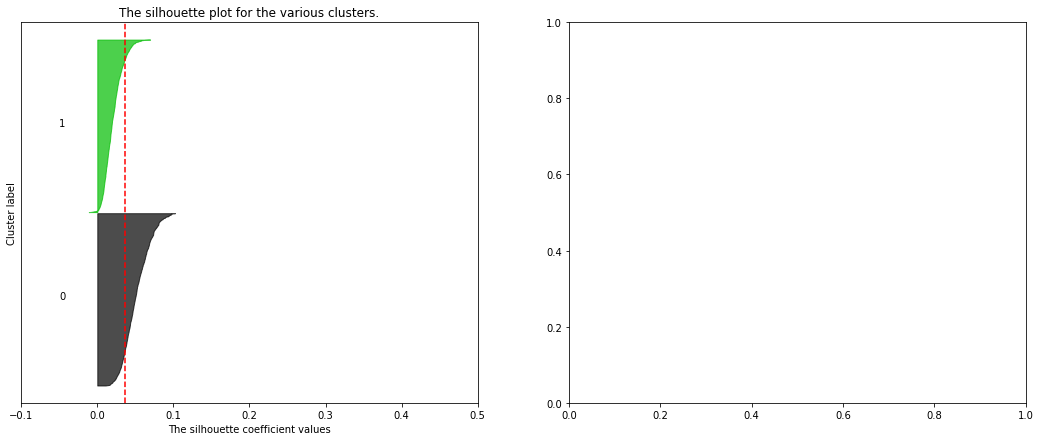

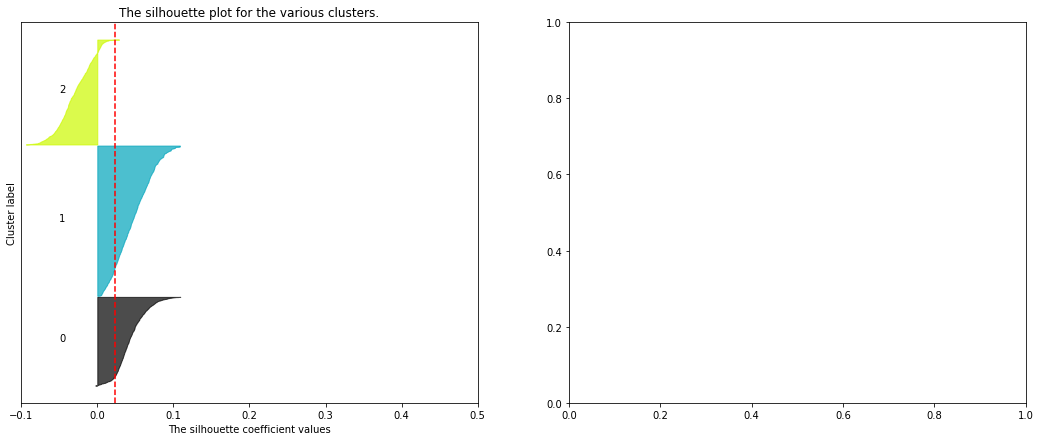

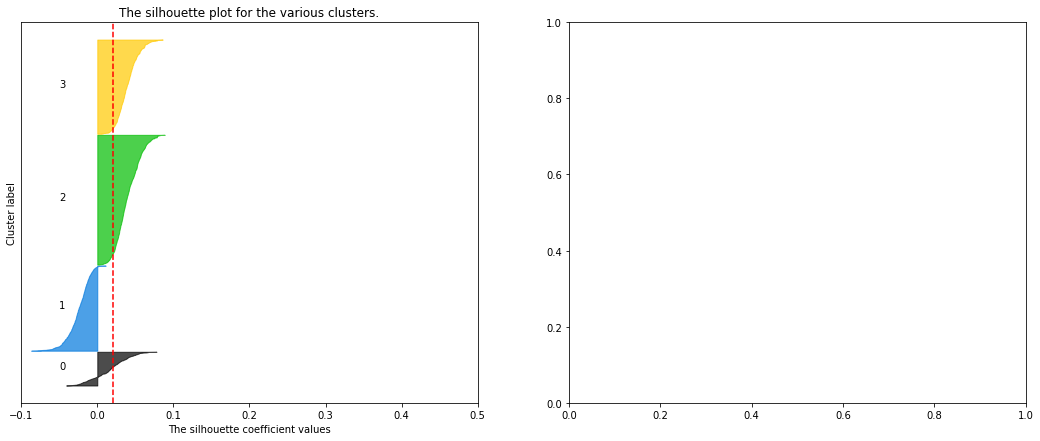

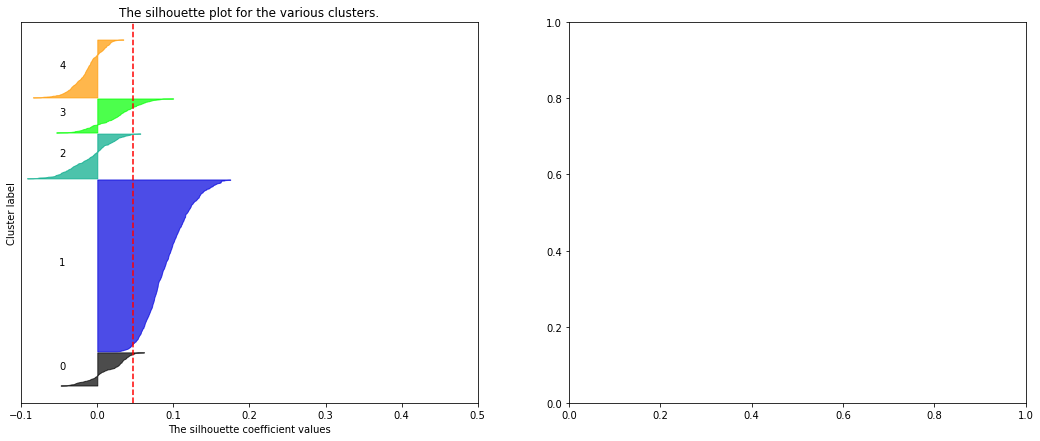

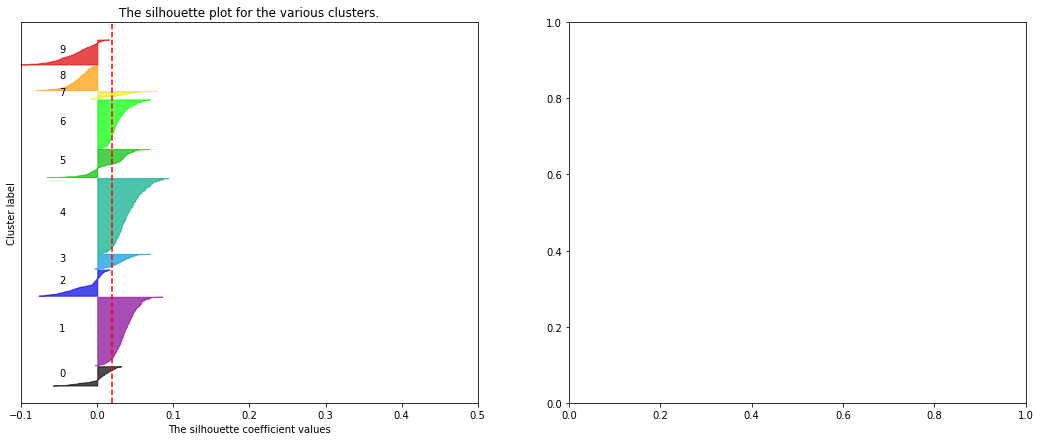

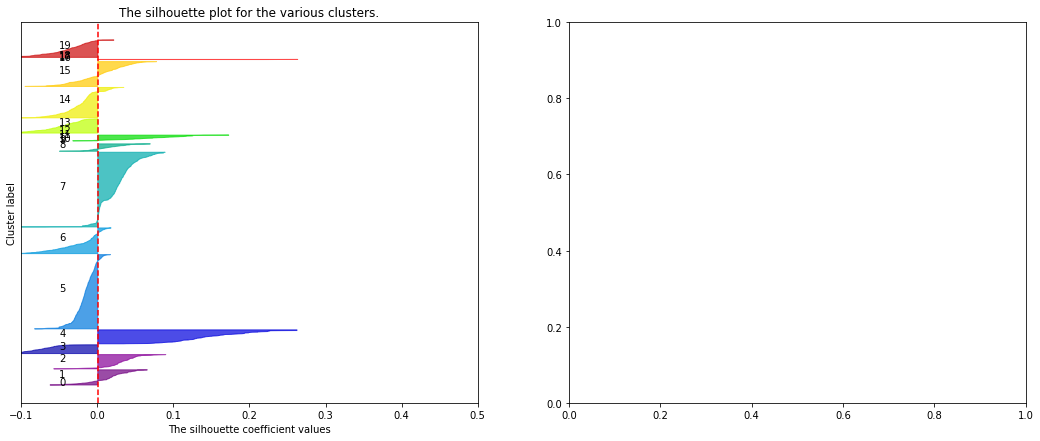

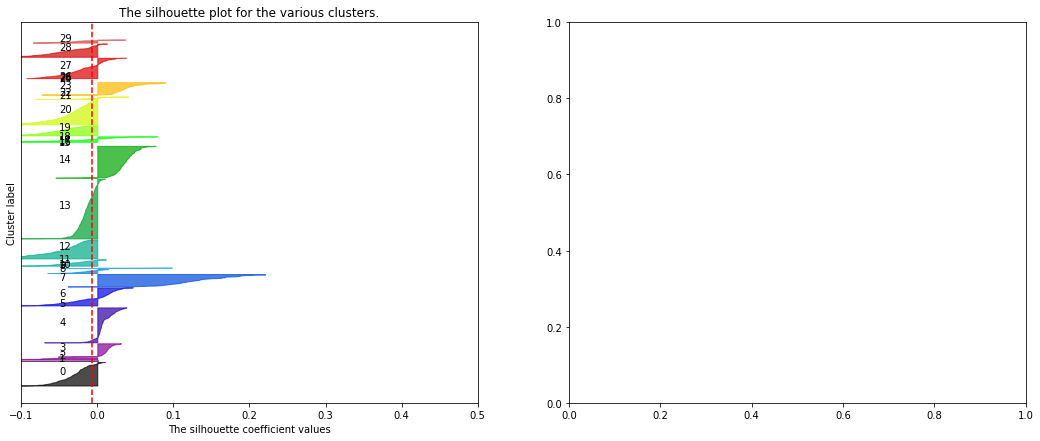

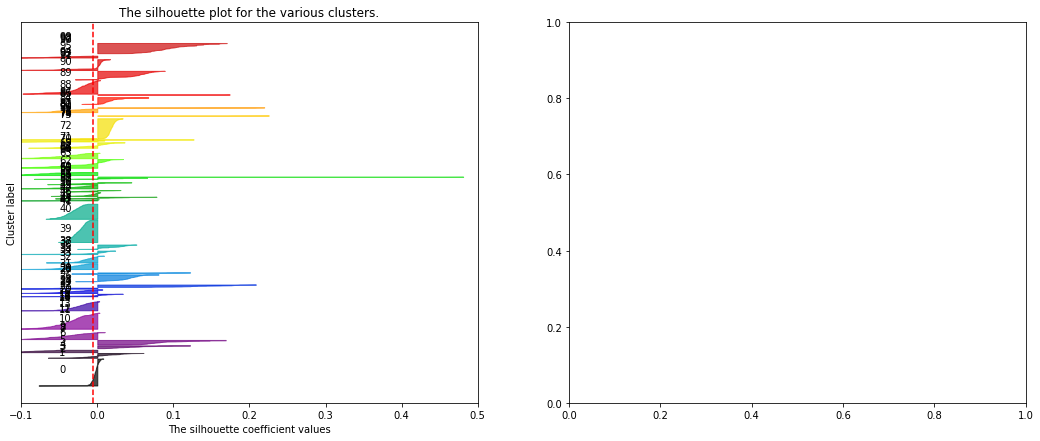

In [19]:
# only looking 
tmdb_cluster = join_dataframes(df_genre,df_keyword)
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,10,20,30,100]
silhouette_scores(tmdb_cluster, range_n_clusters, KMeans,.5)

Better silhouette scores after removing the actor credits, but still not good enough scores to be useful or represent structure within the data. However, removing the actor credits did speed up the clustering process as it removes a ton of dimensions. I will remove actor credits from further analysis and modeling as it doesn't seem to a be a useful indicator. The next iteration of the model I will perhaps only bring the top 3 actor credits instead of top 10.

Same issue when just looking at genres and keywords. I'm surprised by this finding, I expected to find some level of similarity across titles when looking at genre and keywords.

### Clustering on tf_idf of movie keywords and genres

In [17]:
from themoviedb import tfidf_movie, cluster_movie_keywords

df_keyword_agg, X_tfidf, df_tfidf = tfidf_movie(df_keyword_stage)
df_keyword_cluster, model = cluster_movie_keywords(df_keyword_agg,X_tfidf,10)

For n_clusters = 2 The average silhouette_score is : 0.011560820374988153
For n_clusters = 3 The average silhouette_score is : 0.01344115099776048
For n_clusters = 4 The average silhouette_score is : 0.019352973932857263
For n_clusters = 5 The average silhouette_score is : 0.019336784047526707
For n_clusters = 10 The average silhouette_score is : 0.025075700134448226
For n_clusters = 20 The average silhouette_score is : 0.030116749592079026
For n_clusters = 30 The average silhouette_score is : 0.032827988234830074
For n_clusters = 40 The average silhouette_score is : 0.03391376072593723
For n_clusters = 60 The average silhouette_score is : 0.03997947116931368
For n_clusters = 80 The average silhouette_score is : 0.042031077349209425
For n_clusters = 100 The average silhouette_score is : 0.007253141142798044


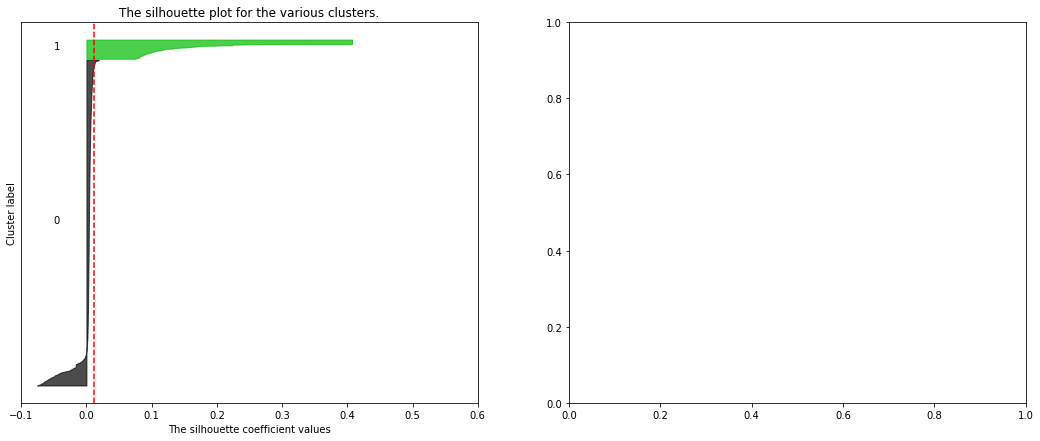

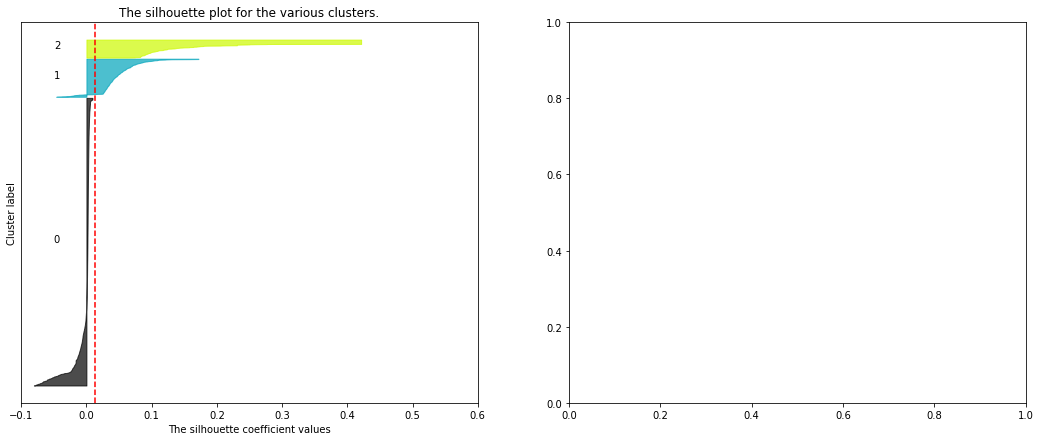

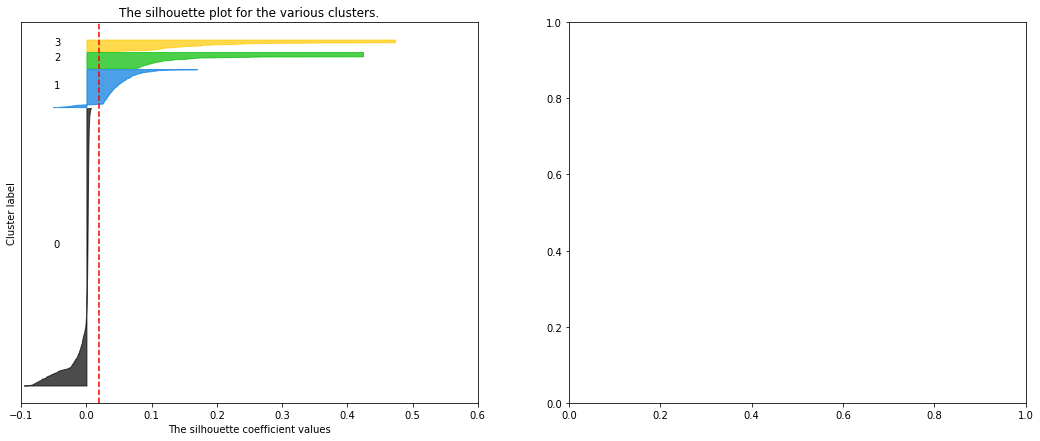

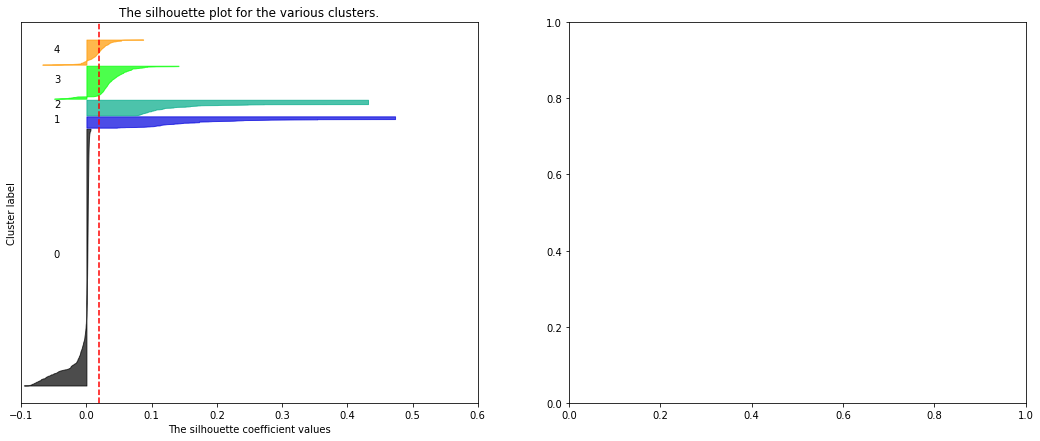

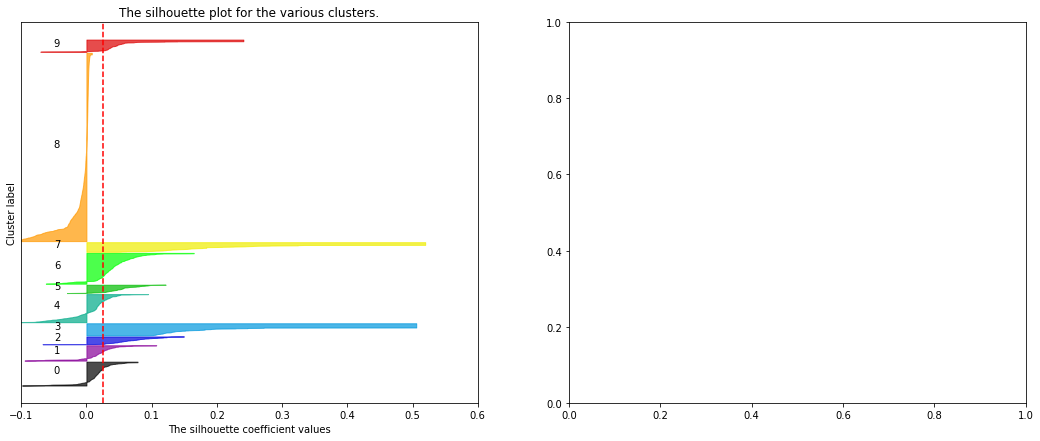

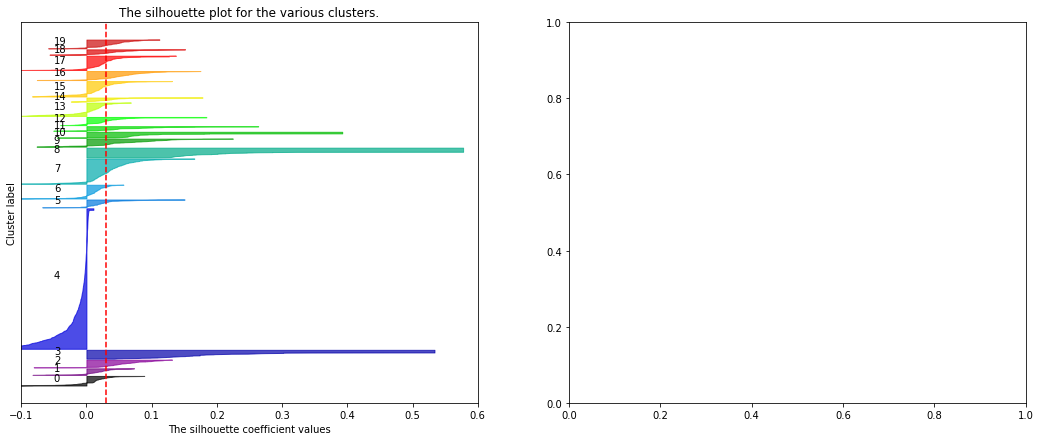

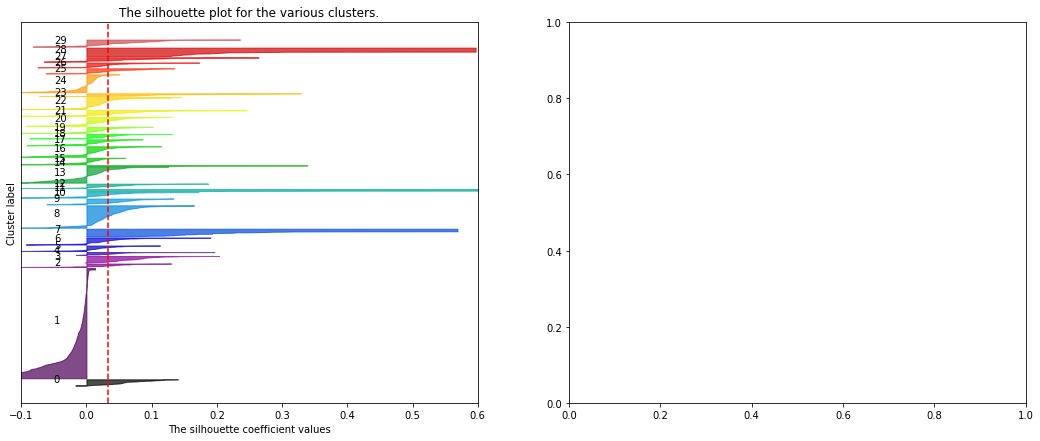

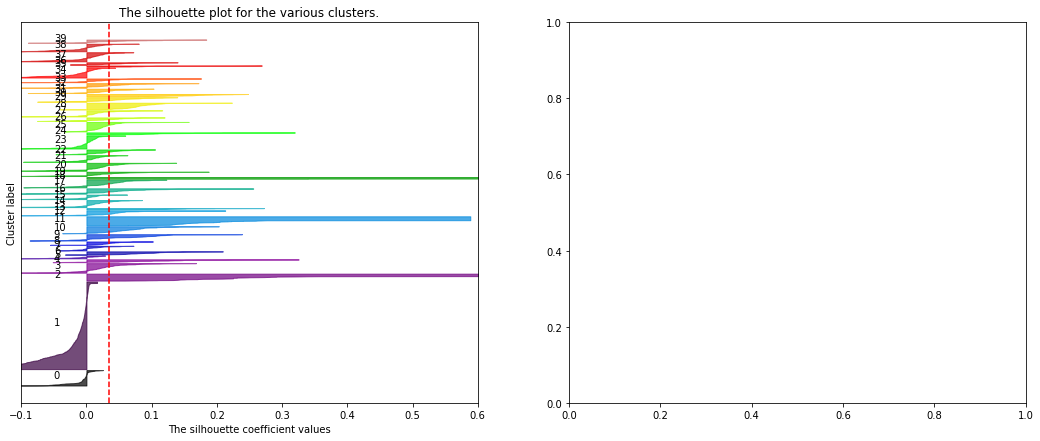

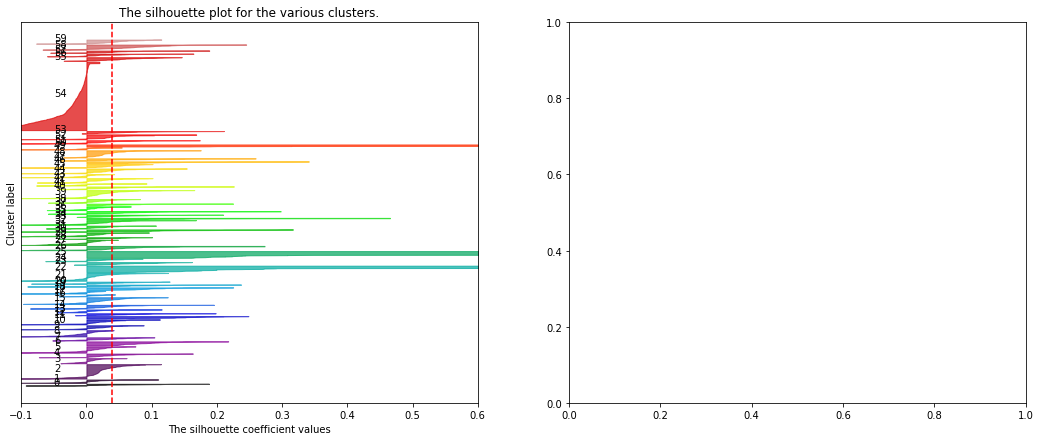

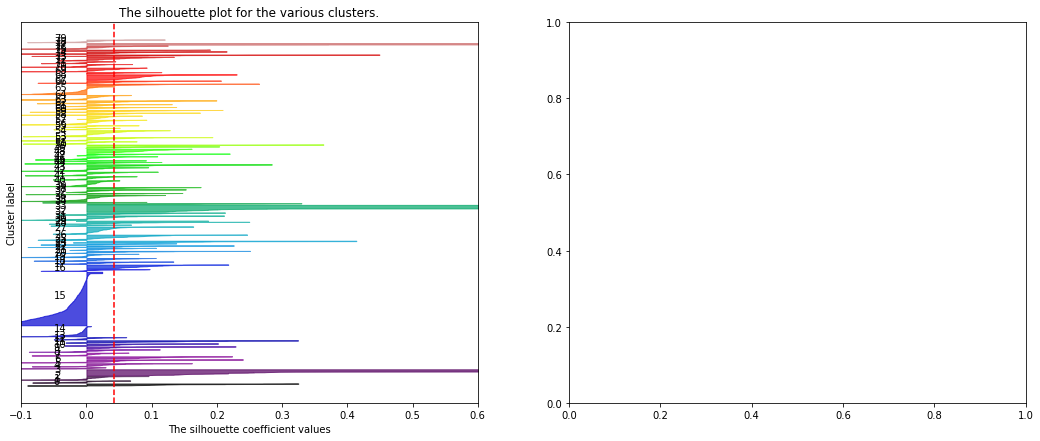

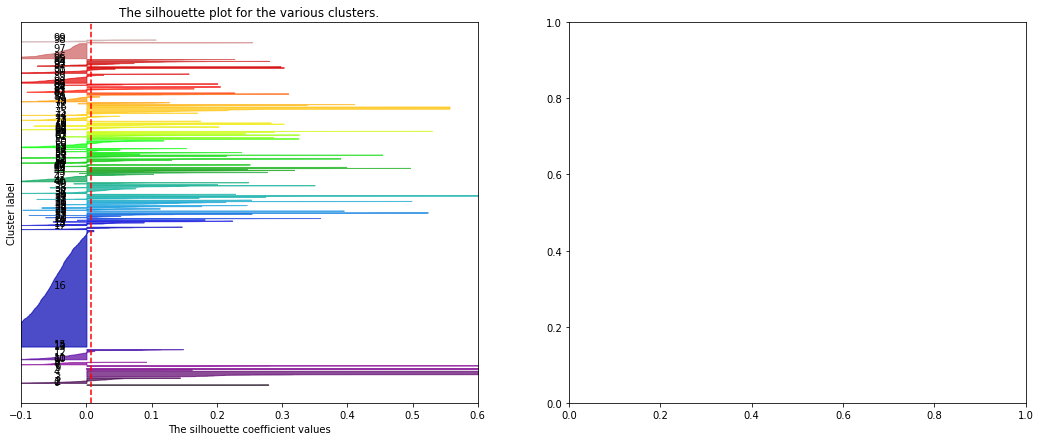

In [21]:
range_n_clusters = [2,3,4,5,10,20,30,40,60,80,100]
silhouette_scores(X_tfidf, range_n_clusters, KMeans,.6)

The code is a little backwards here. However, the silhouette plots / scores determined the number of clusters I used in the keyword cluster. The main motivation here was to cut down on the number of dimensions in my model by clustering keywords after using a tf-idf vectorizer on the all the keywords for a movie. This produced slightly better results than clustering based on keywords alone. 

In [18]:
from sklearn.decomposition import PCA

X_tfidf_pca = PCA(n_components=10).fit_transform(df_tfidf)
df_tfidf_keyword_pca = pd.DataFrame(X_tfidf_pca,index=df_tfidf.index)

In [19]:
# merge all separate items back into main df_tmdb dataframe, removing actor credits after clustering findings
# also removing production COMPANIES, will capture this information from bomojo with dstributor
df_tmdb_final = join_dataframes(df_tmdb,df_video,df_genre,df_prod_country,df_keyword_cluster,df_tfidf_keyword_pca)
df_tmdb_final['keyword_cluster'] = df_tmdb_final['keyword_cluster'].apply(str)
df_tmdb_final = df_tmdb_final.drop(['credits','id','imdb_id','genres','keywords','keyword','overview','revenue',
                                    'video_stats','production_companies','production_countries','tagline','title'],axis=1)

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


### Clustering box office mojo information

In [20]:
# filling in any gaps for release dates
df_release = df_bomojo[['release_date']].join(df_tmdb[['release_date']],lsuffix='_x',rsuffix='_y')
df_release['release_date'] = df_release['release_date_x'].fillna(df_release['release_date_y'])
df_bomojo = df_bomojo.join(df_release[['release_date']],rsuffix='_clean')

df_bomojo = df_bomojo.drop('ww_box_office',axis=1).dropna()
df_bomojo['week_number'] = df_bomojo.release_date_clean.dt.week
df_bomojo['week_number'] = pd.Categorical(df_bomojo.week_number)

In [23]:
x = df_bomojo.num_theaters
df_bomojo['scaled_num_theaters'] = (x - x.min())/(x.max() - x.min())
bomojo_cluster = df_bomojo[['genre', 'rating','distributor','week_number', 'scaled_num_theaters']]
bomojo_cluster = pd.get_dummies(bomojo_cluster)

For n_clusters = 2 The average silhouette_score is : 0.09659000149325278
For n_clusters = 3 The average silhouette_score is : 0.12512259637469592
For n_clusters = 4 The average silhouette_score is : 0.13255359962712093
For n_clusters = 5 The average silhouette_score is : 0.08916755404502466
For n_clusters = 6 The average silhouette_score is : 0.05837054649800027
For n_clusters = 7 The average silhouette_score is : 0.06541777931225153
For n_clusters = 8 The average silhouette_score is : 0.0701796156672103
For n_clusters = 9 The average silhouette_score is : 0.07333259662820484
For n_clusters = 10 The average silhouette_score is : 0.06530374785905062
For n_clusters = 20 The average silhouette_score is : 0.0959381412553019
For n_clusters = 30 The average silhouette_score is : 0.09586332213294783
For n_clusters = 100 The average silhouette_score is : 0.08004651469191405


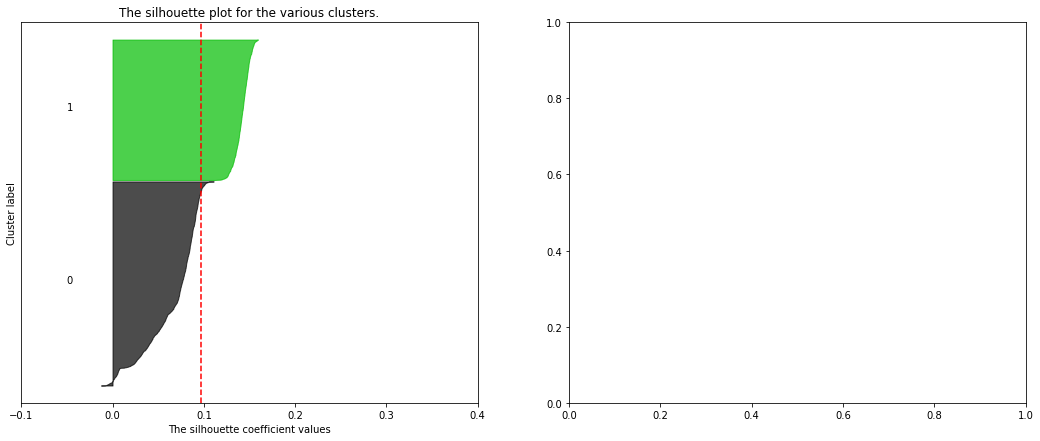

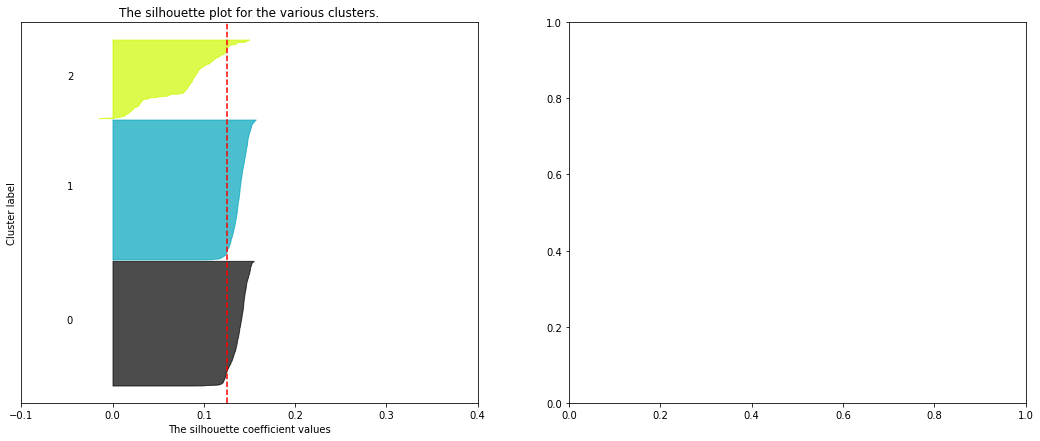

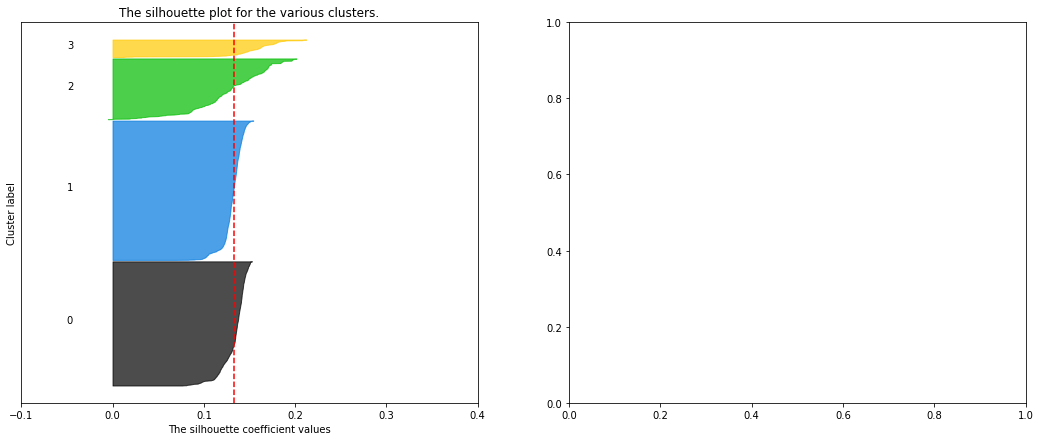

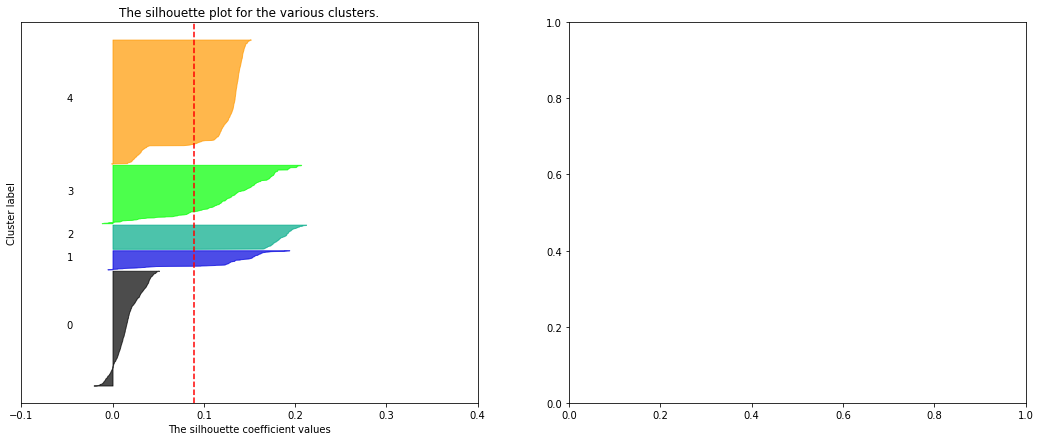

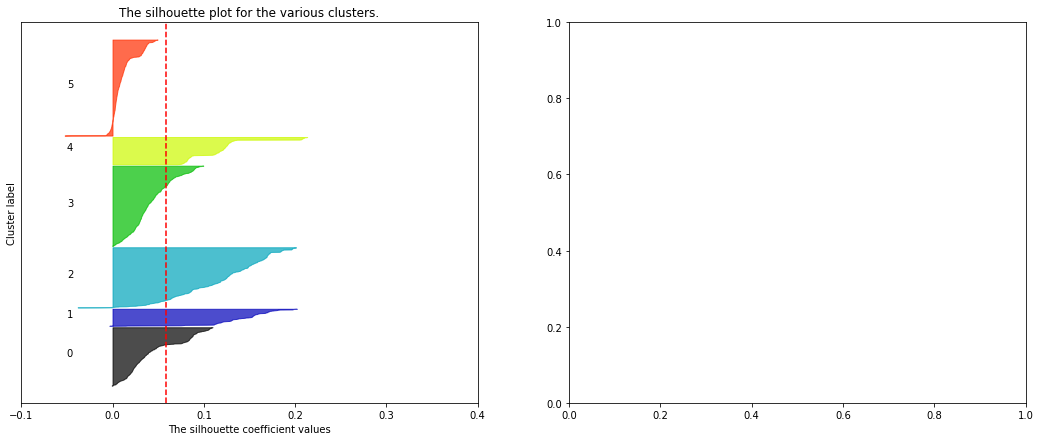

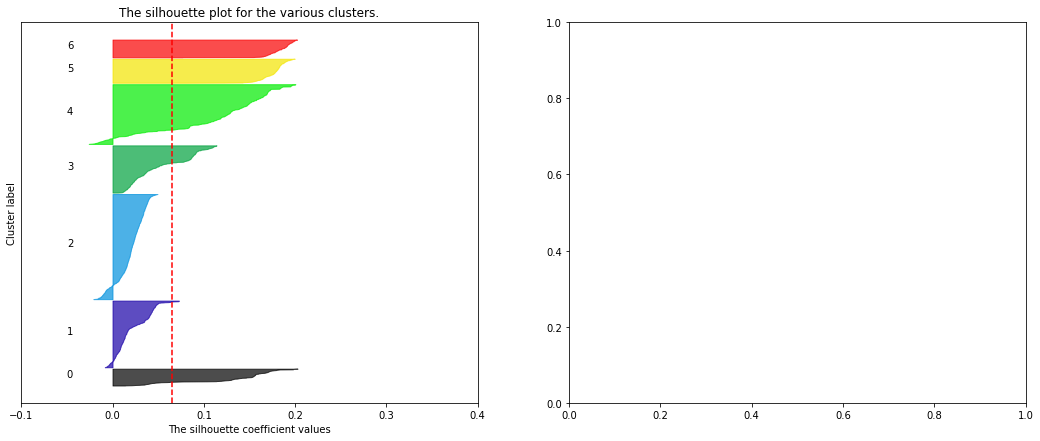

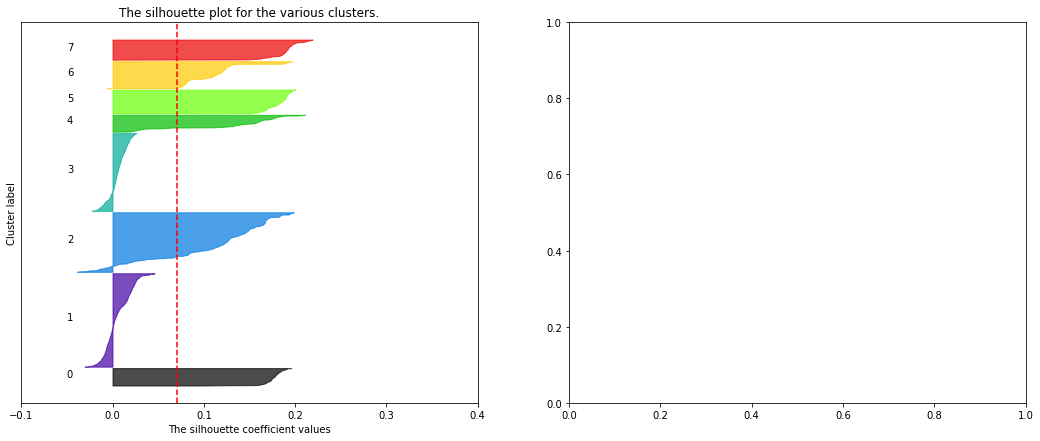

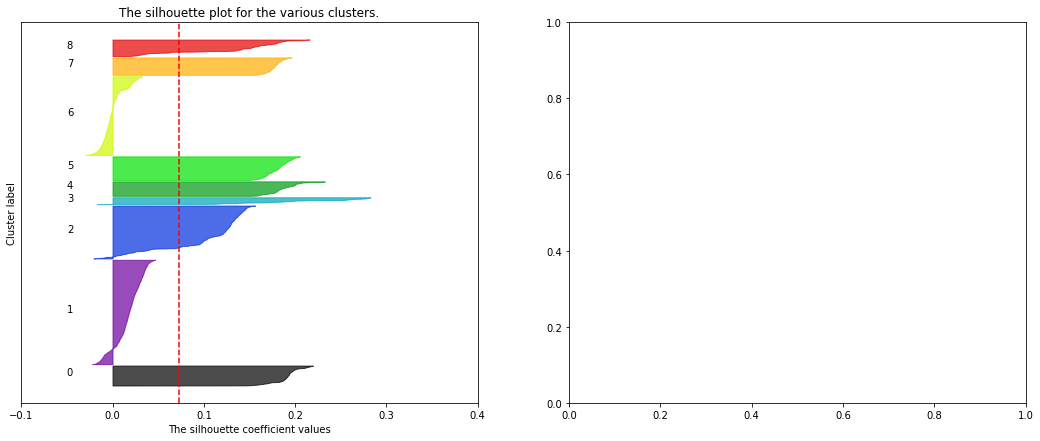

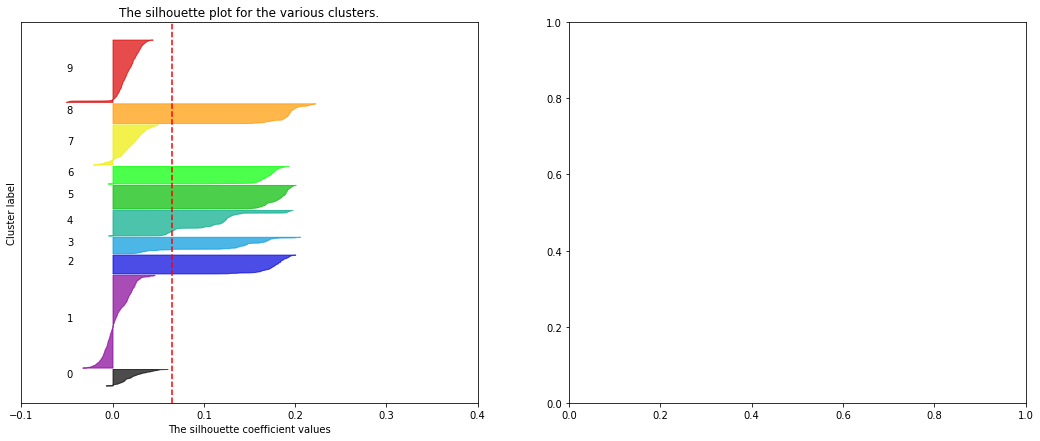

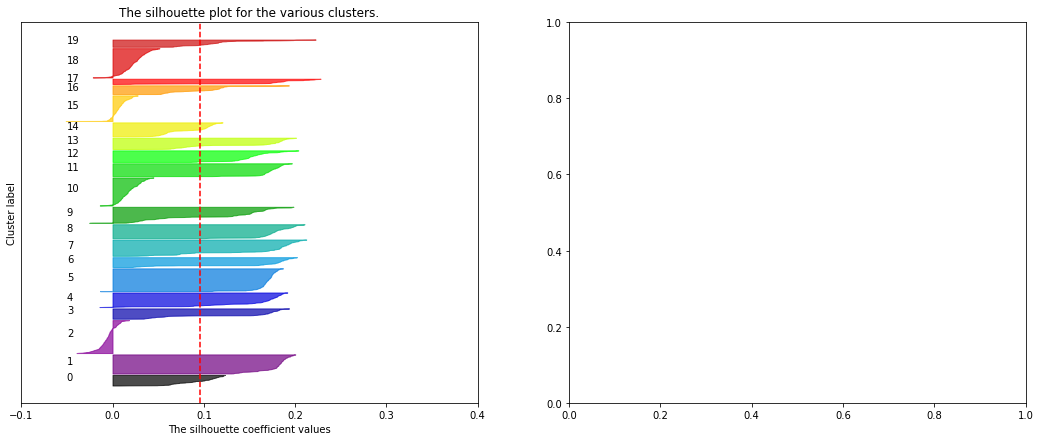

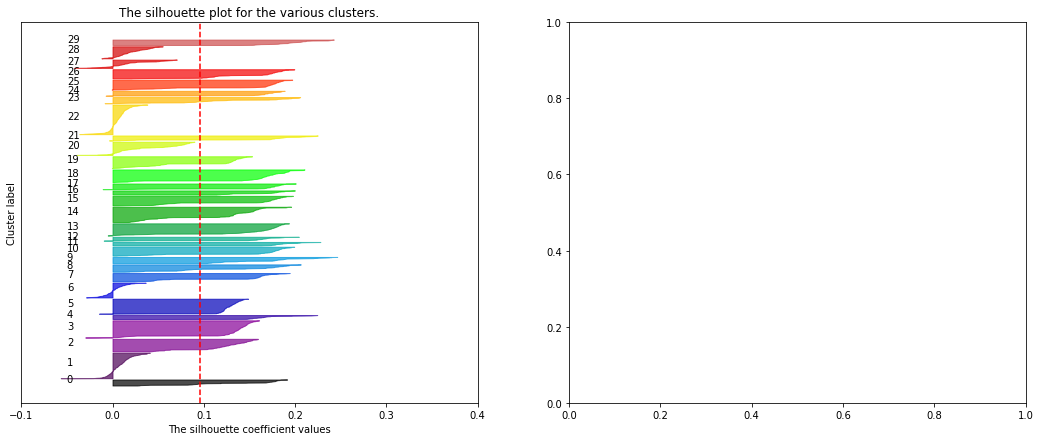

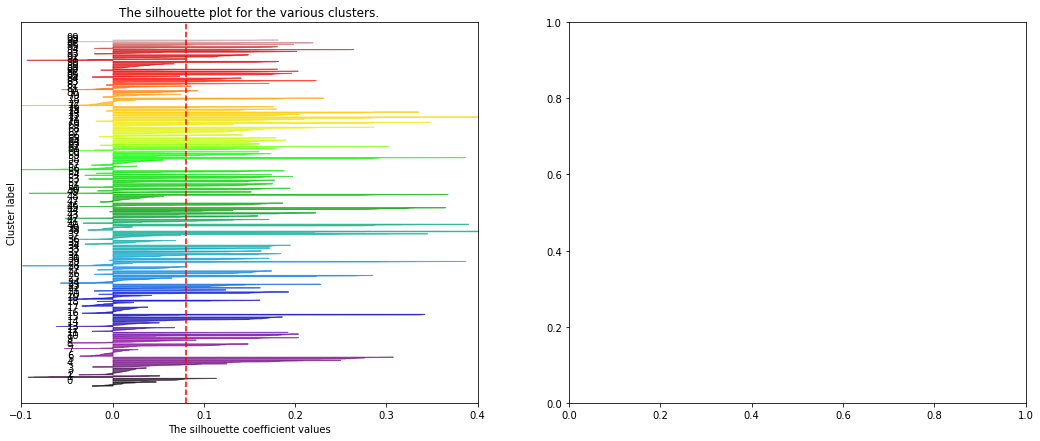

In [24]:
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,6,7,8,9,10,20,30,100]
silhouette_scores(bomojo_cluster, range_n_clusters, KMeans,.4)

Chose to go with 4 clusters because that definitely had the highest silhouette score and most distributed silhouette plot. I was getting much different results prior to scaling the number of theaters, which makes sense. The silhouette scores are much worse, because before the unscaled theater values were driving the relationship in the data. 

In [25]:
def scatter_graph(data, x, y, hue):
    plt.figure(figsize=(16,8))
    sns.scatterplot(x=x,y=y,hue=hue,data=data)
    plt.show()

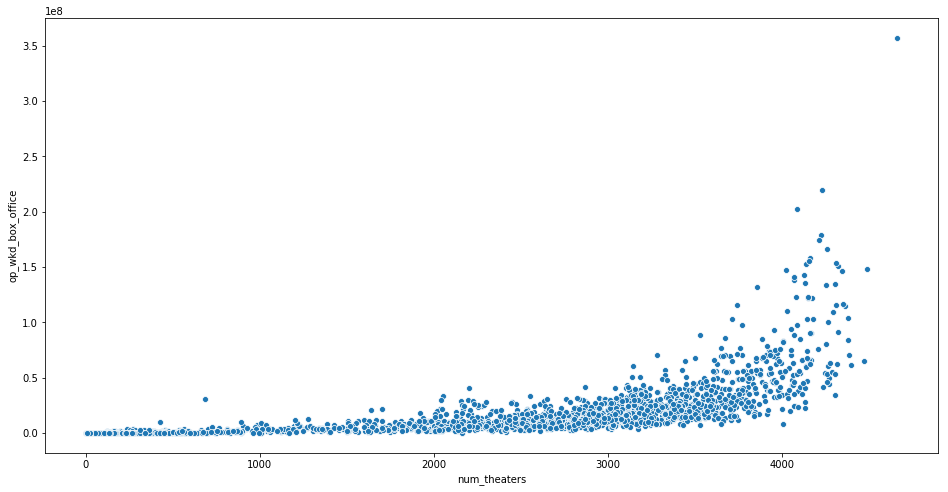

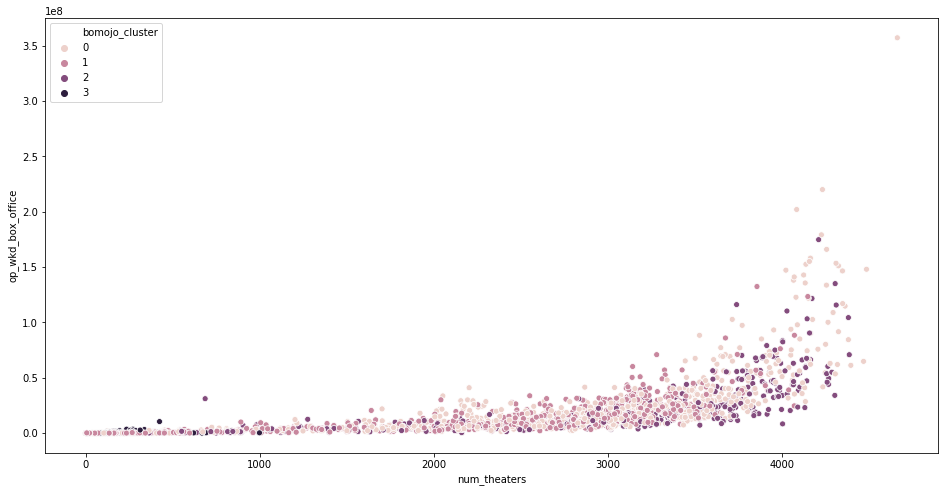

In [26]:
df_bomojo['bomojo_cluster'] =  KMeans(n_clusters=4, random_state=42).fit_predict(bomojo_cluster)
scatter_graph(df_bomojo,'num_theaters','op_wkd_box_office',None)
scatter_graph(df_bomojo,'num_theaters','op_wkd_box_office','bomojo_cluster')

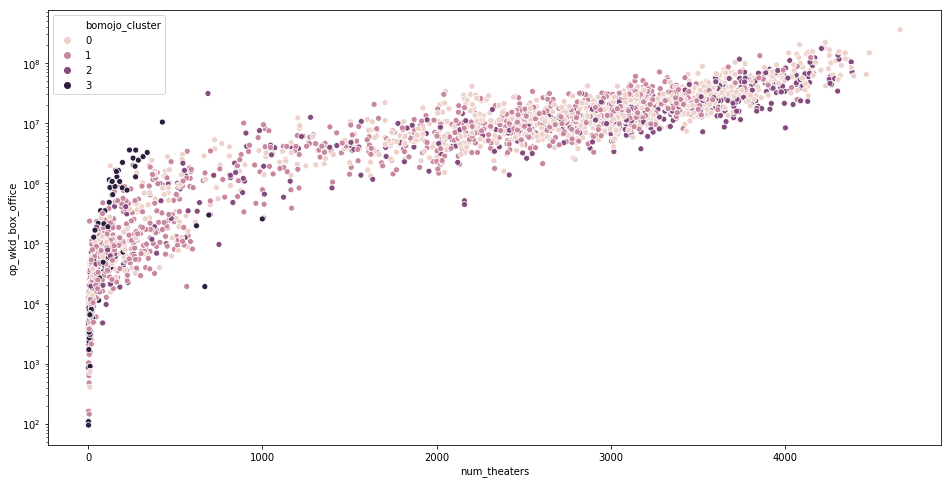

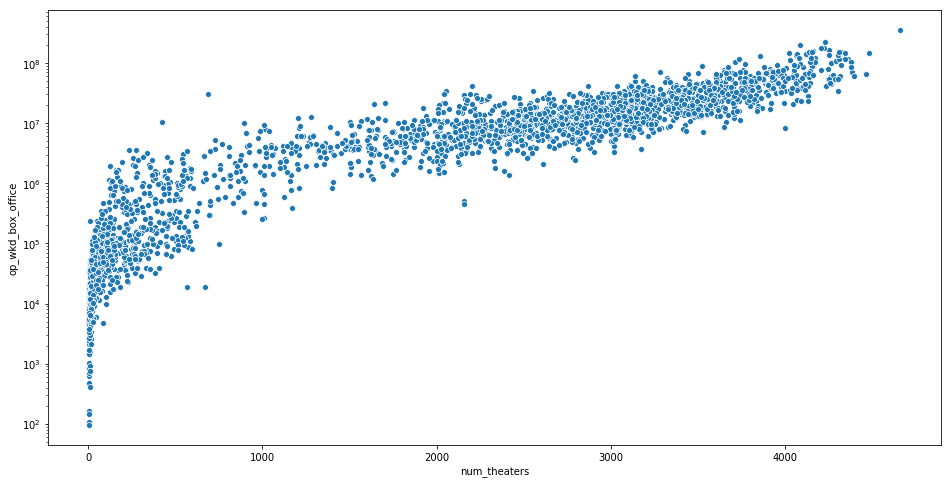

In [27]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='num_theaters',y='op_wkd_box_office',hue='bomojo_cluster',data=df_bomojo)
plt.yscale('log')
plt.show()
plt.figure(figsize=(16,8))
sns.scatterplot(x='num_theaters',y='op_wkd_box_office',data=df_bomojo)
plt.yscale('log')
plt.show()

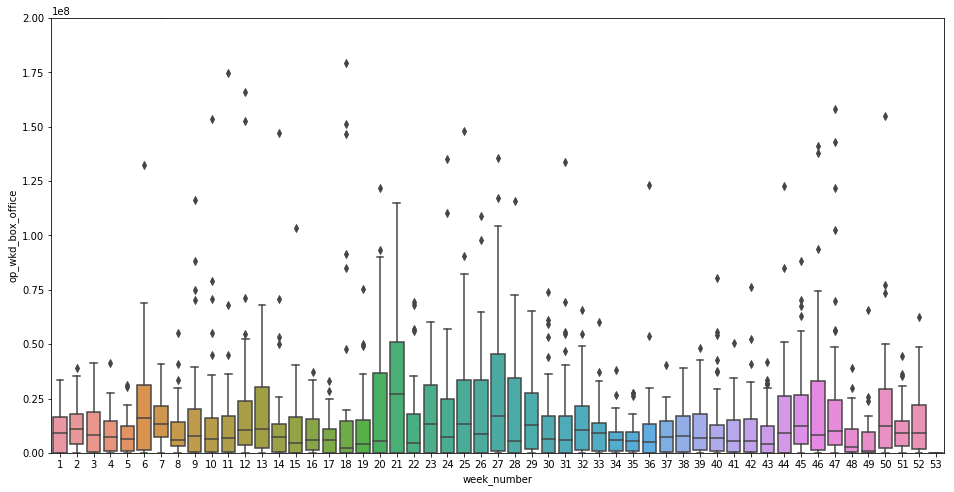

In [28]:
plt.figure(figsize=(16,8))
sns.boxplot(x='week_number',y='op_wkd_box_office',data=df_bomojo)
plt.ylim(0,2.0e8)
plt.savefig('pics/weeknumber_boxplot.png',dpi=100)

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


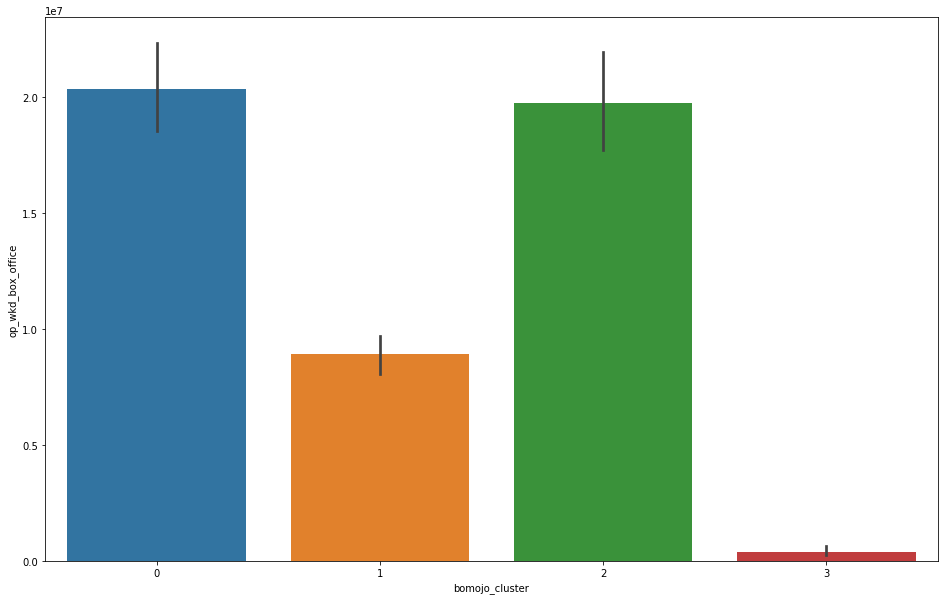

In [29]:
plt.figure(figsize=(16,10))
sns.barplot(x='bomojo_cluster',y='op_wkd_box_office',data=df_bomojo)
plt.show()

### Create wikipedia pageview features

In [31]:
from wikipedia import clean_pageviews

pageviews = []
for url, title in zip(df_wiki.index, df_wiki.clean_wiki_url):
    pageviews.append(clean_pageviews(df_wiki_pageviews, df_release, url, title))

df_pageviews = pd.DataFrame(pageviews).set_index('wiki_url')

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Finally, join all dataframe together on wiki_url index. Will drop the columns I don't need before modeling purposes. I would like to run two models for this analysis depending on if that's possible: 

1) WITH pageview features. This limits the number of films to only ~3-4 years worth, but I have more features

2) WITHOUT pageview features. This increases the number of films to 10+ years, but reduces the number of overall features

In [32]:
def join_dataframes_outer(df1, *others):
    new_df = df1
    for df in others:
        new_df = new_df.merge(df,left_index=True, right_index=True,how='outer') 
    return new_df

In [33]:
df_bo_predictor = join_dataframes_outer(df_tmdb_final,df_rt, df_mc, df_bomojo)
df_bo_predictor.to_csv('data/df_bo_predictor.csv',sep=',',index=True)

In [34]:
df_bo_predictor_wpv = join_dataframes_outer(df_tmdb_final,df_rt, df_mc, df_bomojo,df_pageviews)
df_bo_predictor_wpv.to_csv('data/df_bo_predictor_wpv.csv',sep=',',index=True)

In [35]:
for df in [df_tmdb_final,df_rt, df_mc, df_bomojo,df_pageviews]:
    print(df.shape)

(3035, 151)
(3545, 5)
(2994, 2)
(2593, 13)
(1343, 25)


In [40]:
# at some point, look to either scaling pageview data or using PCA for pageview data
# and run model with that versus clustering

### Final dataframe and visualizations
(Can bypass above if you have already saved final dataframe, read csv below)

In [110]:
df_bo_predictor = pd.read_csv('data/df_bo_predictor.csv', index_col='wiki_url')
df_bo_predictor_wpv = pd.read_csv('data/df_bo_predictor_wpv.csv', index_col='wiki_url')

In [111]:
df_bo_predictor.week_number = df_bo_predictor.week_number.apply(str)

In [112]:
# create additional metric to predict: film multiple which is the total film performance divided by
# its opening weekend performance
df_bo_predictor['film_multiple'] = df_bo_predictor.dom_box_office / df_bo_predictor.op_wkd_box_office
df_bo_predictor_wpv['film_multiple'] = df_bo_predictor_wpv.dom_box_office / df_bo_predictor_wpv.op_wkd_box_office

In [113]:
df_bo_predictor.head()

budget  popularity release_date_x  runtime  \
wiki_url                                                                       
/wiki/$9.99                          0.0       3.191     2008-09-04     78.0   
/wiki/%2771_(film)            11000000.0       8.884     2014-10-10     99.0   
/wiki/%C3%86on_Flux_(film)    62000000.0      13.100     2005-11-30     93.0   
/wiki/(500)_Days_of_Summer     7500000.0      14.378     2009-07-17     95.0   
/wiki/(Untitled)_(2009_film)         NaN         NaN            NaN      NaN   

                              vote_average  vote_count  \
wiki_url                                                 
/wiki/$9.99                            6.2        47.0   
/wiki/%2771_(film)                     6.8       623.0   
/wiki/%C3%86on_Flux_(film)             5.5      1095.0   
/wiki/(500)_Days_of_Summer             7.2      5551.0   
/wiki/(Untitled)_(2009_film)           NaN         NaN   

                              ('viewCount', 'count')  ('viewCount', 'min')  \
wiki_url                                                                     
/wiki/$9.99                                 0.000000              0.000032   
/wiki/%2771_(film)                          0.029412              0.000008   
/wiki/%C3%86on_Flux_(film)                  0.000000              0.015287   
/wiki/(500)_Days_of_Summer                  0.029412              0.001915   
/wiki/(Untitled)_(2009_film)                     NaN                   NaN   

                              ('viewCount', 'max')  ('viewCount', 'mean')  \
wiki_url                                                                    
/wiki/$9.99                               0.000001               0.000004   
/wiki/%2771_(film)                        0.000537               0.001228   
/wiki/%C3%86on_Flux_(film)                0.000562               0.002103   
/wiki/(500)_Days_of_Summer                0.000337               0.000908   
/wiki/(Untitled)_(2009_film)                   NaN                    NaN   

                                  ...        num_theaters  op_wkd_box_office  \
wiki_url                          ...                                          
/wiki/$9.99                       ...                 4.0              478.0   
/wiki/%2771_(film)                ...                 NaN                NaN   
/wiki/%C3%86on_Flux_(film)        ...              2608.0         12661112.0   
/wiki/(500)_Days_of_Summer        ...                 NaN                NaN   
/wiki/(Untitled)_(2009_film)      ...                 NaN                NaN   

                              rating  release_date_y      title  \
wiki_url                                                          
/wiki/$9.99                        R      2008-12-12      $9.99   
/wiki/%2771_(film)               NaN             NaN        NaN   
/wiki/%C3%86on_Flux_(film)     PG-13      2005-12-02  Aeon Flux   
/wiki/(500)_Days_of_Summer       NaN             NaN        NaN   
/wiki/(Untitled)_(2009_film)     NaN             NaN        NaN   

                              release_date_clean  week_number  \
wiki_url                                                        
/wiki/$9.99                           2008-12-12         50.0   
/wiki/%2771_(film)                           NaN          nan   
/wiki/%C3%86on_Flux_(film)            2005-12-02         48.0   
/wiki/(500)_Days_of_Summer                   NaN          nan   
/wiki/(Untitled)_(2009_film)                 NaN          nan   

                              scaled_num_theaters  bomojo_cluster  \
wiki_url                                                            
/wiki/$9.99                              0.000644             1.0   
/wiki/%2771_(film)                            NaN             NaN   
/wiki/%C3%86on_Flux_(film)               0.559322             0.0   
/wiki/(500)_Days_of_Summer                    NaN             NaN   
/wiki/(Untitled)_(2009_film)                  NaN             NaN   

        

In [114]:
df_bo_predictor.describe()

budget   popularity      runtime  vote_average    vote_count  \
count  3.035000e+03  3035.000000  3010.000000   3035.000000   3035.000000   
mean   3.462414e+07    11.554383   107.323588      6.249621   1557.286656   
std    5.002073e+07    15.087926    18.070785      1.075494   2460.790426   
min    0.000000e+00     0.600000    39.000000      0.000000      0.000000   
25%    0.000000e+00     6.422000    95.000000      5.800000    170.000000   
50%    1.500000e+07     8.815000   104.000000      6.300000    609.000000   
75%    4.300000e+07    12.949500   117.000000      6.900000   1812.500000   
max    5.000000e+08   473.246000   338.000000      8.600000  22016.000000   

       ('viewCount', 'count')  ('viewCount', 'min')  ('viewCount', 'max')  \
count             3035.000000           3035.000000           3035.000000   
mean                 0.014507              0.030055              0.003072   
std                  0.036892              0.069147              0.019105   
min                  0.000000              0.000000              0.000000   
25%                  0.000000              0.000769              0.000128   
50%                  0.000000              0.005217              0.000649   
75%                  0.014706              0.027381              0.002746   
max                  1.000000              1.000000              1.000000   

       ('viewCount', 'mean')  ('viewCount', 'median')      ...        \
count            3035.000000              3035.000000      ...         
mean                0.006675                 0.022654      ...         
std                 0.021922                 0.048565      ...         
min                 0.000000                 0.000000      ...         
25%                 0.000396                 0.001144      ...         
50%                 0.001880                 0.005731      ...         
75%                 0.007182                 0.024178      ...         
max                 1.000000                 1.000000      ...         

         aud_score  critic_counts  critic_score        score  dom_box_office  \
count  3545.000000    3545.000000   3545.000000  2562.000000    2.593000e+03   
mean      0.045698     129.335402     52.683780    55.166667    4.556431e+07   
std       1.725080      85.382796     28.935724    17.886032    7.108868e+07   
min       0.000000       0.000000      0.000000     1.000000    9.500000e+01   
25%       0.000000      61.000000     28.000000    42.000000    2.552478e+06   
50%       0.000000     124.000000     54.000000    55.000000    2.070645e+07   
75%       0.000000     183.000000     79.000000    68.000000    5.780695e+07   
max      85.000000     480.000000    100.000000   100.000000    9.366622e+08   

       num_theaters  op_wkd_box_office  scaled_num_theaters  bomojo_cluster  \
count   2593.000000       2.593000e+03          2593.000000     2593.000000   
mean    1982.741226       1.453943e+07             0.425175        0.917084   
std     1397.677566       2.279220e+07             0.299866        0.860029   
min        1.000000       9.500000e+01             0.000000        0.000000   
25%      311.000000       2.373930e+05             0.066509        0.000000   
50%     2417.000000       7.736452e+06             0.518344        1.000000   
75%     3127.000000       1.866786e+07             0.670672        1.000000   
max     4662.000000       3.571150e+08             1.000000        3.000000   

       film_multiple  
count    2593.000000  
mean        7.439581  
std        16.317860  
min         1.000000  
25%         2.339492  
50%         2.944662  
75%         4.284119  
max       311.364861  

[8 rows x 161 columns]

In [115]:
df_bo_predictor_wpv.describe()

budget   popularity      runtime  vote_average    vote_count  \
count  3.065000e+03  3065.000000  3040.000000   3065.000000   3065.000000   
mean   3.434755e+07    11.529459   107.353947      6.253246   1548.107667   
std    4.985592e+07    15.017424    18.075171      1.072279   2450.719952   
min    0.000000e+00     0.600000    39.000000      0.000000      0.000000   
25%    0.000000e+00     6.434000    95.000000      5.800000    171.000000   
50%    1.500000e+07     8.815000   104.000000      6.300000    607.000000   
75%    4.200000e+07    12.875000   117.000000      6.900000   1790.000000   
max    5.000000e+08   473.246000   338.000000      8.600000  22016.000000   

       ('viewCount', 'count')  ('viewCount', 'min')  ('viewCount', 'max')  \
count             3065.000000           3065.000000           3065.000000   
mean                 0.014509              0.030757              0.003082   
std                  0.036752              0.075247              0.019042   
min                  0.000000              0.000000              0.000000   
25%                  0.000000              0.000775              0.000124   
50%                  0.000000              0.005072              0.000643   
75%                  0.014706              0.027014              0.002715   
max                  1.000000              1.000000              1.000000   

       ('viewCount', 'mean')  ('viewCount', 'median')      ...        \
count            3065.000000              3065.000000      ...         
mean                0.006752                 0.022985      ...         
std                 0.022203                 0.051000      ...         
min                 0.000000                 0.000000      ...         
25%                 0.000387                 0.001130      ...         
50%                 0.001862                 0.005614      ...         
75%                 0.007075                 0.024039      ...         
max                 1.000000                 1.000000      ...         

       median_week_2  median_week_3  median_week_4   std_month_2  \
count     830.000000     815.000000     805.000000    798.000000   
mean     7766.522892    6166.869939    4311.509938   1942.936341   
std     11162.365888    8409.284345    6216.680790   4932.734303   
min         1.000000       1.000000       1.000000      1.113162   
25%      1223.750000     985.000000     846.000000    223.647374   
50%      4024.000000    3137.000000    2310.000000    654.265098   
75%      9907.750000    7894.000000    5310.000000   1887.852899   
max     99863.000000   70730.000000   71191.000000  94790.936194   

        std_month_3      std_total    std_week_2    std_week_3    std_week_4  \
count    756.000000    1335.000000    829.000000    813.000000    804.000000   
mean    1837.650578    4654.262688   1744.555771   1617.447685   1067.987390   
std     3725.583861   10831.979167   3616.978840   3102.930221   2179.803841   
min        0.000000       5.932502      1.140175      0.500000      0.447214   
25%      152.177541     442.245939    179.551160    160.644387    127.684255   
50%      459.411973    1582.192913    669.366829    638.366778    383.250116   
75%     1682.003048    4350.961668   1847.134783   1892.925765   1170.396857   
max    32605.131959  251133.215995  50322.902327  31181.424688  28051.790994   

       film_multiple  
count    2614.000000  
mean        7.477898  
std        16.294152  
min         1.000000  
25%         2.339468  
50%         2.944702  
75%         4.300391  
max       311.364861  

[8 rows x 186 columns]

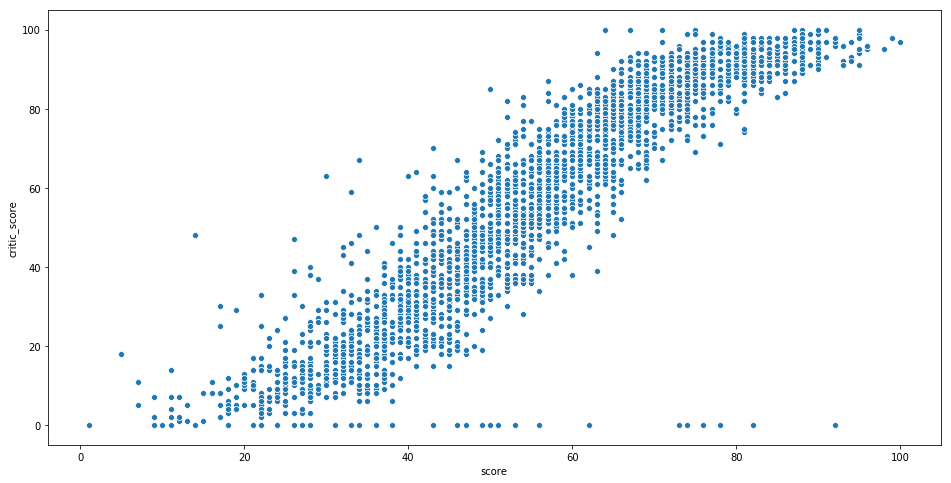

In [116]:
df_bo_predictor_graphna = df_bo_predictor.dropna(subset=['score','critic_score'],axis=0)
scatter_graph(df_bo_predictor_graphna,'score','critic_score',None)

In [117]:
df_bo_predictor_graphna[df_bo_predictor_graphna['critic_score'] == 0]['score']

wiki_url
/wiki/A_Thousand_Words_(film)                                     26.0
/wiki/About_Last_Night_(2014_film)                                62.0
/wiki/Acts_of_Violence                                            28.0
/wiki/After.Life                                                  36.0
/wiki/All_Eyez_on_Me_(film)                                       38.0
/wiki/Alone_in_the_Dark_(2005_film)                                9.0
/wiki/BloodRayne_(film)                                           18.0
/wiki/Bucky_Larson:_Born_to_Be_a_Star                              9.0
/wiki/Christmas_Eve_(2015_film)                                   24.0
/wiki/Dark_Phoenix_(film)                                         43.0
/wiki/District_13:_Ultimatum                                      53.0
/wiki/Eastern_Promises                                            82.0
/wiki/Future_World_(film)                                         10.0
/wiki/Gotti_(2018_film)                                           24

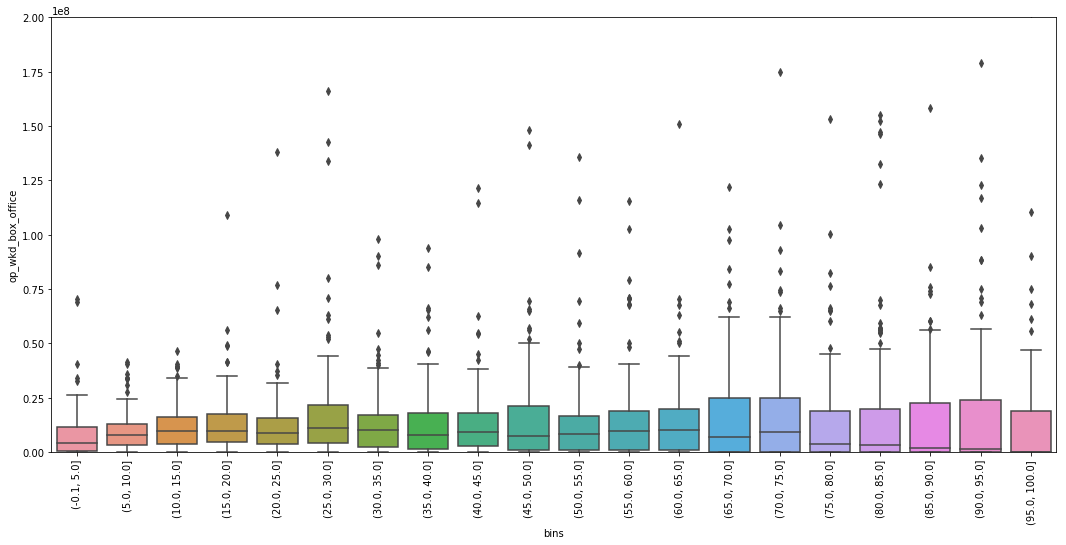

In [118]:
df_bin_temp = df_bo_predictor
df_bin_temp['bins'] = pd.cut(df_bin_temp.critic_score,20,include_lowest=False)

plt.figure(figsize=(18,8))
sns.boxplot(x='bins',y='op_wkd_box_office',data=df_bin_temp)
plt.xticks(rotation=90)
plt.ylim(0,2e8)
plt.show()

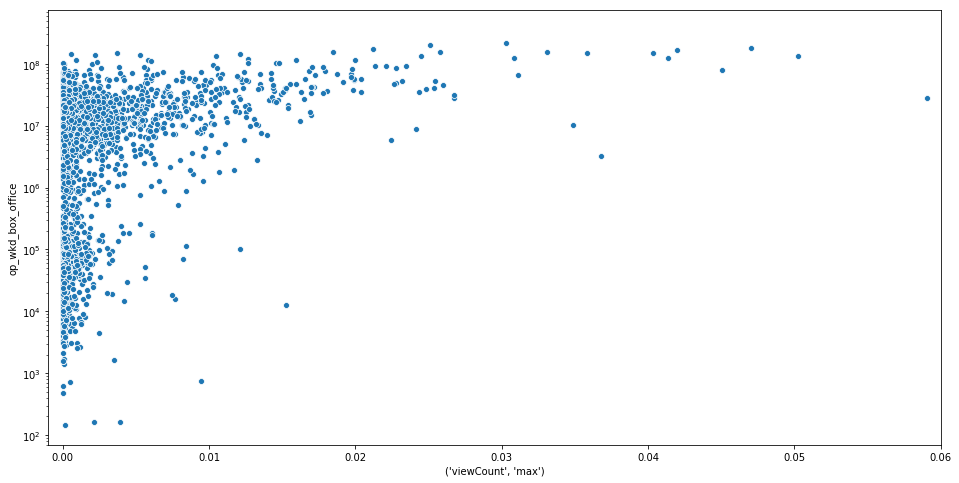

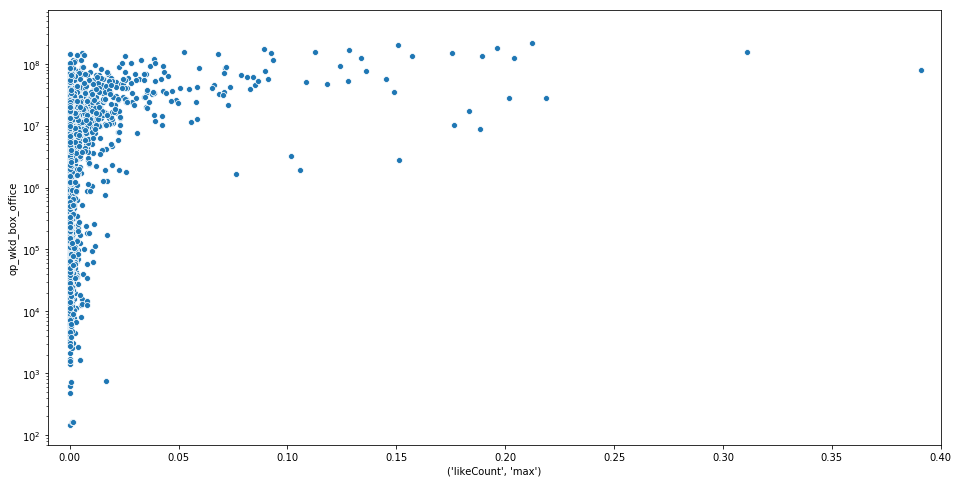

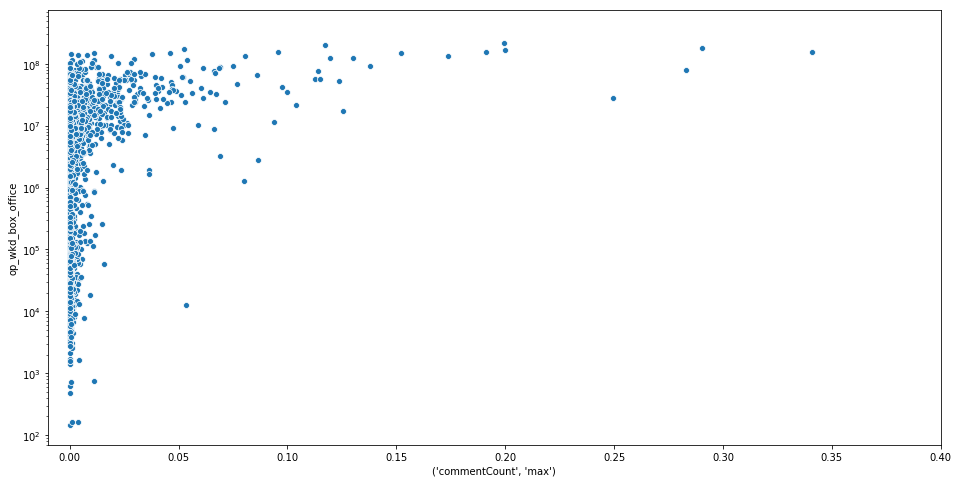

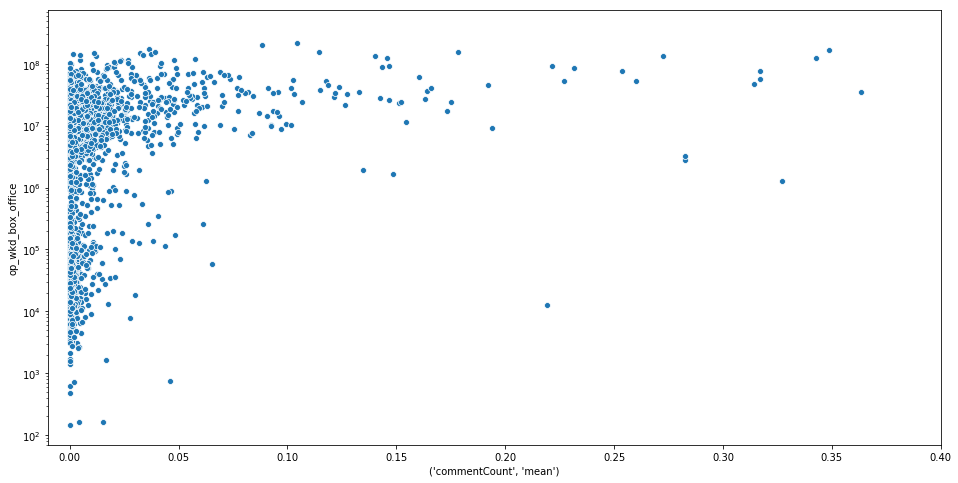

In [119]:
plt.figure(figsize=(16,8))
sns.scatterplot(x="('viewCount', 'max')",y='op_wkd_box_office',data=df_bo_predictor)
plt.xlim(-0.001,.06)
plt.yscale('log')
plt.show()
plt.figure(figsize=(16,8))
sns.scatterplot(x="('likeCount', 'max')",y='op_wkd_box_office',data=df_bo_predictor)
plt.xlim(-0.01,0.4)
plt.yscale('log')
plt.show()
plt.figure(figsize=(16,8))
sns.scatterplot(x="('commentCount', 'max')",y='op_wkd_box_office',data=df_bo_predictor)
plt.xlim(-0.01,0.4)
plt.yscale('log')
plt.show()
plt.figure(figsize=(16,8))
sns.scatterplot(x="('commentCount', 'mean')",y='op_wkd_box_office',data=df_bo_predictor)
plt.xlim(-0.01,0.4)
plt.yscale('log')
plt.show()

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


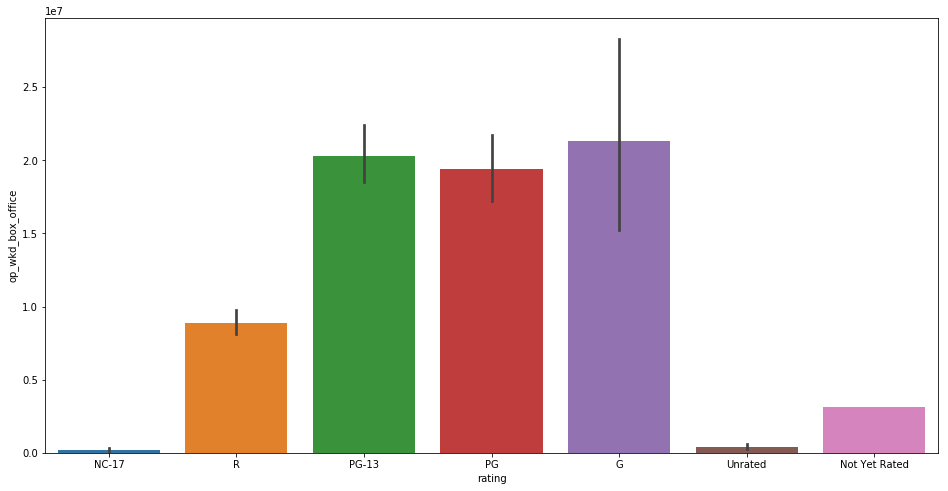

In [120]:
order = ['NC-17','R','PG-13','PG','G','Unrated','Not Yet Rated']
plt.figure(figsize=(16,8))
sns.barplot(x='rating',y='op_wkd_box_office',order=order,data=df_bo_predictor)
plt.show()

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


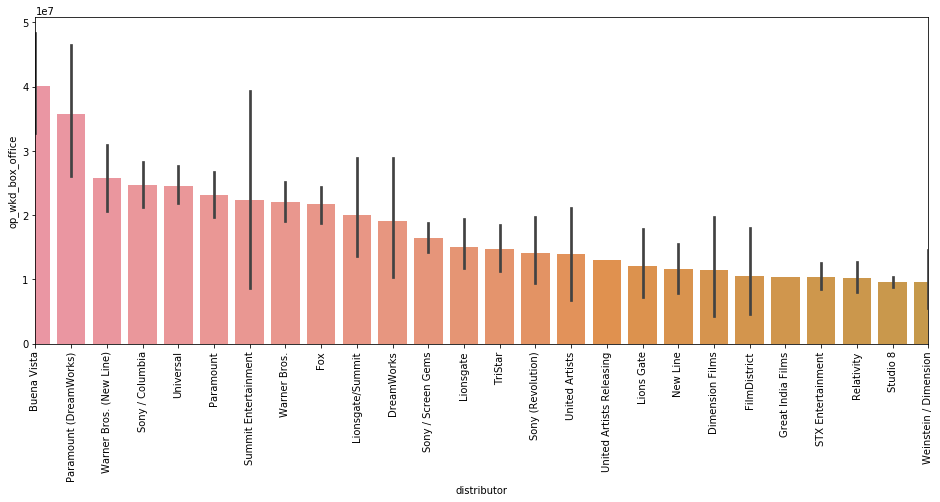

In [243]:
order = df_bo_predictor[['distributor','op_wkd_box_office']].groupby(by='distributor').mean().sort_values(by='op_wkd_box_office',ascending=False)

plt.figure(figsize=(16,6))
sns.barplot(x='distributor',y='op_wkd_box_office',data=df_bo_predictor,order=order.index)
plt.xlim(0,25)
plt.xticks(rotation=90)
plt.show()

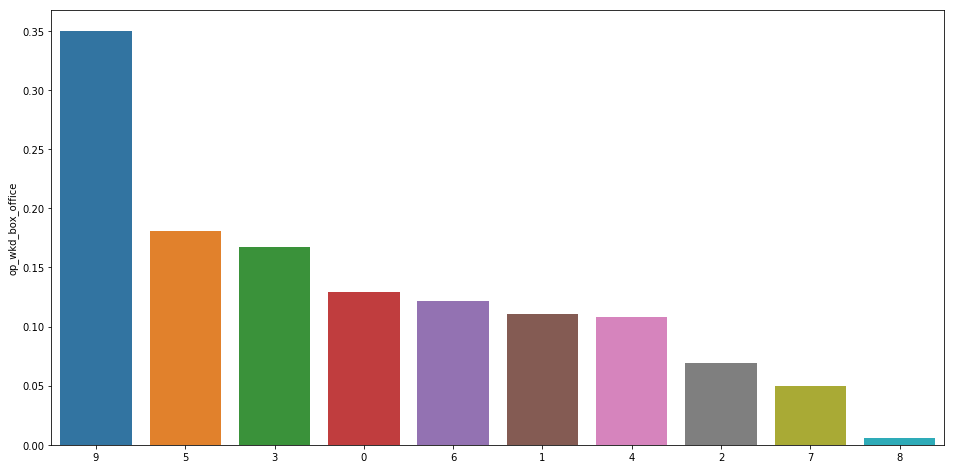

In [122]:
df_pca_corr = df_bo_predictor[['0','1','2','3','4','5','6','7','8','9','op_wkd_box_office']]
df_pca_corr = df_pca_corr.corr()
df_pca_corr = df_pca_corr[['op_wkd_box_office']].abs().sort_values(by='op_wkd_box_office',ascending=False)

plt.figure(figsize=(16,8))
sns.barplot(x=df_pca_corr.index[1:],y=df_pca_corr.op_wkd_box_office[1:], order=df_pca_corr.index[1:])
plt.show()

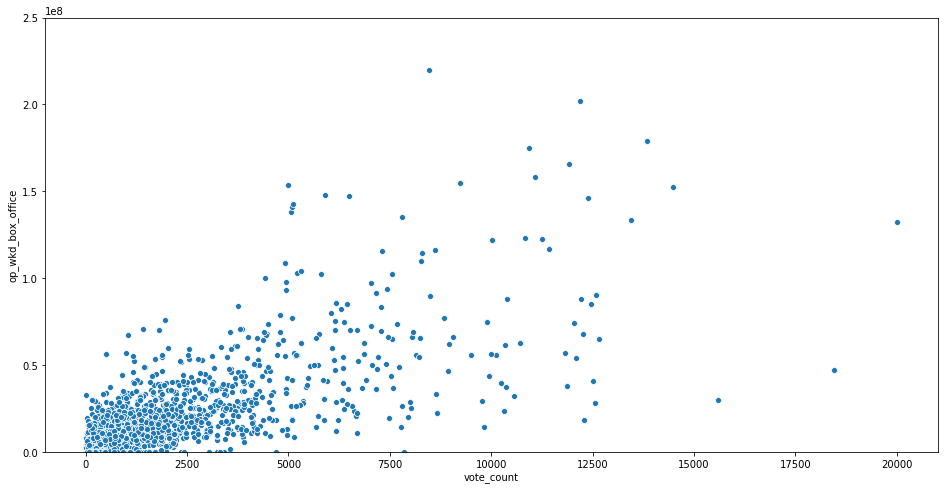

In [200]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='vote_count',y='op_wkd_box_office',data=df_bo_predictor)
plt.ylim(0,2.5e8)
plt.show()

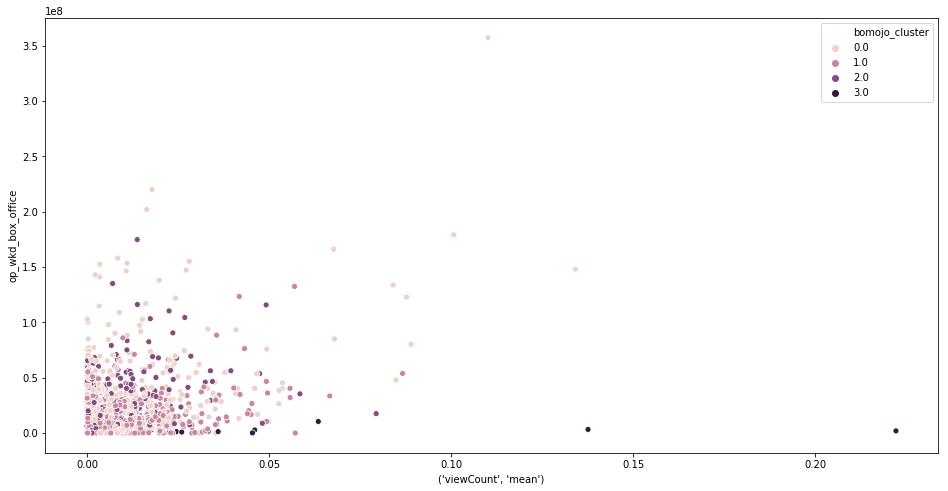

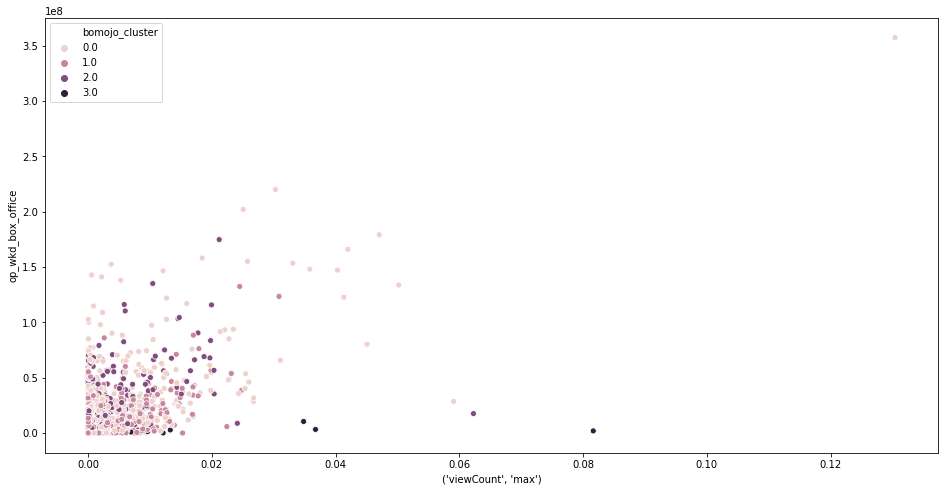

In [123]:
scatter_graph(df_bo_predictor,"('viewCount', 'mean')",'op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,"('viewCount', 'max')",'op_wkd_box_office','bomojo_cluster')

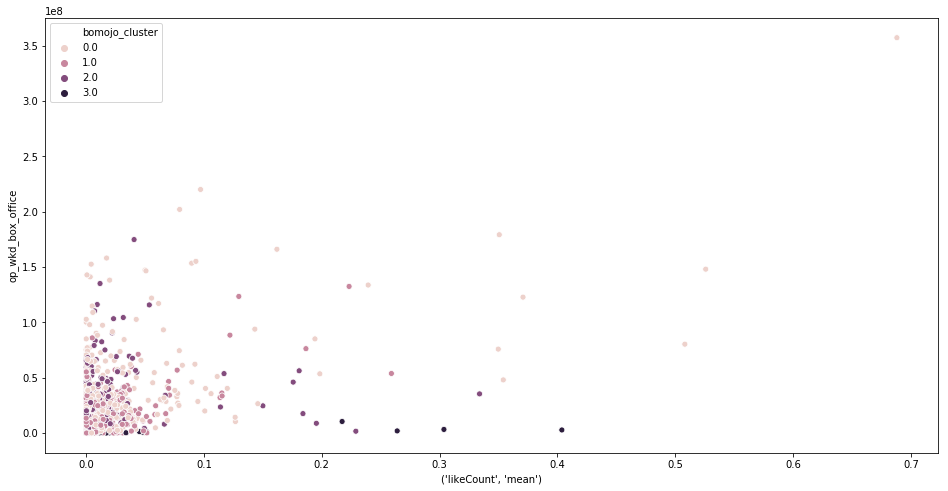

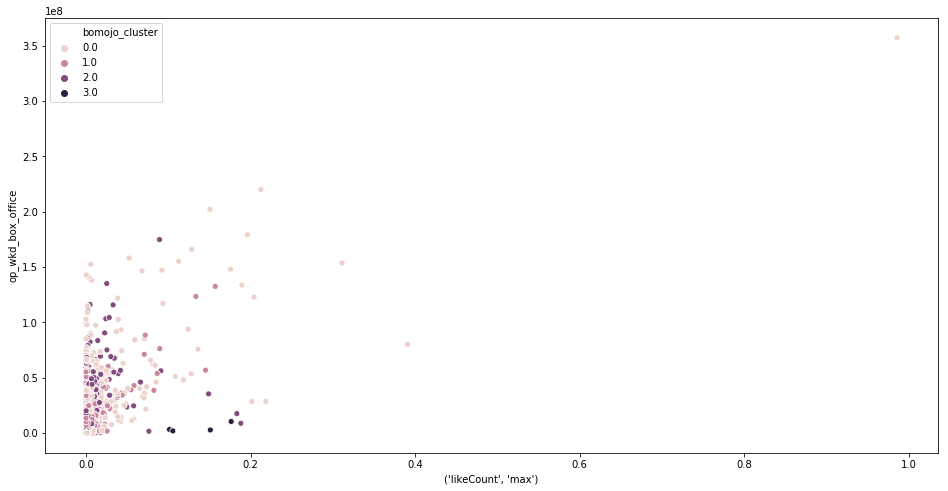

In [124]:
scatter_graph(df_bo_predictor,"('likeCount', 'mean')",'op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,"('likeCount', 'max')",'op_wkd_box_office','bomojo_cluster')

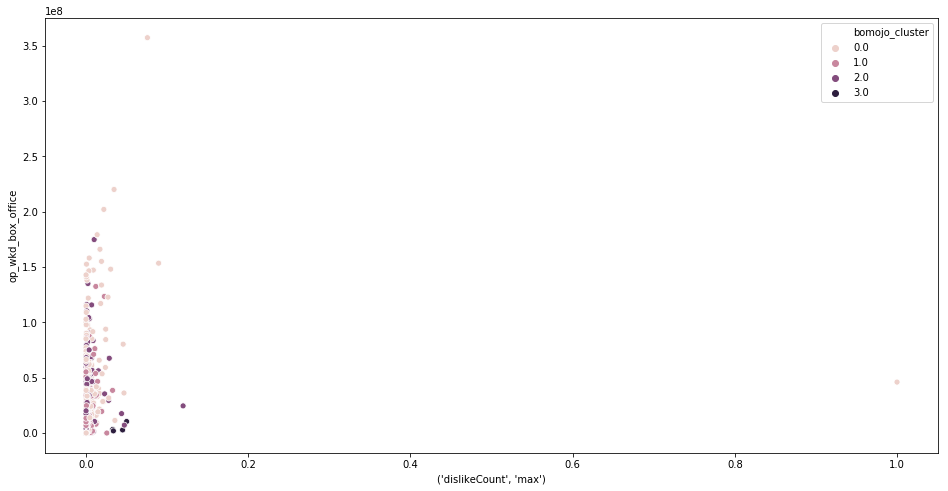

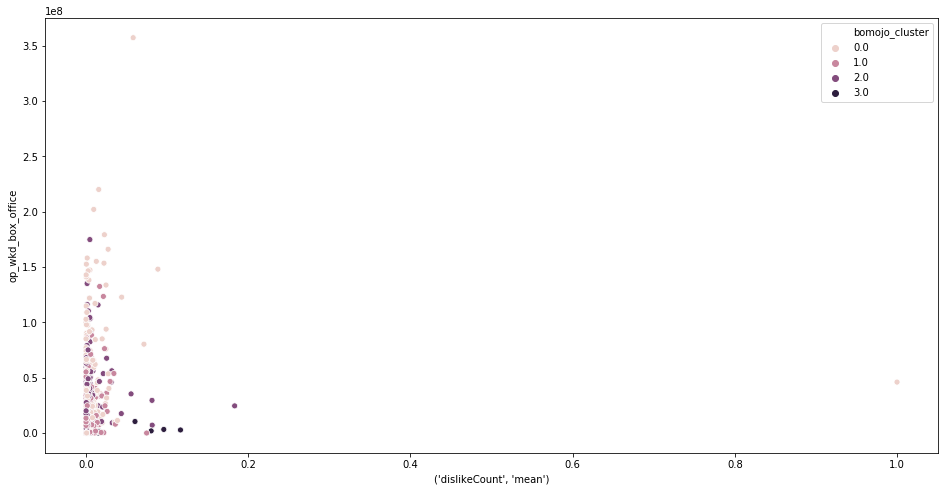

In [125]:
scatter_graph(df_bo_predictor,"('dislikeCount', 'max')",'op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,"('dislikeCount', 'mean')",'op_wkd_box_office','bomojo_cluster')

### The most disliked movies according to Youtube trailers

In [126]:
df_bo_predictor[df_bo_predictor["('dislikeCount', 'max')"] > .03]["('dislikeCount', 'max')"].sort_values(ascending=False)

wiki_url
/wiki/Ghostbusters_(2016_film)                      1.000000
/wiki/Frozen_(2013_film)                            0.669517
/wiki/The_Emoji_Movie                               0.119720
/wiki/Aladdin_(2019_film)                           0.097172
/wiki/Captain_Marvel_(film)                         0.089550
/wiki/Vedalam                                       0.081685
/wiki/Avengers:_Infinity_War                        0.075729
/wiki/Star_Wars:_The_Rise_of_Skywalker              0.066691
/wiki/Dora_and_the_Lost_City_of_Gold                0.066418
/wiki/Pok%C3%A9mon_Detective_Pikachu                0.061981
/wiki/Ocean%27s_8                                   0.057109
/wiki/Terminator:_Dark_Fate                         0.050372
/wiki/Baahubali_2:_The_Conclusion                   0.050116
/wiki/Avengers:_Endgame                             0.049381
/wiki/Diary_of_a_Wimpy_Kid:_The_Long_Haul_(film)    0.047270
/wiki/Jumanji:_Welcome_to_the_Jungle                0.046838
/wiki/Venom_(20

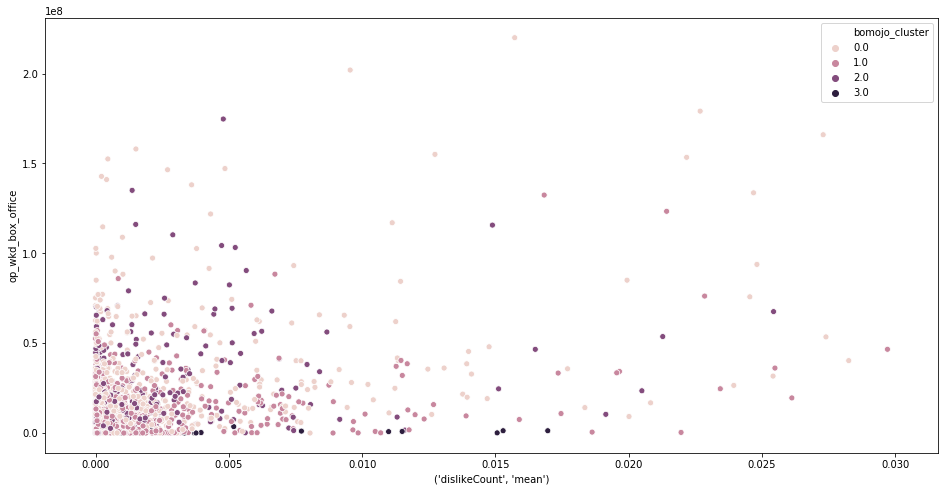

In [127]:
df_graph_test = df_bo_predictor[df_bo_predictor["('dislikeCount', 'mean')"] < .03]
scatter_graph(df_graph_test,"('dislikeCount', 'mean')",'op_wkd_box_office','bomojo_cluster')

In [128]:
# look at RT and MC scores related to tmdb scores
# RT and MC scores together to see if they're redundant, variance thresholds versus correlation thresholds

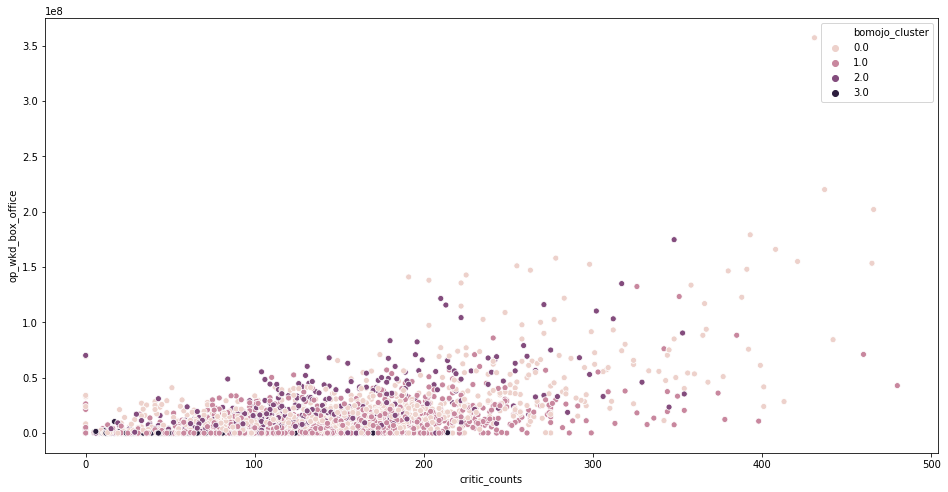

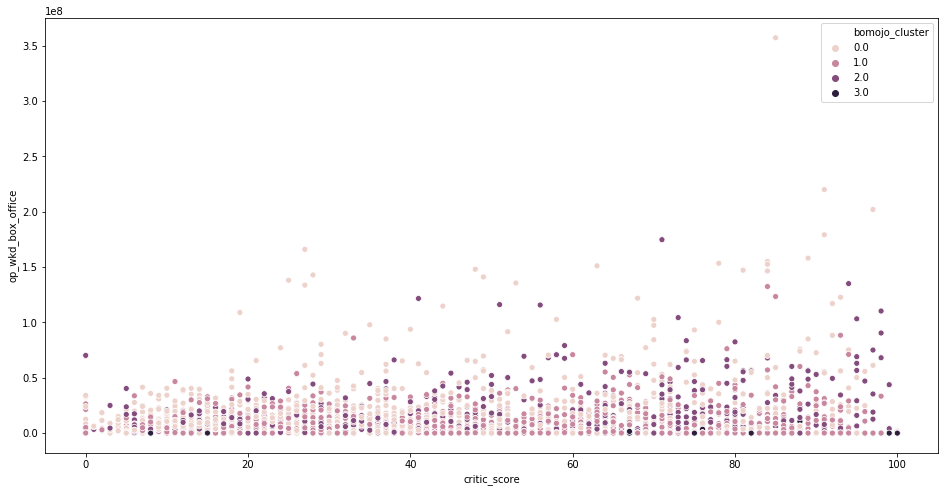

In [129]:
scatter_graph(df_bo_predictor,'critic_counts','op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,'critic_score','op_wkd_box_office','bomojo_cluster')

Unfortunately, the RottenTomatoes website changed during the time in which I was scraping the website and running this model so when re-running the scraping process to account for 10+ years, I lost all of the audience score and counts. In future iterations I will need to fix this bug. However, for the time being, the popularity component I am capturing from RottenTomatoes is still preserved in the critic scores, i.e. more popular movies that are likely to receive more box office or commercial success have more critic reviews.

RottenTomatoes audience and critic counts a way better relationship with opening weekend box office than score.

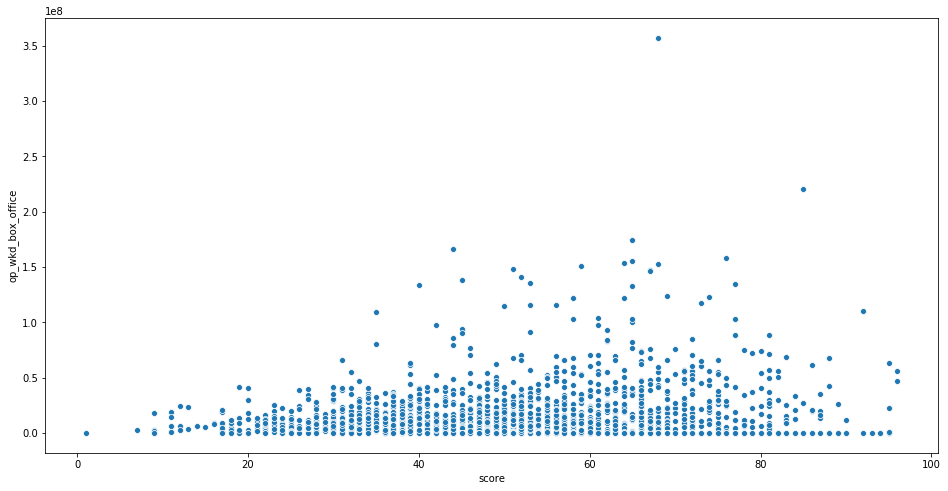

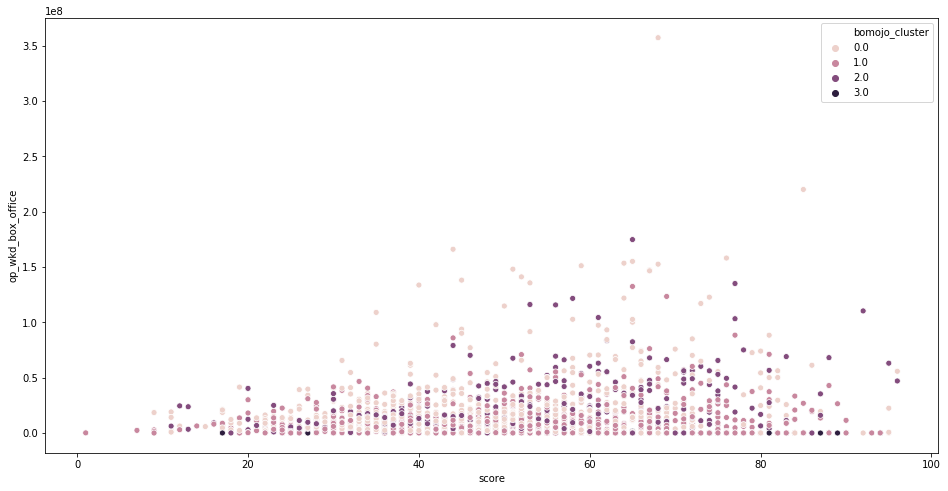

In [130]:
# mc score just like RT score doesn't seem as relevant
scatter_graph(df_bo_predictor,'score','op_wkd_box_office',None)
scatter_graph(df_bo_predictor,'score','op_wkd_box_office','bomojo_cluster')

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


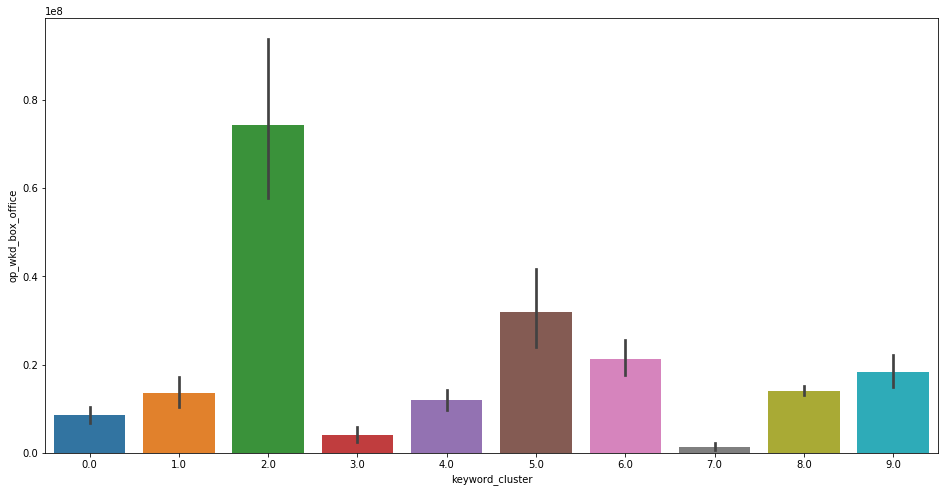

In [131]:
plt.figure(figsize=(16,8))
sns.barplot(x='keyword_cluster',y='op_wkd_box_office',data=df_bo_predictor)
plt.show()

### A quick look at film multiples

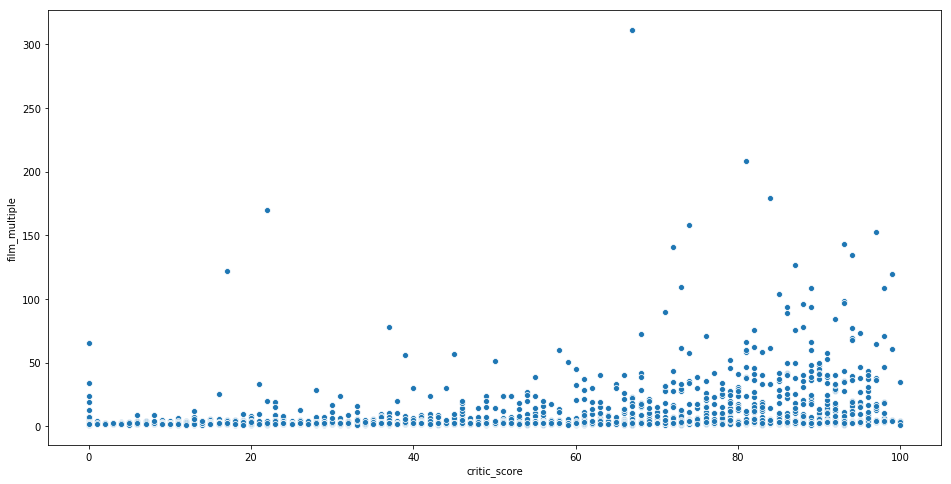

In [132]:
scatter_graph(df_bo_predictor,'critic_score','film_multiple',hue=None)

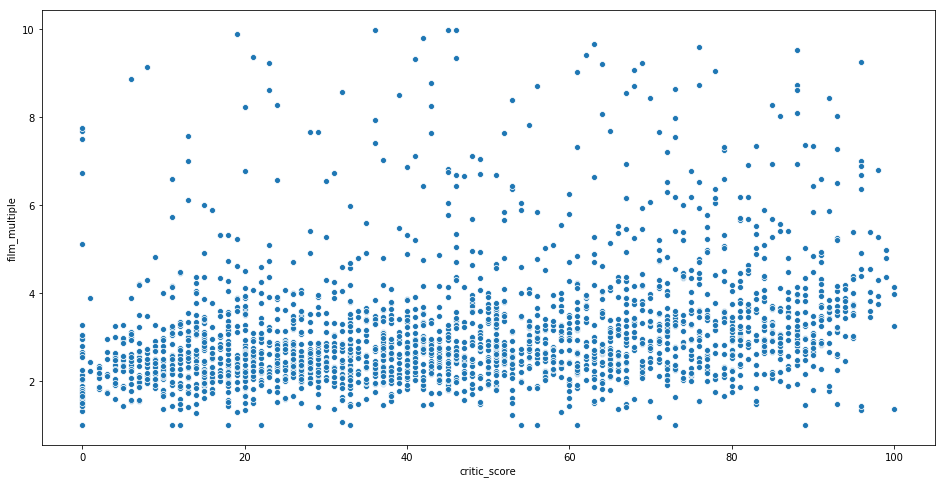

In [133]:
df_temp = df_bo_predictor[df_bo_predictor['film_multiple'] < 10]
scatter_graph(df_temp,'critic_score','film_multiple',None)

In [134]:
# scatterplot difficult to assess when overlapping points
# look at a density plot
# hist2D to discuss density and or hexbins  roundness in data
def hist2d_graph(x, y):
    plt.figure(figsize=(16,8))
    plt.hexbin(x=x,y=y,gridsize=(30,10))
    plt.show()

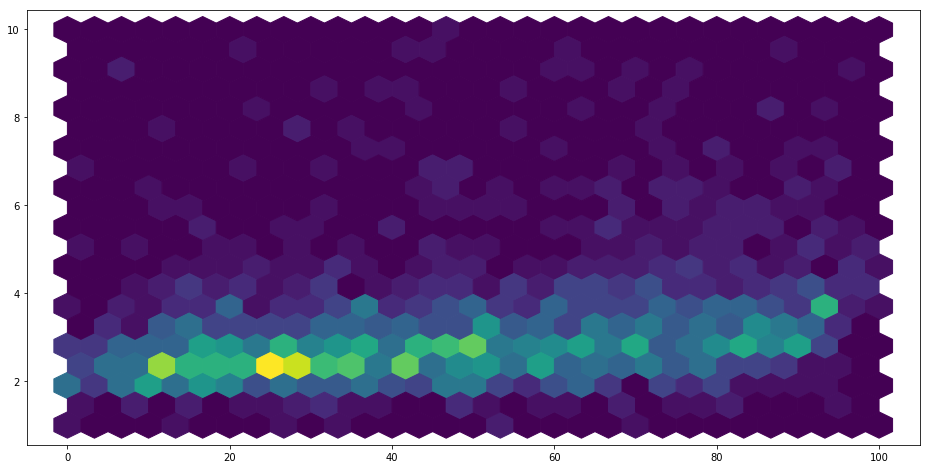

In [135]:
df_temp_temp = df_temp.dropna()
hist2d_graph(df_temp_temp['critic_score'],df_temp_temp['film_multiple'])

In [136]:
len(df_temp.critic_counts)

2235

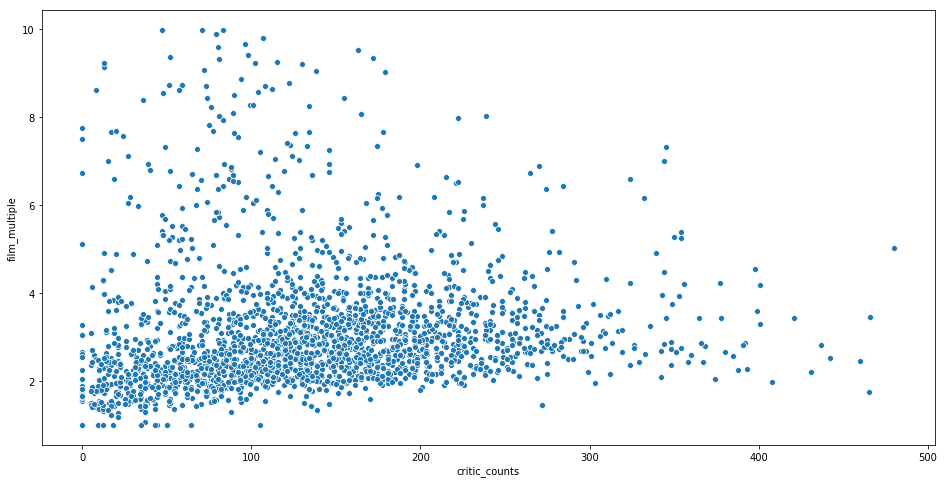

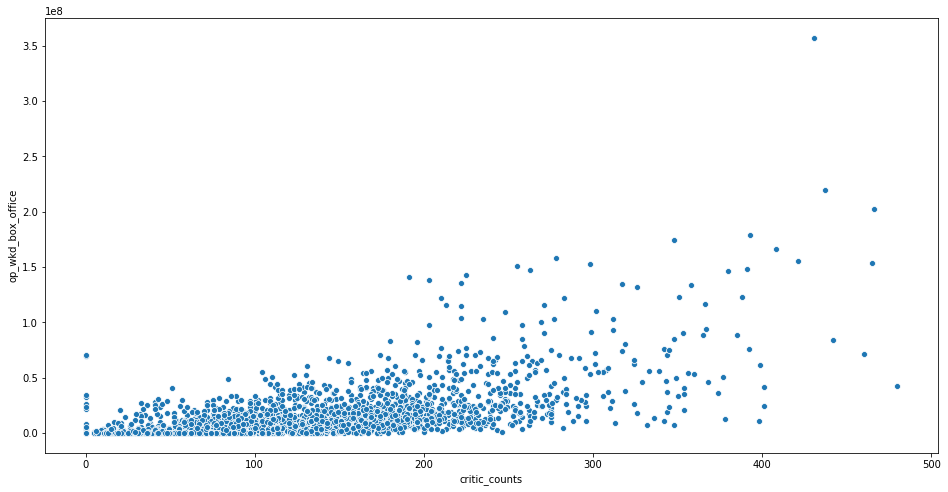

In [137]:
scatter_graph(df_temp,'critic_counts','film_multiple',None)
scatter_graph(df_temp,'critic_counts','op_wkd_box_office',None)

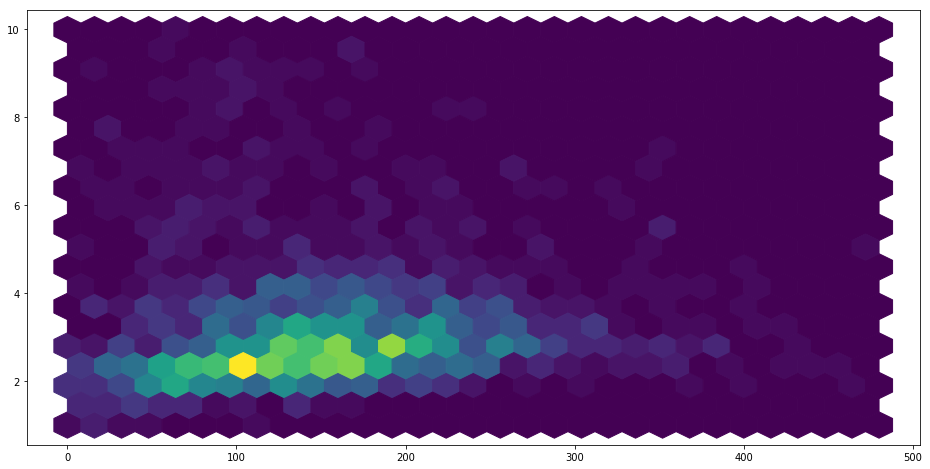

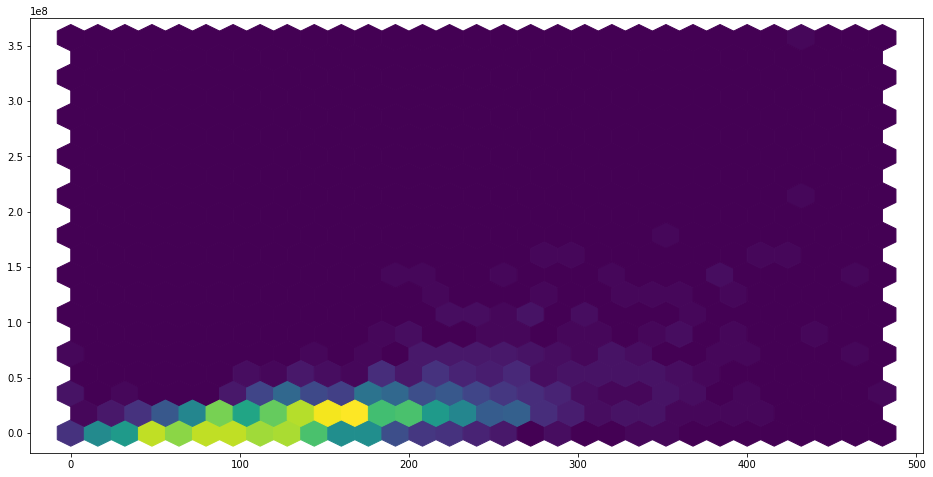

In [138]:
# add a regression line and see where the slope goes through the cloud
# change color map for hexbin to white, or spread blue to edges
hist2d_graph(df_temp_temp['critic_counts'],df_temp_temp['film_multiple'])
hist2d_graph(df_temp_temp['critic_counts'],df_temp_temp['op_wkd_box_office'])

In [139]:
df_temp_temp[['critic_counts','critic_score','film_multiple','op_wkd_box_office','dom_box_office']].corr()

critic_counts  critic_score  film_multiple  \
critic_counts           1.000000      0.479780       0.073978   
critic_score            0.479780      1.000000       0.267462   
film_multiple           0.073978      0.267462       1.000000   
op_wkd_box_office       0.594041      0.221085      -0.033400   
dom_box_office          0.612082      0.288238       0.126933   

                   op_wkd_box_office  dom_box_office  
critic_counts               0.594041        0.612082  
critic_score                0.221085        0.288238  
film_multiple              -0.033400        0.126933  
op_wkd_box_office           1.000000        0.947549  
dom_box_office              0.947549        1.000000

In [140]:
df_temp_temp[['num_theaters','film_multiple','op_wkd_box_office','dom_box_office']].corr()

num_theaters  film_multiple  op_wkd_box_office  \
num_theaters           1.000000      -0.098778           0.600727   
film_multiple         -0.098778       1.000000          -0.033400   
op_wkd_box_office      0.600727      -0.033400           1.000000   
dom_box_office         0.627560       0.126933           0.947549   

                   dom_box_office  
num_theaters             0.627560  
film_multiple            0.126933  
op_wkd_box_office        0.947549  
dom_box_office           1.000000

In [141]:
# add in correlation for wiki pageviews and trailer views
df_temp_temp[["('viewCount', 'max')","('likeCount', 'max')","('dislikeCount', 'max')","('commentCount', 'max')"]].corr()

('viewCount', 'max')  ('likeCount', 'max')  \
('viewCount', 'max')                 1.000000              0.853416   
('likeCount', 'max')                 0.853416              1.000000   
('dislikeCount', 'max')              0.234329              0.205184   
('commentCount', 'max')              0.788339              0.903323   

                         ('dislikeCount', 'max')  ('commentCount', 'max')  
('viewCount', 'max')                    0.234329                 0.788339  
('likeCount', 'max')                    0.205184                 0.903323  
('dislikeCount', 'max')                 1.000000                 0.532026  
('commentCount', 'max')                 0.532026                 1.000000

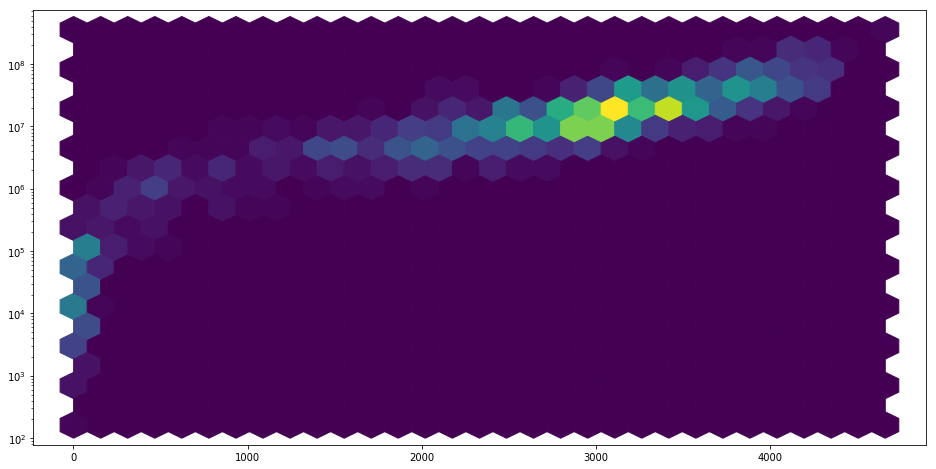

In [142]:
plt.figure(figsize=(16,8))
plt.hexbin(df_temp_temp['num_theaters'],df_temp_temp['op_wkd_box_office'],gridsize=(30,10),yscale='log')
plt.show()

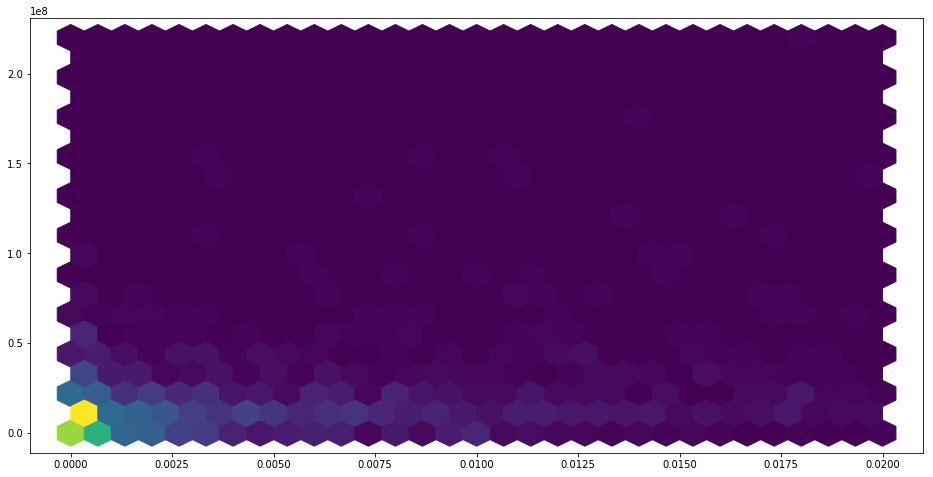

In [143]:
df_temp_temp_temp = df_temp_temp[df_temp_temp["('viewCount', 'mean')"] <.02]
hist2d_graph(df_temp_temp_temp["('viewCount', 'mean')"],df_temp_temp_temp['op_wkd_box_office'])

A little cleanup before modeling:

In [144]:
df_bo_predictor = df_bo_predictor.drop(['budget','popularity','release_date_x','runtime','aud_counts','aud_score',
                                        'url_x','url_y','bomojo_url','num_theaters','release_date_y','title',
                                        'release_date_clean'],axis=1)
df_bo_predictor_wpv = df_bo_predictor_wpv.drop(['title_x','title_y','release_date_y','release_date_clean','genre',
                                                'url_x','runtime','release_date_x','budget','url_y','bomojo_url',
                                                'aud_counts','aud_score','popularity','aud_counts','aud_score'],axis=1)

### Feature correlation to target variables

In [145]:
df_corr = df_bo_predictor[[col for col in df_bo_predictor.columns if 'genre' not in col]]
df_corr = df_corr[[col for col in df_corr.columns if 'prod' not in col]]
df_corr = df_corr.corr()
df_corr_graph = df_corr[['op_wkd_box_office']].sort_values(by='op_wkd_box_office',ascending=False)

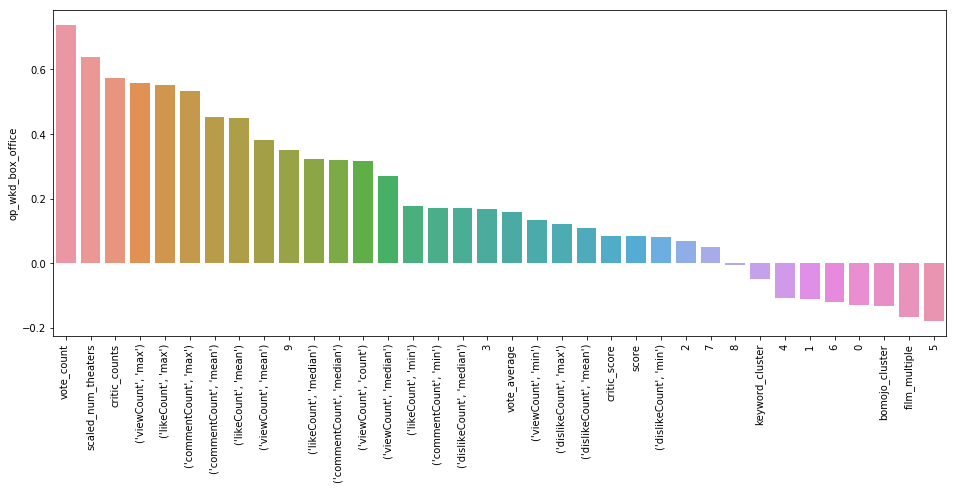

In [146]:
plt.figure(figsize=(16,6))
sns.barplot(x=df_corr_graph.index[2:],y=df_corr_graph.op_wkd_box_office[2:])
plt.xticks(rotation=90)
plt.show()

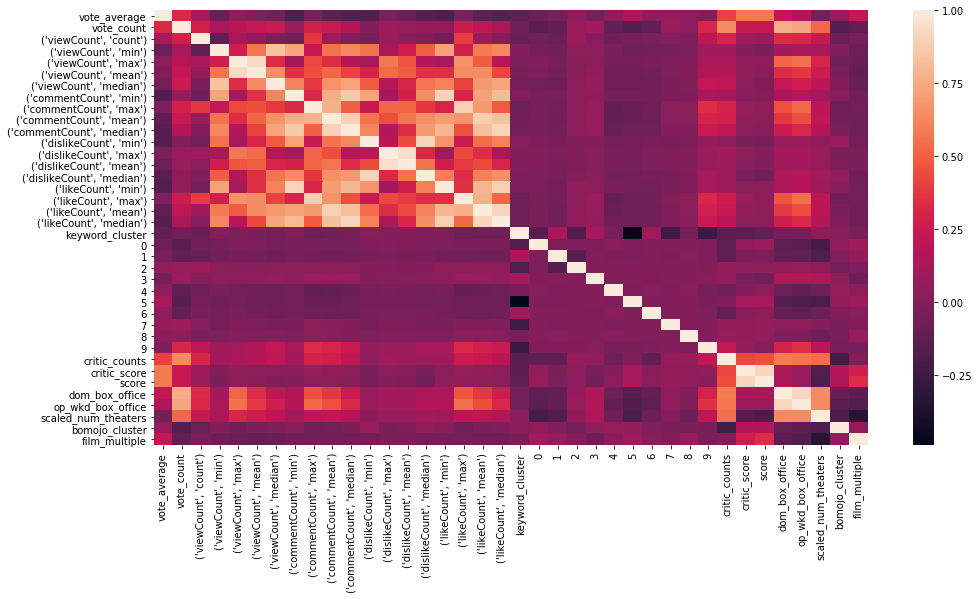

In [147]:
plt.figure(figsize=(16,8))
sns.heatmap(df_corr)

In [148]:
# how often are the max of view,like,comment the same
# feature reduction - an interesting point is that the most important feature of opening weekend box office performance 
# is the number of views of the most popular video

### Feature correlation plus some additional analysis for wikipedia pageview data features

In [149]:
df_corr2 = df_bo_predictor_wpv[['op_wkd_box_office','dom_box_office',
                            'max_month_2', 'max_month_3', 'max_total', 'max_week_2', 'max_week_3', 'max_week_4',
                            'mean_month_2', 'mean_month_3', 'mean_total', 'mean_week_2', 'mean_week_3', 'mean_week_4',
                            'median_month_2', 'median_month_3', 'median_total', 'median_week_2','median_week_3', 'median_week_4',
                            'std_month_2', 'std_month_3', 'std_total', 'std_week_2', 'std_week_3', 'std_week_4']]
df_corr2 = df_corr2.corr()
df_corr2 = df_corr2[['op_wkd_box_office','dom_box_office']].sort_values(by='op_wkd_box_office',ascending=False)

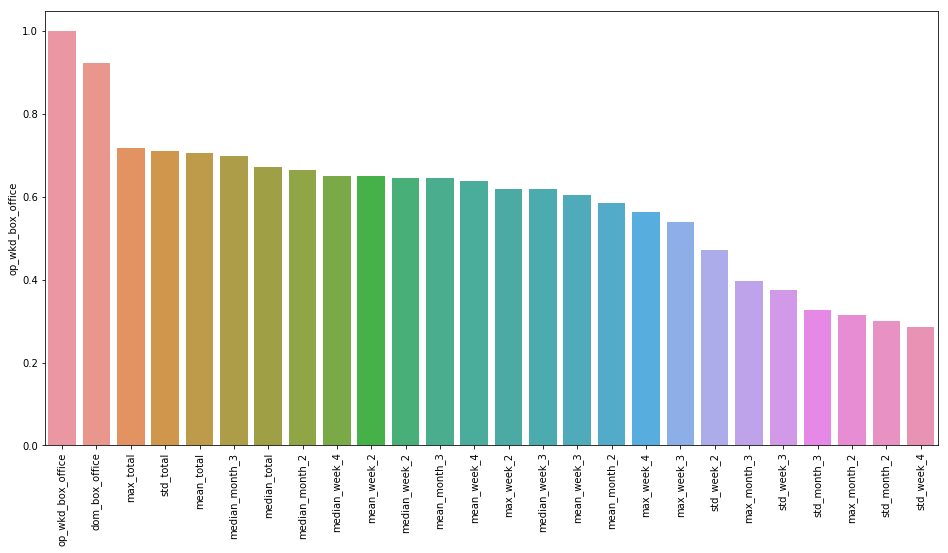

In [150]:
plt.figure(figsize=(16,8))
sns.barplot(x=df_corr2.index,y=df_corr2.op_wkd_box_office)
plt.xticks(rotation=90)
plt.show()

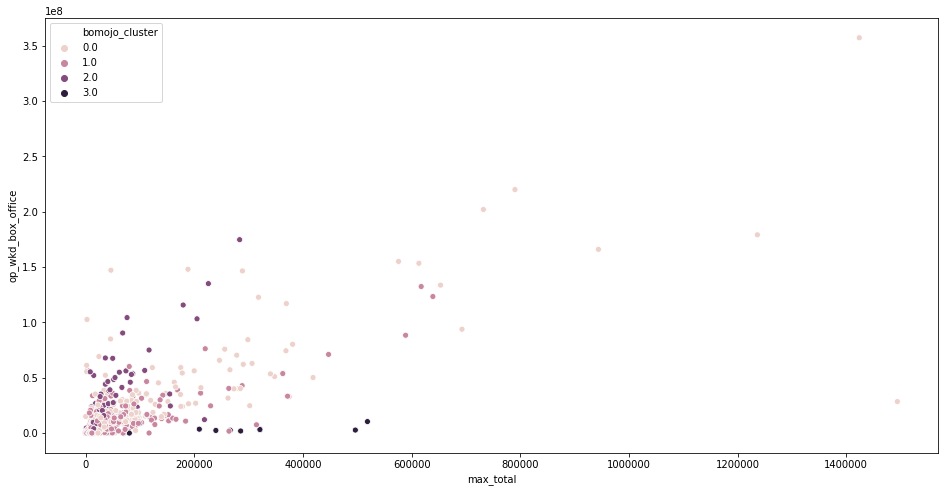

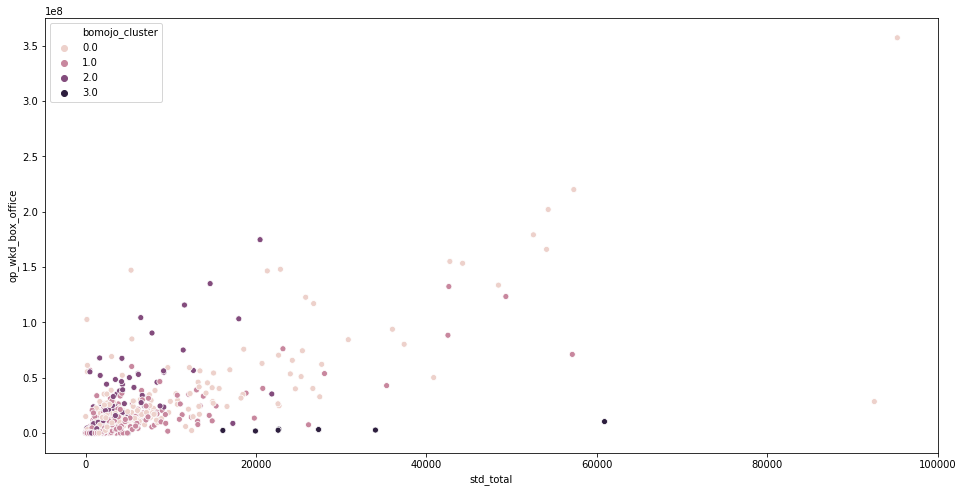

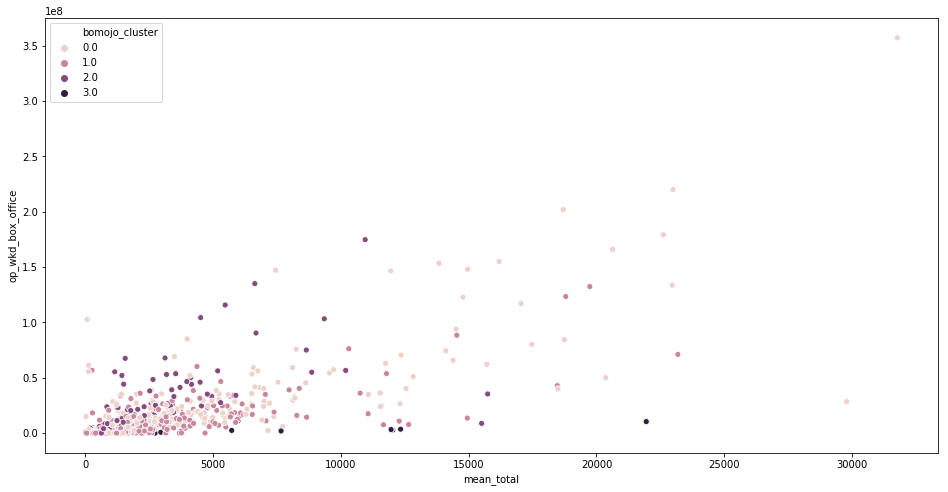

In [151]:
scatter_graph(df_bo_predictor_wpv,'max_total','op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor_wpv,'std_total','op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor_wpv,'mean_total','op_wkd_box_office','bomojo_cluster')

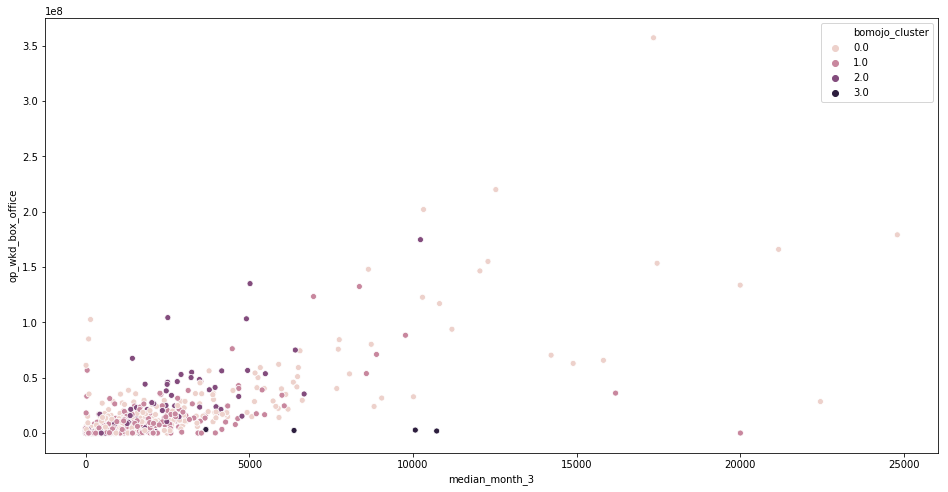

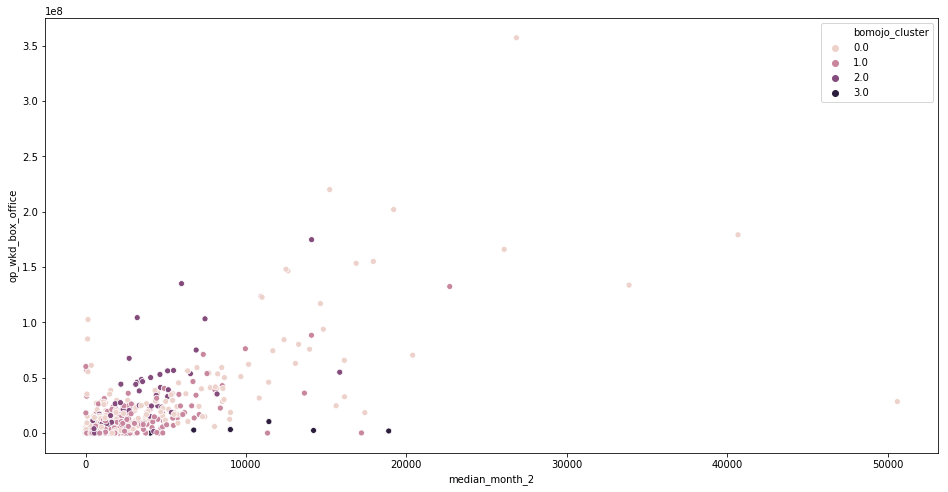

In [152]:
scatter_graph(df_bo_predictor_wpv,'median_month_3','op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor_wpv,'median_month_2','op_wkd_box_office','bomojo_cluster')

## Box Office Prediction model without wikipedia pageviews
### Linear Regression model

In [154]:
# linear regression for box office results
df_bo_predictor.week_number = df_bo_predictor.week_number.astype(str) 
df_model = df_bo_predictor.drop(['dom_box_office','film_multiple'],axis=1)
df_model = df_model.dropna()
X = df_model.drop('op_wkd_box_office',axis=1)
Y = df_model.op_wkd_box_office
X = pd.get_dummies(X)

In [155]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

In [156]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)
print('R-squared: \n', lr.score(X_train, y_train))

Coefficients: 
 [-2.14600896e+06  4.24488215e+03 -3.20165105e+07  8.95323846e+06
  8.11604722e+08 -4.69957249e+08  1.45047392e+07 -1.72969552e+08
  3.72521129e+08 -1.64170794e+08  1.87375294e+08  1.02378704e+08
 -5.26367838e+08  3.17587833e+08 -5.67344233e+07  2.56734227e+08
  7.94563108e+07 -1.64094090e+08 -2.18612953e+06 -2.41169475e+06
  1.32544282e+06  2.17666204e+06 -1.28361817e+06 -4.14801449e+05
  1.37250216e+06 -1.15943938e+06  9.69165440e+05  8.98127069e+04
 -4.80084252e+04 -3.32533939e+06  5.47652278e+05 -3.40746767e+06
  5.76434459e+04 -1.49565838e+06  3.05399299e-05  1.44321854e+06
  4.18709978e+06 -5.73902050e+05  7.21812248e-05 -1.44278225e+07
 -3.25539078e+06  2.73082013e+06 -4.93362716e+06 -4.76837158e-07
  6.47468446e+05 -1.75208364e+06 -2.86250745e+06 -1.89208146e+06
 -4.27209719e+06 -2.46184602e+06 -7.95955359e+06 -1.85370445e-05
 -2.50339508e-06 -2.35661864e-05 -3.00779939e-05  3.25106084e-05
 -4.62932668e+06 -2.36979813e+06 -2.65315175e-05 -4.78327274e-05
 -1.73598

In [157]:
y_pred = lr.predict(X_test)

print('Mean Absolute Error: %.f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 9527990
Mean Squared Error: 262502839452141
Root Mean Squared Error: 16201939
Median Absolute Error: 2510


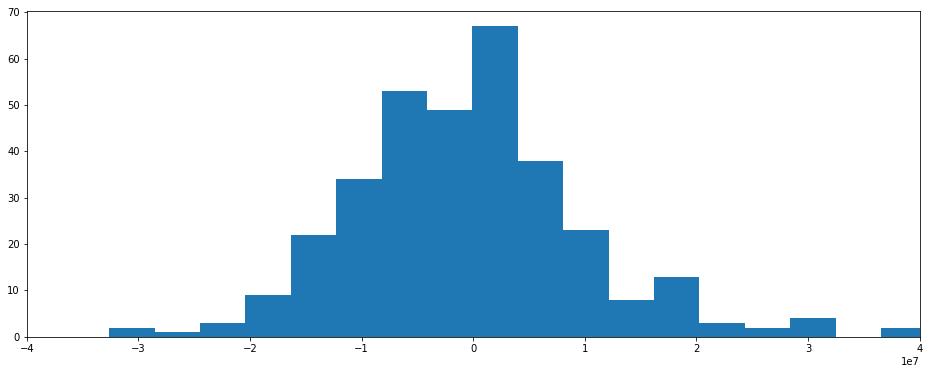

In [158]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=60)
plt.xlim(-4e7,4e7)
plt.show()

In [159]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [163]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9,.95])

0.10       10.667699
0.20       19.998278
0.25       24.597792
0.50       58.553567
0.75      258.943395
0.80     1030.715714
0.85     2928.617377
0.90     9311.577381
0.95    34946.519491
Name: difference %, dtype: float64

In [161]:
# look at accruacy based on box office
# bar chart is intervals of how much money made, height of the bar is accuracy
# groupby with box office, mean of ratio column
df_compare = pd.DataFrame(Y)
df_compare['Y_pred'] = lr.predict(X)
df_compare['residuals'] = df_compare.Y_pred - df_compare.op_wkd_box_office
df_compare['errors'] = df_compare.Y_pred / df_compare.op_wkd_box_office - 1

bin_range = [0,10000000,20000000,30000000,40000000,50000000,100000000,200000000,2000000000]
label_range = ['0M-10M','10M-20M','20M-30M','30M-40M','40M-50M','50M-100M','100M-200M','200M+']
df_compare['bins'] = pd.cut(df_compare.op_wkd_box_office,bins=bin_range,labels=label_range)

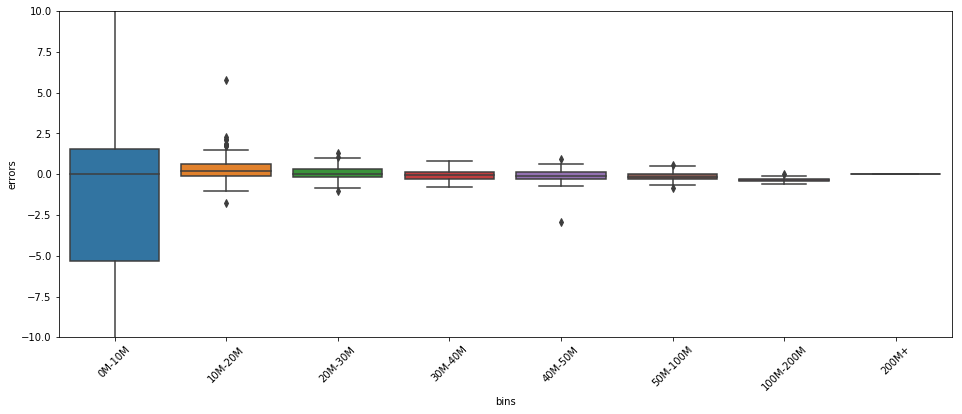

In [162]:
plt.figure(figsize=(16,6))
sns.boxplot(x='bins',y='errors', data=df_compare)
plt.xticks(rotation=45)
plt.ylim(-10,10)
plt.show()

### Random Forest Regressor

In [164]:
rfr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
rfr.fit(X_train, y_train)
score = rfr.score(X_test, y_test)
print(f'Accuracy score for random forest regressor: {score}')

Accuracy score for random forest regressor: 0.7400226370336195


In [165]:
y_pred = rfr.predict(X_test)

print('Mean Absolute Error: %.f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 6852821
Mean Squared Error: 135612258308627
Root Mean Squared Error: 11645268
Median Absolute Error: 1915


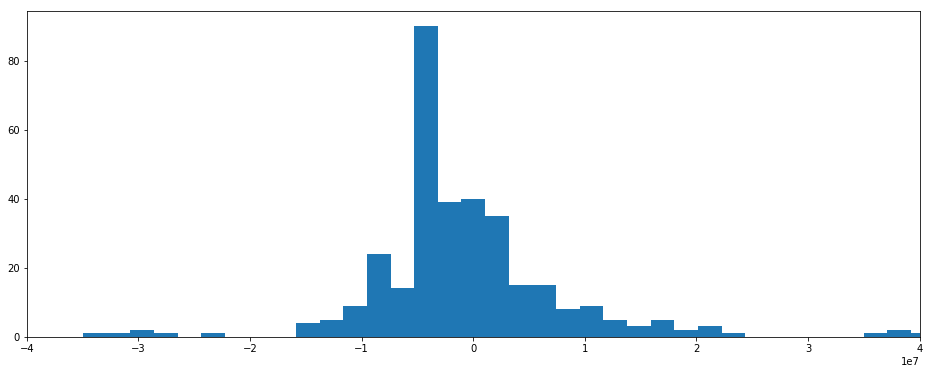

In [166]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=60)
plt.xlim(-4e7,4e7)
plt.show()

In [167]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [171]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9,.95])

0.10        7.480104
0.20       14.649434
0.25       20.230871
0.50       43.286064
0.75      146.318137
0.80      874.810578
0.85     3537.164729
0.90     8665.077810
0.95    21969.173287
Name: difference %, dtype: float64

In [169]:
# look at accruacy based on box office
# bar chart is intervals of how much money made, height of the bar is accuracy
# groupby with box office, mean of ratio column
df_compare = pd.DataFrame(Y)
df_compare['Y_pred'] = rfr.predict(X)
df_compare['residuals'] = df_compare.Y_pred - df_compare.op_wkd_box_office
df_compare['errors'] = df_compare.Y_pred / df_compare.op_wkd_box_office - 1

bin_range = [0,10000000,20000000,30000000,40000000,50000000,100000000,200000000,2000000000]
label_range = ['0M-10M','10M-20M','20M-30M','30M-40M','40M-50M','50M-100M','100M-200M','200M+']
df_compare['bins'] = pd.cut(df_compare.op_wkd_box_office,bins=bin_range,labels=label_range)

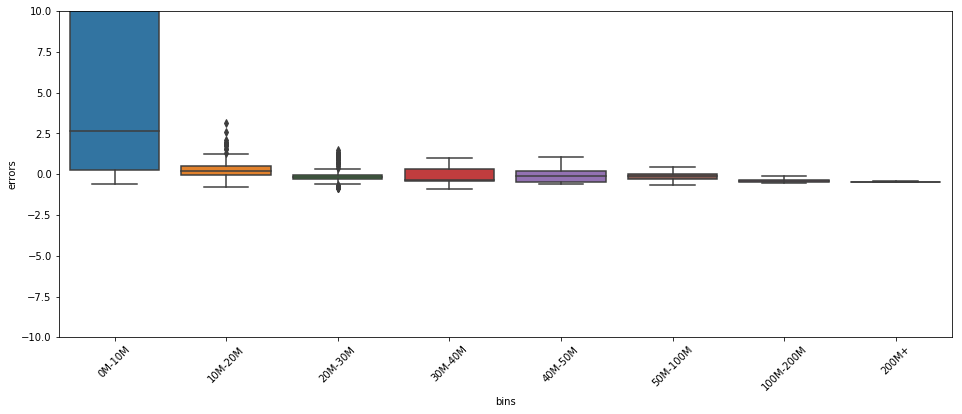

In [170]:
plt.figure(figsize=(16,6))
sns.boxplot(x='bins',y='errors', data=df_compare)
plt.xticks(rotation=45)
plt.ylim(-10,10)
plt.show()

### NN

In [174]:
df_bo_predictor.week_number = df_bo_predictor.week_number.astype(str)
df_model = df_bo_predictor.drop(['dom_box_office','film_multiple','bins'],axis=1)
df_model = df_model.dropna()

In [176]:
X = df_model.drop('op_wkd_box_office',axis=1)
Y = df_model.op_wkd_box_office
X = pd.get_dummies(X)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=43)

In [178]:
# inputs first
input_shape = X_train.shape[1:]
num_classes = 1 # for regression problem

#### NOTES: 
- Elu does not do as well as relu as the activation function
- each additional layer added performs better, data does not take too long generally
- 10 epochs better than 5 epochs, 100 epochs better than 10 epochs

potentially try to use log_mean_absolute_error
benefit from more nodes in each layers
increase epochs until inflection point
learning rate and learning rate decay - fine tune how fast to train
by default rmsprop has learning rate of 0.1, lower the learning rate with RMSprop
using validation step inside of NN inside of train test split beforehand

In [179]:
from keras.layers import LeakyReLU, PReLU

model = Sequential()

model.add(Dense(128,input_shape=input_shape,activation='relu'))
model.add(Dense(64))
model.add(PReLU(alpha_initializer='zeros'))
model.add(Dense(64))
model.add(LeakyReLU(alpha=.03))
model.add(Dropout(0.1))
model.add(Dense(64))
model.add(LeakyReLU(alpha=.03))
model.add(Dense(64, activation='elu'))
model.add(Dense(64))
model.add(LeakyReLU(alpha=.03))
model.add(Dense(64))
model.add(LeakyReLU(alpha=.03))
model.add(Dropout(0.1))
model.add(Dense(64))
model.add(LeakyReLU(alpha=.03))
model.add(Dense(64))
model.add(LeakyReLU(alpha=.03))
model.add(Dense(64))
model.add(LeakyReLU(alpha=.03))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(num_classes, activation='linear'))

model.summary()
# Compile the model to put it all together.
model.compile(loss='mean_absolute_error',
              optimizer=RMSprop(lr=0.0005),
              metrics=['mean_absolute_error'])

2019-07-05 22:56:27,723 From c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
2019-07-05 22:56:27,805 From c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               51456     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 64)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
__________

In [180]:
history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=500,
                    verbose=1,
                    validation_data=(X_test,y_test))
score = model.evaluate(X_test, y_test, verbose=0)

2019-07-05 22:56:28,814 From c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 1453 samples, validate on 257 samples
Epoch 1/500
1453/1453 [==============================] - 1s 558us/step - loss: 13396591.5926 - mean_absolute_error: 13396591.5926 - val_loss: 9857099.4494 - val_mean_absolute_error: 9857099.4494
Epoch 2/500
1453/1453 [==============================] - 0s 151us/step - loss: 9659550.0977 - mean_absolute_error: 9659550.0977 - val_loss: 9638125.1187 - val_mean_absolute_error: 9638125.1187
Epoch 3/500
1453/1453 [==============================] - 0s 152us/step - loss: 9743690.9966 - mean_absolute_error: 9743690.9966 - val_loss: 9611809.9582 - val_mean_absolute_error: 9611809.9582
Epoch 4/500
1453/1453 [==============================] - 0s 145us/step - loss: 9774235.4415 - mean_absolute_error: 9774235.4415 - val_loss: 9625821.0311 - val_mean_absolute_error: 9625821.0311
Epoch 5/500
1453/1453 [==============================] - 0s 143us/step - loss: 9791556.4618 - mean_absolute_error: 9791556.4618 - val_loss: 9548735.5467 - val_mean_absolute_error:

1453/1453 [==============================] - 0s 140us/step - loss: 8499040.5409 - mean_absolute_error: 8499040.5409 - val_loss: 7955557.2111 - val_mean_absolute_error: 7955557.2111
Epoch 43/500
1453/1453 [==============================] - 0s 140us/step - loss: 8388832.0798 - mean_absolute_error: 8388832.0798 - val_loss: 8131251.7383 - val_mean_absolute_error: 8131251.7383
Epoch 44/500
1453/1453 [==============================] - 0s 144us/step - loss: 8342333.9491 - mean_absolute_error: 8342333.9491 - val_loss: 8229947.8638 - val_mean_absolute_error: 8229947.8638
Epoch 45/500
1453/1453 [==============================] - 0s 157us/step - loss: 8296445.5974 - mean_absolute_error: 8296445.5974 - val_loss: 8337965.9961 - val_mean_absolute_error: 8337965.9961
Epoch 46/500
1453/1453 [==============================] - 0s 147us/step - loss: 8374617.7195 - mean_absolute_error: 8374617.7195 - val_loss: 7828755.1936 - val_mean_absolute_error: 7828755.1936
Epoch 47/500
1453/1453 [===================

1453/1453 [==============================] - 0s 143us/step - loss: 7466417.5072 - mean_absolute_error: 7466417.5072 - val_loss: 8539196.7889 - val_mean_absolute_error: 8539196.7889
Epoch 85/500
1453/1453 [==============================] - 0s 174us/step - loss: 7460480.8493 - mean_absolute_error: 7460480.8493 - val_loss: 7371564.0263 - val_mean_absolute_error: 7371564.0263
Epoch 86/500
1453/1453 [==============================] - 0s 175us/step - loss: 7483423.7371 - mean_absolute_error: 7483423.7371 - val_loss: 7503542.8696 - val_mean_absolute_error: 7503542.8696
Epoch 87/500
1453/1453 [==============================] - 0s 155us/step - loss: 7390099.5571 - mean_absolute_error: 7390099.5571 - val_loss: 8948464.1809 - val_mean_absolute_error: 8948464.1809
Epoch 88/500
1453/1453 [==============================] - 0s 136us/step - loss: 7539000.4418 - mean_absolute_error: 7539000.4418 - val_loss: 7262915.0214 - val_mean_absolute_error: 7262915.0214
Epoch 89/500
1453/1453 [===================

1453/1453 [==============================] - 0s 155us/step - loss: 7058919.3758 - mean_absolute_error: 7058919.3758 - val_loss: 7549165.7665 - val_mean_absolute_error: 7549165.7665
Epoch 127/500
1453/1453 [==============================] - 0s 145us/step - loss: 6896867.7942 - mean_absolute_error: 6896867.7942 - val_loss: 7103105.7695 - val_mean_absolute_error: 7103105.7695
Epoch 128/500
1453/1453 [==============================] - 0s 167us/step - loss: 6812704.9436 - mean_absolute_error: 6812704.9436 - val_loss: 7127375.8084 - val_mean_absolute_error: 7127375.8084
Epoch 129/500
1453/1453 [==============================] - 0s 143us/step - loss: 7012493.9400 - mean_absolute_error: 7012493.9400 - val_loss: 7902960.0496 - val_mean_absolute_error: 7902960.0496
Epoch 130/500
1453/1453 [==============================] - 0s 153us/step - loss: 6845366.8827 - mean_absolute_error: 6845366.8827 - val_loss: 7498653.5846 - val_mean_absolute_error: 7498653.5846
Epoch 131/500
1453/1453 [==============

1453/1453 [==============================] - 0s 140us/step - loss: 6774401.3861 - mean_absolute_error: 6774401.3861 - val_loss: 8199363.4397 - val_mean_absolute_error: 8199363.4397
Epoch 169/500
1453/1453 [==============================] - 0s 139us/step - loss: 6693240.9554 - mean_absolute_error: 6693240.9554 - val_loss: 8398933.0564 - val_mean_absolute_error: 8398933.0564
Epoch 170/500
1453/1453 [==============================] - 0s 138us/step - loss: 6819107.0743 - mean_absolute_error: 6819107.0743 - val_loss: 6958689.9290 - val_mean_absolute_error: 6958689.9290
Epoch 171/500
1453/1453 [==============================] - 0s 139us/step - loss: 6916644.4573 - mean_absolute_error: 6916644.4573 - val_loss: 8012678.8872 - val_mean_absolute_error: 8012678.8872
Epoch 172/500
1453/1453 [==============================] - 0s 156us/step - loss: 6871913.6903 - mean_absolute_error: 6871913.6903 - val_loss: 7177336.1342 - val_mean_absolute_error: 7177336.1342
Epoch 173/500
1453/1453 [==============

1453/1453 [==============================] - 0s 164us/step - loss: 6656709.6091 - mean_absolute_error: 6656709.6091 - val_loss: 7924691.5292 - val_mean_absolute_error: 7924691.5292
Epoch 211/500
1453/1453 [==============================] - 0s 150us/step - loss: 6431137.6994 - mean_absolute_error: 6431137.6994 - val_loss: 8055597.2198 - val_mean_absolute_error: 8055597.2198
Epoch 212/500
1453/1453 [==============================] - 0s 140us/step - loss: 6572279.0330 - mean_absolute_error: 6572279.0330 - val_loss: 6863961.0195 - val_mean_absolute_error: 6863961.0195
Epoch 213/500
1453/1453 [==============================] - 0s 145us/step - loss: 6640380.8575 - mean_absolute_error: 6640380.8575 - val_loss: 7964619.3560 - val_mean_absolute_error: 7964619.3560
Epoch 214/500
1453/1453 [==============================] - 0s 147us/step - loss: 6577030.6683 - mean_absolute_error: 6577030.6683 - val_loss: 7489603.4669 - val_mean_absolute_error: 7489603.4669
Epoch 215/500
1453/1453 [==============

1453/1453 [==============================] - 0s 155us/step - loss: 6398356.6211 - mean_absolute_error: 6398356.6211 - val_loss: 7087541.2510 - val_mean_absolute_error: 7087541.2510
Epoch 253/500
1453/1453 [==============================] - 0s 171us/step - loss: 6314275.4827 - mean_absolute_error: 6314275.4827 - val_loss: 7503735.7130 - val_mean_absolute_error: 7503735.7130
Epoch 254/500
1453/1453 [==============================] - 0s 204us/step - loss: 6285743.7825 - mean_absolute_error: 6285743.7825 - val_loss: 7277440.1167 - val_mean_absolute_error: 7277440.1167
Epoch 255/500
1453/1453 [==============================] - 0s 161us/step - loss: 6183190.1211 - mean_absolute_error: 6183190.1211 - val_loss: 7228774.2374 - val_mean_absolute_error: 7228774.2374
Epoch 256/500
1453/1453 [==============================] - 0s 169us/step - loss: 6359093.9140 - mean_absolute_error: 6359093.9140 - val_loss: 7054293.6848 - val_mean_absolute_error: 7054293.6848
Epoch 257/500
1453/1453 [==============

1453/1453 [==============================] - 0s 175us/step - loss: 6170653.2836 - mean_absolute_error: 6170653.2836 - val_loss: 7310990.6926 - val_mean_absolute_error: 7310990.6926
Epoch 295/500
1453/1453 [==============================] - 0s 284us/step - loss: 6163110.3028 - mean_absolute_error: 6163110.3028 - val_loss: 7072807.8405 - val_mean_absolute_error: 7072807.8405
Epoch 296/500
1453/1453 [==============================] - 0s 178us/step - loss: 6243384.5635 - mean_absolute_error: 6243384.5635 - val_loss: 7689666.8940 - val_mean_absolute_error: 7689666.8940
Epoch 297/500
1453/1453 [==============================] - 0s 166us/step - loss: 6177653.3913 - mean_absolute_error: 6177653.3913 - val_loss: 7799503.8833 - val_mean_absolute_error: 7799503.8833
Epoch 298/500
1453/1453 [==============================] - 0s 160us/step - loss: 6042041.3049 - mean_absolute_error: 6042041.3049 - val_loss: 7929112.2451 - val_mean_absolute_error: 7929112.2451
Epoch 299/500
1453/1453 [==============

1453/1453 [==============================] - 0s 189us/step - loss: 6097113.2682 - mean_absolute_error: 6097113.2682 - val_loss: 6838812.6459 - val_mean_absolute_error: 6838812.6459
Epoch 337/500
1453/1453 [==============================] - 0s 206us/step - loss: 6067167.8390 - mean_absolute_error: 6067167.8390 - val_loss: 7212593.4212 - val_mean_absolute_error: 7212593.4212
Epoch 338/500
1453/1453 [==============================] - 0s 176us/step - loss: 5993763.7615 - mean_absolute_error: 5993763.7615 - val_loss: 6955582.2101 - val_mean_absolute_error: 6955582.2101
Epoch 339/500
1453/1453 [==============================] - 0s 178us/step - loss: 6000213.7459 - mean_absolute_error: 6000213.7459 - val_loss: 7286885.1109 - val_mean_absolute_error: 7286885.1109
Epoch 340/500
1453/1453 [==============================] - 0s 174us/step - loss: 6086265.5871 - mean_absolute_error: 6086265.5871 - val_loss: 7406651.4611 - val_mean_absolute_error: 7406651.4611
Epoch 341/500
1453/1453 [==============

1453/1453 [==============================] - 0s 202us/step - loss: 5859003.4741 - mean_absolute_error: 5859003.4741 - val_loss: 8241711.3074 - val_mean_absolute_error: 8241711.3074
Epoch 379/500
1453/1453 [==============================] - 0s 190us/step - loss: 5879134.5721 - mean_absolute_error: 5879134.5721 - val_loss: 7435292.6128 - val_mean_absolute_error: 7435292.6128
Epoch 380/500
1453/1453 [==============================] - 0s 182us/step - loss: 5930410.7626 - mean_absolute_error: 5930410.7626 - val_loss: 6909890.9805 - val_mean_absolute_error: 6909890.9805
Epoch 381/500
1453/1453 [==============================] - 0s 178us/step - loss: 5957277.6101 - mean_absolute_error: 5957277.6101 - val_loss: 7300253.8774 - val_mean_absolute_error: 7300253.8774
Epoch 382/500
1453/1453 [==============================] - 0s 182us/step - loss: 5885226.1258 - mean_absolute_error: 5885226.1258 - val_loss: 7572638.1770 - val_mean_absolute_error: 7572638.1770
Epoch 383/500
1453/1453 [==============

1453/1453 [==============================] - 0s 222us/step - loss: 5871158.8563 - mean_absolute_error: 5871158.8563 - val_loss: 6755314.1051 - val_mean_absolute_error: 6755314.1051
Epoch 421/500
1453/1453 [==============================] - 0s 203us/step - loss: 5767040.1321 - mean_absolute_error: 5767040.1321 - val_loss: 6771832.3502 - val_mean_absolute_error: 6771832.3502
Epoch 422/500
1453/1453 [==============================] - 1s 345us/step - loss: 5871940.5616 - mean_absolute_error: 5871940.5616 - val_loss: 6864472.7160 - val_mean_absolute_error: 6864472.7160
Epoch 423/500
1453/1453 [==============================] - 0s 272us/step - loss: 5778288.5518 - mean_absolute_error: 5778288.5518 - val_loss: 7022916.0759 - val_mean_absolute_error: 7022916.0759
Epoch 424/500
1453/1453 [==============================] - 0s 202us/step - loss: 5761455.8668 - mean_absolute_error: 5761455.8668 - val_loss: 7085112.0253 - val_mean_absolute_error: 7085112.0253
Epoch 425/500
1453/1453 [==============

Epoch 462/500
1453/1453 [==============================] - 0s 203us/step - loss: 5708630.5970 - mean_absolute_error: 5708630.5970 - val_loss: 7412655.7889 - val_mean_absolute_error: 7412655.7889
Epoch 463/500
1453/1453 [==============================] - 0s 220us/step - loss: 5754275.9319 - mean_absolute_error: 5754275.9319 - val_loss: 6844698.7821 - val_mean_absolute_error: 6844698.7821
Epoch 464/500
1453/1453 [==============================] - 0s 211us/step - loss: 5650216.3798 - mean_absolute_error: 5650216.3798 - val_loss: 6685113.3716 - val_mean_absolute_error: 6685113.3716
Epoch 465/500
1453/1453 [==============================] - 0s 220us/step - loss: 5659481.3448 - mean_absolute_error: 5659481.3448 - val_loss: 7973161.7412 - val_mean_absolute_error: 7973161.7412
Epoch 466/500
1453/1453 [==============================] - 0s 207us/step - loss: 5596440.7280 - mean_absolute_error: 5596440.7280 - val_loss: 6865666.4981 - val_mean_absolute_error: 6865666.4981
Epoch 467/500
1453/1453 [

In [181]:
y_pred = model.predict(X_test.values)
residuals = y_pred.ravel() - y_test.values
abs(residuals).mean()

print('Mean Absolute Error: %.f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 6685626
Mean Squared Error: 138114450767699
Root Mean Squared Error: 11752210
Median Absolute Error: 1780


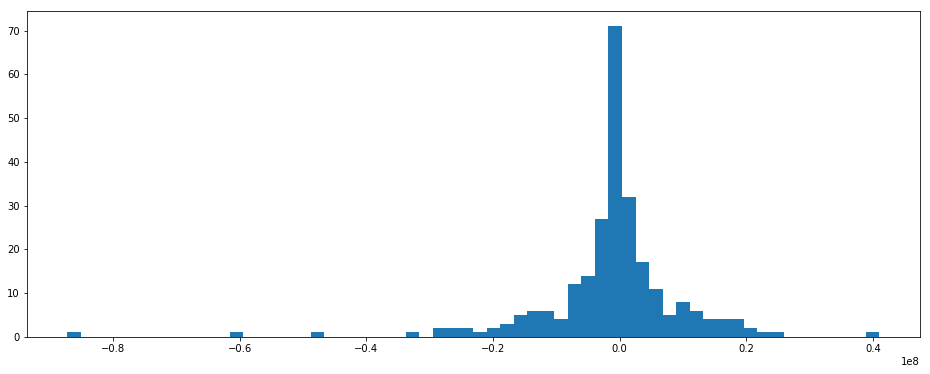

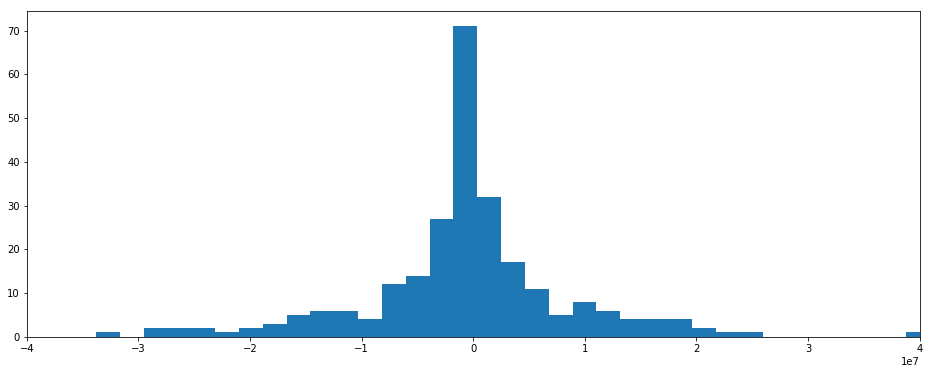

In [182]:
plt.figure(figsize=(16,6))
plt.hist(residuals, bins=60)
plt.show()
plt.figure(figsize=(16,6))
plt.hist(residuals, bins=60)
plt.xlim(-4e7,4e7)
plt.show()

In [183]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice': y_test.values,
                          'predicted_boxoffice':y_pred.ravel()},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

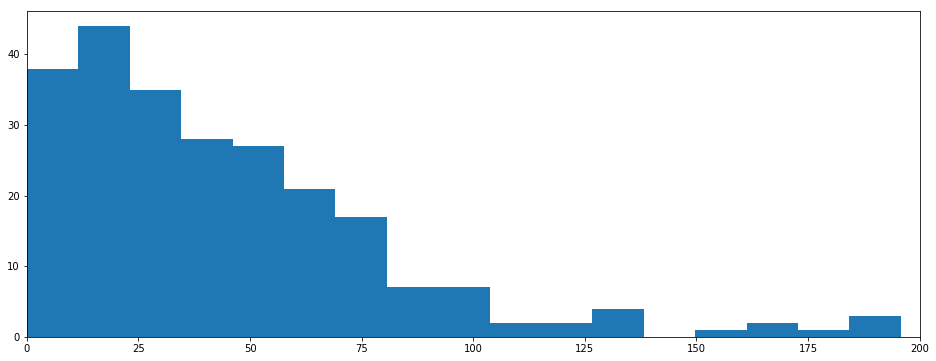

In [191]:
plt.figure(figsize=(16,6))
plt.hist(compare_df['difference %'], bins=1000)
plt.xlim(0,200)
plt.show()

In [185]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9,.95])

0.10      6.938994
0.20     15.630629
0.25     19.245940
0.50     39.022418
0.75     68.515728
0.80     76.619714
0.85     93.635231
0.90    134.547322
0.95    286.085474
Name: difference %, dtype: float64

In [186]:
# look at accruacy based on box office
# bar chart is intervals of how much money made, height of the bar is accuracy
# groupby with box office, mean of ratio column
df_compare = pd.DataFrame(Y)
df_compare['Y_pred'] = model.predict(X)
df_compare['residuals'] = df_compare.Y_pred - df_compare.op_wkd_box_office
df_compare['errors'] = df_compare.Y_pred / df_compare.op_wkd_box_office - 1

bin_range = [0,10000000,20000000,30000000,40000000,50000000,100000000,200000000,2000000000]
label_range = ['0M-10M','10M-20M','20M-30M','30M-40M','40M-50M','50M-100M','100M-200M','200M+']
df_compare['bins'] = pd.cut(df_compare.op_wkd_box_office,bins=bin_range,labels=label_range)

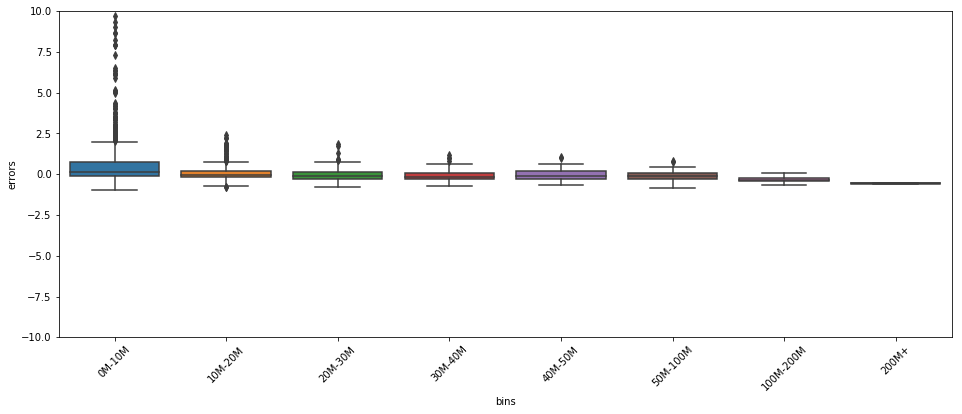

In [193]:
plt.figure(figsize=(16,6))
sns.boxplot(x='bins',y='errors', data=df_compare)
plt.xticks(rotation=45)
plt.ylim(-10,10)
plt.show()

NOTES:
Mean absolute error:
- First iteration (500 epochs): 5.9417M
- Iteration with adding (1) leakyrelu(a=0.05) (500 epochs): 6.1690M
- Iteration with adding (1) leakyrelu(a=0.03) (500 epochs): 5.6956M
- Iteration with adding (1) leakyrelu(a=0.01) (500 epochs): 6.0189M

- Iteration with adding (2) leakyrelu(a=0.03) (500 epochs): 7.7714M
- Iteration with adding (2) leakyrelu(a=0.03) (500 epochs): 6.6204M (but one of the dense layers in between)
- Iteration with adding (2) leakyrelu(a=0.03) (500 epochs): 5.793269M (more in beginning, still  one of the dense layers in between)
- Iteration with adding (2) leakyrelu(a=0.03) (500 epochs): 5.8362M (but one at beginning and end)

- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 7.1531M (beginning, middle, emd)
- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 5.9396M (all together beginning)
- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 5.7035M (all together beginning, earlier right after start)
- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 6.7081M (all together middle)
- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 7.0383M (all together end)
- Iteration with adding (3) leakyrelu(a=0.03) (500 epochs): 6.1330M (beginning, with dense layers in between)

- Iteration with adding (4) leakyrelu(a=0.03) (500 epochs): 5.9501M (all at beginning)
- Iteration with adding (4) leakyrelu(a=0.03) (500 epochs): 6.0538M (2 at beginning, 1 dense layer, 2 after that)
- Iteration with adding (4) leakyrelu(a=0.03) (500 epochs): 7.1631M (2 at beginning, 2 in middle)
- Iteration with adding (4) leakyrelu(a=0.03) (500 epochs): 6.5951M (2 at beginning, 2 at end)

- Iteration with adding (6) leakyrelu(a=0.03) (500 epochs): 6.2873M (all at beginning right after start)
- Iteration with all (10) leakyrelu(a=0.03) (500 epochs): 9.5614M 
- Iteration with (10) leakyrelu(a=0.03) (500 epochs): 6.3074M (all at beginning) 

- Iteration with (1) leakyrelu(a=0.03) and (1) PReLU (500 epochs): 5.6511M (dense layer between, PReLU first) 
- Iteration with (1) leakyrelu(a=0.03) and (1) PReLU (1000 epochs): 5.1120 (dense layer between, PReLU first) 
- Iteration with (1) leakyrelu(a=0.03) (1000 epochs): 5.0712M (leakyrelu first) 
- Iteration with (1) leakyrelu(a=0.03) (1000 epochs): 4.8158M (leakyrelu first and 2 more dense layers) 
- Iteration with (1) leakyrelu(a=0.03) (1000 epochs): 4.518326M (leakyrelu first and 3 more dense layers (64 nodes)) 
- Iteration with (1) leakyrelu(a=0.03) (1000 epochs): 4.018532M (leakyrelu first and 3 more dense layers (64 nodes)) 
- Iteration with (1) leakyrelu(a=0.03) (1000 epochs): 4.0966M (leakyrelu first and 3 more dense layers (64 nodes)) 

- Removed a few dense layers, now at 4.4709M, trying to get back to just over 4M
- back to 4.358M and ~18% off on 50% of predictions (one iteration went as far as ~16% off for 50%). Still worried about overfitting looking at the validation mean absolute errors on the epoch verbose print outs.

- added a few more dense layers with 64 nodes and error down to ~3.8M with 50% of predictions within 15% of actuals

Takeaways:
- overfitting with 1000 epochs, keeping it to 500 to remove overfitting (above used the train test split inherent in keras)
- plus adding 2 dropout layers to further prevent overfitting

## Film Multiple model
### Linear regression to predict film multiple

In [107]:
# linear regression for box office results
df_model = df_bo_predictor.drop(['dom_box_office','op_wkd_box_office','log_op_wkd_box_office'],axis=1)
df_model = df_model.dropna()
X = df_model.drop('film_multiple',axis=1)
Y = df_model.film_multiple
X = pd.get_dummies(X)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

In [109]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)
print('R-squared: \n', lr.score(X_train, y_train))

Coefficients: 
 [ 1.05642743e+00 -2.93231072e-04  2.97834356e-01 -7.71263115e+00
  3.64946339e+01 -2.00505228e+02  5.33677676e+01  2.17092380e+01
  7.91381231e+01 -1.20005159e+02  8.60028780e+01  2.36953117e+00
  1.22134304e+01 -1.63638221e+01  1.27650246e+01 -1.83005508e+01
 -1.13423575e+02  2.33119787e+02 -1.89698290e+02  6.67547222e-01
  1.27682493e+00  1.77914294e+00 -1.50088125e+00 -5.15761084e-01
 -5.34401291e+00 -3.47856924e-01 -3.92510257e-01  1.09285736e+00
  1.37254888e+00  2.45044972e-01  3.48618108e+00 -1.03198687e+00
  2.18496285e+00 -1.26137849e+00 -2.43538523e-12 -1.34395031e+00
 -8.51993811e-01 -5.63639506e+00 -2.52562415e-11  9.39681167e+00
 -8.14986548e-02  5.70442243e+01  4.99173078e+00 -1.80477855e-12
  8.11739555e+00  3.56953792e+00  1.33796702e+00  1.29463091e+00
 -4.34761612e+00  3.93978109e+00  7.20165549e+00  1.63469238e-12
  5.80246962e-12  8.41593462e-12 -3.41593420e-12  2.67519340e-12
 -3.89705333e+00 -1.80476911e+00  4.69357886e-12 -7.04503123e-12
 -3.54916

In [110]:
y_pred = lr.predict(X_test)

print('Mean Absolute Error: %.3f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.3f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.3f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 6.499
Mean Squared Error: 134.730
Root Mean Squared Error: 11.607
Median Absolute Error: 1.890


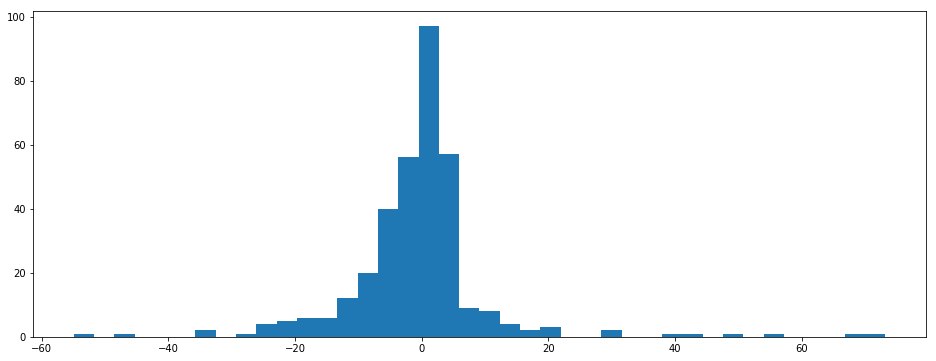

In [111]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=40)
plt.show()

In [112]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [113]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10     11.921710
0.20     28.041845
0.25     36.019058
0.50     93.680670
0.75    185.393652
0.80    223.149381
0.85    308.241019
0.90    437.064109
Name: difference %, dtype: float64

### Random Forest Regressor

In [114]:
rfr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
rfr.fit(X_train, y_train)
score = rfr.score(X_test, y_test)
print(f'Accuracy score for random forest regressor: {score}')

Accuracy score for random forest regressor: 0.40426385200792525


In [115]:
y_pred = rfr.predict(X_test)

print('Mean Absolute Error: %.3f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.3f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.3f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 3.340
Mean Squared Error: 65.810
Root Mean Squared Error: 8.112
Median Absolute Error: 0.841


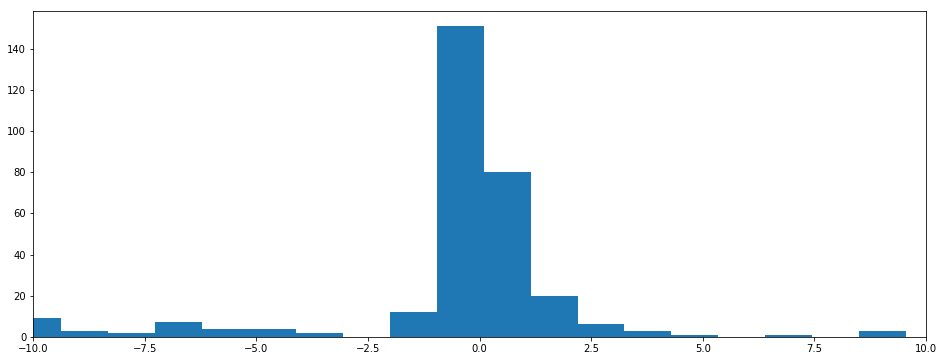

In [116]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=100)
plt.xlim([-10,10])
plt.show()

In [117]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [118]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10      3.789600
0.20      9.288465
0.25     11.349683
0.50     21.921594
0.75     41.977535
0.80     48.152205
0.85     62.491412
0.90    112.970440
Name: difference %, dtype: float64

## Box Office Prediction model WITH wikipedia pageviews
### Random Forest Regressor

In [119]:
df_model_wpv = df_bo_predictor_wpv.drop(['dom_box_office','film_multiple','log_op_wkd_box_office'],axis=1)
df_model_wpv = df_model_wpv.dropna()
X_wpv = df_model_wpv.drop('op_wkd_box_office',axis=1)
Y_wpv = df_model_wpv.op_wkd_box_office
X_wpv = pd.get_dummies(X_wpv)

In [120]:
X_train_wpv, X_test_wpv, y_train_wpv, y_test_wpv = train_test_split(X_wpv, Y_wpv, test_size=0.15, random_state=43)

In [121]:
rfr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
rfr.fit(X_train_wpv, y_train_wpv)
score = rfr.score(X_test_wpv, y_test_wpv)
print(f'Accuracy score for random forest regressor: {score}')

Accuracy score for random forest regressor: 0.672312090362029


In [125]:
y_pred_wpv = rfr.predict(X_test_wpv)
print('Mean Absolute Error: %.f' % metrics.mean_absolute_error(y_test_wpv, y_pred_wpv))  
print('Mean Squared Error: %.f' % metrics.mean_squared_error(y_test_wpv, y_pred_wpv))  
print('Root Mean Squared Error: %.f' % np.sqrt(metrics.mean_squared_error(y_test_wpv, y_pred_wpv)))
print('Median Absolute Error: %.f' % np.sqrt(metrics.median_absolute_error(y_test_wpv, y_pred_wpv)))

Mean Absolute Error: 11602360
Mean Squared Error: 453680287300586
Root Mean Squared Error: 21299772
Median Absolute Error: 2359


In [126]:
# for comparison when using log box office
compare_df_wpv = pd.DataFrame({'actual_boxoffice': y_test_wpv.values,
                          'predicted_boxoffice':y_pred_wpv.ravel()},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df_wpv['difference'] = abs(compare_df_wpv['actual_boxoffice'] - compare_df_wpv['predicted_boxoffice'])
compare_df_wpv['difference %'] = abs(compare_df_wpv['predicted_boxoffice'] / compare_df_wpv['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df_wpv[compare_df_wpv['difference %'] > 100]

In [127]:
compare_df_wpv['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10      12.887860
0.20      20.485897
0.25      25.764592
0.50      55.157600
0.75     166.705153
0.80     338.458096
0.85    4878.994944
0.90    8312.139624
Name: difference %, dtype: float64

### NN

In [128]:
df_model_wpv = df_bo_predictor_wpv.drop(['dom_box_office','film_multiple','log_op_wkd_box_office'],axis=1)
df_model_wpv = df_model_wpv.dropna()
X_wpv = df_model_wpv.drop('op_wkd_box_office',axis=1)
Y_wpv = df_model_wpv.op_wkd_box_office
X_wpv = pd.get_dummies(X_wpv)

In [129]:
input_shape_wpv = X_train_wpv.shape[1:]
num_classes_wpv = 1 # for regression problem

In [130]:
from keras.layers import LeakyReLU, PReLU

model_wpv = Sequential()

model_wpv.add(Dense(128,input_shape=input_shape_wpv,activation='relu'))
model_wpv.add(Dense(64))
model_wpv.add(PReLU(alpha_initializer='zeros'))
model_wpv.add(Dense(64))
model_wpv.add(LeakyReLU(alpha=.03))
model_wpv.add(Dropout(0.1))
model_wpv.add(Dense(64))
model_wpv.add(LeakyReLU(alpha=.03))
model_wpv.add(Dense(64, activation='elu'))
model_wpv.add(Dense(64))
model_wpv.add(LeakyReLU(alpha=.03))
model_wpv.add(Dense(64))
model_wpv.add(LeakyReLU(alpha=.03))
model_wpv.add(Dropout(0.1))
model_wpv.add(Dense(64))
model_wpv.add(LeakyReLU(alpha=.03))
model_wpv.add(Dense(64))
model_wpv.add(LeakyReLU(alpha=.03))
model_wpv.add(Dense(64))
model_wpv.add(LeakyReLU(alpha=.03))
model_wpv.add(Dropout(0.1))
model_wpv.add(Dense(64, activation='elu'))
model_wpv.add(Dense(32, activation='elu'))
model_wpv.add(Dense(16, activation='elu'))
model_wpv.add(Dense(num_classes_wpv, activation='linear'))

model_wpv.summary()
# Compile the model to put it all together.
model_wpv.compile(loss='mean_absolute_error',
              optimizer=RMSprop(lr=0.0005),
              metrics=['mean_absolute_error'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               31616     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 64)                64        
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
__________

In [131]:
history = model_wpv.fit(X_train_wpv, y_train_wpv,
                    batch_size=16,
                    epochs=250,
                    verbose=1,
                    validation_data=(X_test_wpv,y_test_wpv))
score = model_wpv.evaluate(X_test_wpv, y_test_wpv, verbose=0)

Train on 447 samples, validate on 79 samples
Epoch 1/250
447/447 [==============================] - 1s 2ms/step - loss: 16190846.5727 - mean_absolute_error: 16190846.5727 - val_loss: 11014761.0886 - val_mean_absolute_error: 11014761.0886
Epoch 2/250
447/447 [==============================] - 0s 145us/step - loss: 10099018.3289 - mean_absolute_error: 10099018.3289 - val_loss: 10916578.1772 - val_mean_absolute_error: 10916578.1772
Epoch 3/250
447/447 [==============================] - 0s 150us/step - loss: 9793397.7718 - mean_absolute_error: 9793397.7718 - val_loss: 10004131.1835 - val_mean_absolute_error: 10004131.1835
Epoch 4/250
447/447 [==============================] - 0s 152us/step - loss: 9892327.0705 - mean_absolute_error: 9892327.0705 - val_loss: 9840595.3418 - val_mean_absolute_error: 9840595.3418
Epoch 5/250
447/447 [==============================] - 0s 166us/step - loss: 9231972.8635 - mean_absolute_error: 9231972.8635 - val_loss: 9733904.0696 - val_mean_absolute_error: 97339

Epoch 86/250
447/447 [==============================] - 0s 143us/step - loss: 6754368.2852 - mean_absolute_error: 6754368.2852 - val_loss: 8007041.5570 - val_mean_absolute_error: 8007041.5570
Epoch 87/250
447/447 [==============================] - 0s 143us/step - loss: 6800931.2718 - mean_absolute_error: 6800931.2718 - val_loss: 8268952.0506 - val_mean_absolute_error: 8268952.0506
Epoch 88/250
447/447 [==============================] - 0s 163us/step - loss: 6917469.4815 - mean_absolute_error: 6917469.4815 - val_loss: 8399290.3481 - val_mean_absolute_error: 8399290.3481
Epoch 89/250
447/447 [==============================] - 0s 152us/step - loss: 6883003.4049 - mean_absolute_error: 6883003.4049 - val_loss: 8334409.6835 - val_mean_absolute_error: 8334409.6835
Epoch 90/250
447/447 [==============================] - 0s 154us/step - loss: 6592616.3870 - mean_absolute_error: 6592616.3870 - val_loss: 8609415.8544 - val_mean_absolute_error: 8609415.8544
Epoch 91/250
447/447 [==================

447/447 [==============================] - 0s 152us/step - loss: 5595896.1018 - mean_absolute_error: 5595896.1018 - val_loss: 9432864.4937 - val_mean_absolute_error: 9432864.4937
Epoch 171/250
447/447 [==============================] - 0s 145us/step - loss: 5429779.7886 - mean_absolute_error: 5429779.7886 - val_loss: 8682662.5759 - val_mean_absolute_error: 8682662.5759
Epoch 172/250
447/447 [==============================] - 0s 141us/step - loss: 5409549.8702 - mean_absolute_error: 5409549.8702 - val_loss: 9130647.8924 - val_mean_absolute_error: 9130647.8924
Epoch 173/250
447/447 [==============================] - 0s 143us/step - loss: 5914587.8814 - mean_absolute_error: 5914587.8814 - val_loss: 8800221.6456 - val_mean_absolute_error: 8800221.6456
Epoch 174/250
447/447 [==============================] - 0s 143us/step - loss: 5772034.1460 - mean_absolute_error: 5772034.1460 - val_loss: 8876354.0443 - val_mean_absolute_error: 8876354.0443
Epoch 175/250
447/447 [==========================

In [132]:
y_pred_wpv = model_wpv.predict(X_test_wpv.values)
residuals = y_pred_wpv.ravel() - y_test_wpv.values
abs(residuals).mean()

print('Mean Absolute Error: %.f' % metrics.mean_absolute_error(y_test_wpv, y_pred_wpv))  
print('Mean Squared Error: %.f' % metrics.mean_squared_error(y_test_wpv, y_pred_wpv))  
print('Root Mean Squared Error: %.f' % np.sqrt(metrics.mean_squared_error(y_test_wpv, y_pred_wpv)))
print('Median Absolute Error: %.f' % np.sqrt(metrics.median_absolute_error(y_test_wpv, y_pred_wpv)))

Mean Absolute Error: 8089522
Mean Squared Error: 347126997933044
Root Mean Squared Error: 18631345
Median Absolute Error: 1740


In [133]:
# for comparison when using log box office
compare_df_wpv = pd.DataFrame({'actual_boxoffice': y_test_wpv.values,
                          'predicted_boxoffice':y_pred_wpv.ravel()},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df_wpv['difference'] = abs(compare_df_wpv['actual_boxoffice'] - compare_df_wpv['predicted_boxoffice'])
compare_df_wpv['difference %'] = abs(compare_df_wpv['predicted_boxoffice'] / compare_df_wpv['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df_wpv[compare_df_wpv['difference %'] > 100]

In [134]:
compare_df_wpv['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10     8.496304
0.20    16.420645
0.25    19.447817
0.50    37.497461
0.75    63.651324
0.80    69.616341
0.85    79.750343
0.90    86.217356
Name: difference %, dtype: float64

A lot more overfitting in this model due to smaller sample set. Reduced the number of epochs from 500 to 250.

### Next steps and future research

1. More movies spanning more years – i.e. more data to train NN
   - Current process is skewed towards more popular and larger movies

2. Add actor credits and awards
   - Need to identify the talents’ popularity (star power) and how it might contribute to the success of a movie


3. Continue to fine-tune neural network parameters
4. GridSearchCV for random forest or linear regression to try and match NN performance